In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
weight_bit_width = 8
act_bit_width = 8
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='int',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-128.0,
                         max_val=127.0, 
                         return_quant_tensor=True
                     )
        
        self.conv0 = qnn.QuantConv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = qnn.QuantConv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = qnn.QuantLinear(
                         input_length, 
                         hidden_0, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = qnn.QuantSigmoid(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(
                         hidden_0, 
                         output_length, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )

    def forward(self, x):
        out = self.input(x)
        out = self.pool0(self.drop0(self.act0(self.bn0(self.conv0(out)))))
        out = self.pool1(self.drop1(self.act1(self.bn1(self.conv1(out)))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  return F.conv2d(input, weight, bias, self.stride,
/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1659, Acc: 0.9595 | Val Loss: 0.1264, Acc: 0.9607


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9833 | Val Loss: 0.1365, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9870 | Val Loss: 0.0608, Acc: 0.9812


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9898 | Val Loss: 0.0560, Acc: 0.9829


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.0697, Acc: 0.9791


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0927, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0505, Acc: 0.9855


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0494, Acc: 0.9858


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0628, Acc: 0.9818


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0461, Acc: 0.9876


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0575, Acc: 0.9853


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0531, Acc: 0.9866


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0531, Acc: 0.9881


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0565, Acc: 0.9870


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0621, Acc: 0.9860


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0567, Acc: 0.9872


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0965, Acc: 0.9810


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0616, Acc: 0.9863


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0611, Acc: 0.9866


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0641, Acc: 0.9861


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0794, Acc: 0.9847


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0719, Acc: 0.9864


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0703, Acc: 0.9868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0957, Acc: 0.9823


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0740, Acc: 0.9868


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0645, Acc: 0.9882


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0659, Acc: 0.9880


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0778, Acc: 0.9864


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0560, Acc: 0.9882


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0598, Acc: 0.9880


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0691, Acc: 0.9880


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0723, Acc: 0.9874


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0715, Acc: 0.9882


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0784, Acc: 0.9859


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0688, Acc: 0.9868


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0778, Acc: 0.9859


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0736, Acc: 0.9881


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0697, Acc: 0.9885


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0862, Acc: 0.9858


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0696, Acc: 0.9879


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0737, Acc: 0.9884


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0849, Acc: 0.9872


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0867, Acc: 0.9877


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0821, Acc: 0.9861


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0677, Acc: 0.9892


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0840, Acc: 0.9870


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0847, Acc: 0.9868


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0833, Acc: 0.9868


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0736, Acc: 0.9882


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0763, Acc: 0.9880


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0848, Acc: 0.9868


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0779, Acc: 0.9886


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0724, Acc: 0.9901


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0699, Acc: 0.9897


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0763, Acc: 0.9881


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0874, Acc: 0.9875


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0870, Acc: 0.9873


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0771, Acc: 0.9894


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0835, Acc: 0.9872


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0776, Acc: 0.9881


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0778, Acc: 0.9898


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0727, Acc: 0.9901


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0809, Acc: 0.9889


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0749, Acc: 0.9896


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0753, Acc: 0.9901


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0751, Acc: 0.9890


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0827, Acc: 0.9886


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0799, Acc: 0.9893


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0782, Acc: 0.9896


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0907, Acc: 0.9878


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0798, Acc: 0.9887


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0860, Acc: 0.9871


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0813, Acc: 0.9894


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0856, Acc: 0.9886


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0807, Acc: 0.9891


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0715, Acc: 0.9900


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0863, Acc: 0.9886


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0775, Acc: 0.9890


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0772, Acc: 0.9892


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0810, Acc: 0.9900


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0787, Acc: 0.9894


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9878


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0853, Acc: 0.9884


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0953, Acc: 0.9877


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0831, Acc: 0.9898


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0750, Acc: 0.9893


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0880, Acc: 0.9885


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0847, Acc: 0.9891


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0927, Acc: 0.9888


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0934, Acc: 0.9882


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1056, Acc: 0.9888


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0919, Acc: 0.9887


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0987, Acc: 0.9882


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1057, Acc: 0.9878


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0838, Acc: 0.9899


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0962, Acc: 0.9885


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0996, Acc: 0.9887


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.0854, Acc: 0.9895


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0876, Acc: 0.9886


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0782, Acc: 0.9896


Final Test Loss: 0.0815 Accuracy: 0.9881


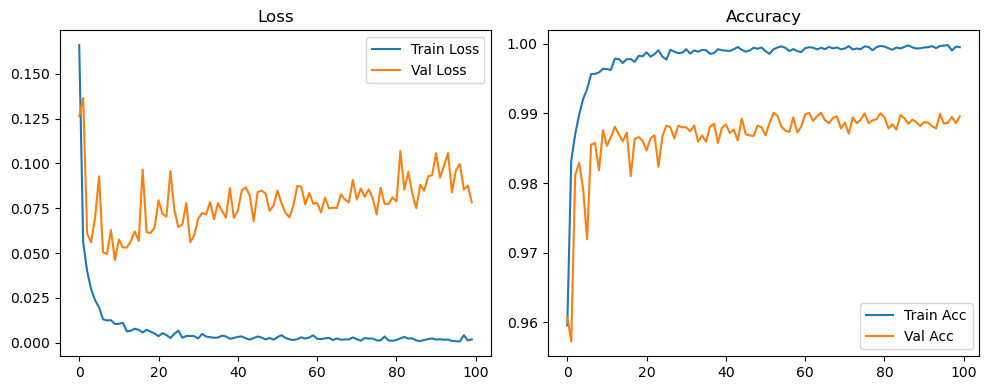

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2088, Acc: 0.9468 | Val Loss: 1.4330, Acc: 0.5833


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9754 | Val Loss: 1.0681, Acc: 0.7168


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9799 | Val Loss: 0.6232, Acc: 0.7920


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9837 | Val Loss: 0.6183, Acc: 0.8208


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9858 | Val Loss: 0.6013, Acc: 0.8239


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9864 | Val Loss: 0.5432, Acc: 0.8492


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.4958, Acc: 0.8630


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.4093, Acc: 0.8825


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.5021, Acc: 0.8709


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.4761, Acc: 0.8847


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.3922, Acc: 0.9022


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.2673, Acc: 0.9293


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.3373, Acc: 0.9133


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.3602, Acc: 0.9132


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.3587, Acc: 0.9165


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.5514, Acc: 0.8799


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.4601, Acc: 0.9000


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.4449, Acc: 0.9002


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 0.5607, Acc: 0.8843


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.6493, Acc: 0.8766


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.3581, Acc: 0.9207


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.3648, Acc: 0.9266


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.3062, Acc: 0.9361


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.4123, Acc: 0.9192


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.3629, Acc: 0.9272


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.3626, Acc: 0.9249


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.4138, Acc: 0.9253


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.3240, Acc: 0.9373


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.4061, Acc: 0.9253


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.2926, Acc: 0.9428


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.4221, Acc: 0.9265


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.4834, Acc: 0.9179


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.3497, Acc: 0.9355


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.4211, Acc: 0.9245


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.2446, Acc: 0.9533


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.3374, Acc: 0.9416


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.2190, Acc: 0.9601


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.2148, Acc: 0.9603


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.2737, Acc: 0.9560


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.3019, Acc: 0.9517


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.3772, Acc: 0.9366


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.3570, Acc: 0.9423


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.4018, Acc: 0.9363


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.2293, Acc: 0.9622


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.2241, Acc: 0.9588


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.2811, Acc: 0.9545


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.4041, Acc: 0.9355


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.2576, Acc: 0.9593


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.2074, Acc: 0.9661


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.2432, Acc: 0.9615


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.3314, Acc: 0.9503


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.3778, Acc: 0.9440


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.3597, Acc: 0.9460


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.3237, Acc: 0.9495


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.4128, Acc: 0.9424


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.2909, Acc: 0.9563


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.2713, Acc: 0.9597


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.3022, Acc: 0.9556


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.4151, Acc: 0.9433


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.2888, Acc: 0.9563


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.2782, Acc: 0.9607


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.2683, Acc: 0.9626


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.3457, Acc: 0.9490


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.2947, Acc: 0.9597


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.2529, Acc: 0.9627


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.3190, Acc: 0.9539


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1602, Acc: 0.9755


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.2373, Acc: 0.9648


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.3318, Acc: 0.9537


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.3253, Acc: 0.9553


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.3200, Acc: 0.9572


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.3220, Acc: 0.9581


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.2969, Acc: 0.9615


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.2532, Acc: 0.9661


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.2417, Acc: 0.9682


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.2410, Acc: 0.9683


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.3034, Acc: 0.9588


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.2395, Acc: 0.9688


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.2710, Acc: 0.9645


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.2688, Acc: 0.9641


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.2875, Acc: 0.9612


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.3026, Acc: 0.9621


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2633, Acc: 0.9661


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9978 | Val Loss: 0.2425, Acc: 0.9689


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.2262, Acc: 0.9716


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.2386, Acc: 0.9682


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.2147, Acc: 0.9727


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.2754, Acc: 0.9654


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.3145, Acc: 0.9628


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.2717, Acc: 0.9673


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.2773, Acc: 0.9662


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.2977, Acc: 0.9643


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.2332, Acc: 0.9724


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.2269, Acc: 0.9729


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.3279, Acc: 0.9565


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.3450, Acc: 0.9567


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.2830, Acc: 0.9649


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.5249, Acc: 0.9390


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.2682, Acc: 0.9658


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2570, Acc: 0.9683


Final Test Loss: 0.2797 Accuracy: 0.9680


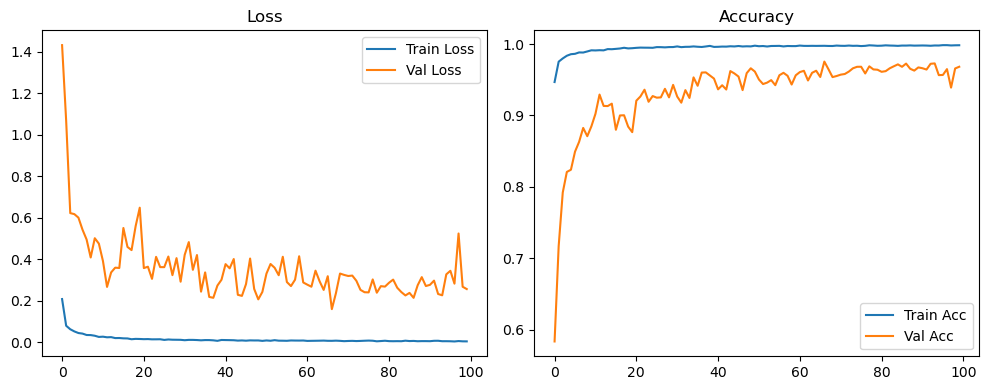

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3824, Acc: 0.8875 | Val Loss: 3.9146, Acc: 0.2097


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1595, Acc: 0.9530 | Val Loss: 2.6631, Acc: 0.2893


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1299, Acc: 0.9617 | Val Loss: 2.0476, Acc: 0.3937


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1161, Acc: 0.9653 | Val Loss: 1.5058, Acc: 0.5294


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9672 | Val Loss: 1.3631, Acc: 0.5260


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0986, Acc: 0.9704 | Val Loss: 1.9641, Acc: 0.4211


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9719 | Val Loss: 1.9061, Acc: 0.4497


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9717 | Val Loss: 1.0260, Acc: 0.6239


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9740 | Val Loss: 1.1797, Acc: 0.5996


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9749 | Val Loss: 1.8982, Acc: 0.4899


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9751 | Val Loss: 1.3496, Acc: 0.5618


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0779, Acc: 0.9761 | Val Loss: 0.6166, Acc: 0.7495


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9773 | Val Loss: 1.0177, Acc: 0.6421


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9772 | Val Loss: 1.2587, Acc: 0.5707


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9774 | Val Loss: 1.3338, Acc: 0.5270


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9798 | Val Loss: 0.8548, Acc: 0.6562


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9792 | Val Loss: 1.1146, Acc: 0.5927


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9798 | Val Loss: 0.9859, Acc: 0.6219


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9793 | Val Loss: 0.8525, Acc: 0.6739


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9812 | Val Loss: 1.0668, Acc: 0.6102


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9801 | Val Loss: 0.7262, Acc: 0.7124


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9809 | Val Loss: 0.7920, Acc: 0.6588


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9811 | Val Loss: 0.7576, Acc: 0.6826


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9818 | Val Loss: 0.8062, Acc: 0.6645


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9816 | Val Loss: 0.8697, Acc: 0.6371


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9827 | Val Loss: 1.0596, Acc: 0.5598


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9826 | Val Loss: 0.7794, Acc: 0.6432


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9821 | Val Loss: 0.7006, Acc: 0.6711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.6602, Acc: 0.7226


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9826 | Val Loss: 1.0652, Acc: 0.4998


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9828 | Val Loss: 0.5338, Acc: 0.7615


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.8195, Acc: 0.6322


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9840 | Val Loss: 0.7027, Acc: 0.6828


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9838 | Val Loss: 0.5626, Acc: 0.7556


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9843 | Val Loss: 0.7818, Acc: 0.6172


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9842 | Val Loss: 0.7243, Acc: 0.6583


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9835 | Val Loss: 0.8412, Acc: 0.5943


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9836 | Val Loss: 0.6790, Acc: 0.6948


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.7007, Acc: 0.6830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9837 | Val Loss: 0.7877, Acc: 0.6280


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9856 | Val Loss: 0.6849, Acc: 0.6992


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 0.5195, Acc: 0.8183


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9851 | Val Loss: 0.7065, Acc: 0.6754


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.7359, Acc: 0.6581


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.7141, Acc: 0.6866


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.7557, Acc: 0.6221


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.6587, Acc: 0.7318


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9850 | Val Loss: 0.6123, Acc: 0.7715


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.6997, Acc: 0.7375


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.7681, Acc: 0.6368


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.7675, Acc: 0.6595


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.6613, Acc: 0.7095


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9866 | Val Loss: 0.7584, Acc: 0.6653


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 0.8479, Acc: 0.5684


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.7685, Acc: 0.6667


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9856 | Val Loss: 0.7962, Acc: 0.6554


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9867 | Val Loss: 0.7567, Acc: 0.6785


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9860 | Val Loss: 0.7271, Acc: 0.7838


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9863 | Val Loss: 0.8565, Acc: 0.5807


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.7690, Acc: 0.7096


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.8511, Acc: 0.6932


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.8402, Acc: 0.6684


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9863 | Val Loss: 0.6808, Acc: 0.8395


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.7645, Acc: 0.7742


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9875 | Val Loss: 0.8434, Acc: 0.7488


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9872 | Val Loss: 0.7926, Acc: 0.7638


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.8770, Acc: 0.6331


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.8000, Acc: 0.7364


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9864 | Val Loss: 0.8377, Acc: 0.7063


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.9019, Acc: 0.7268


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.9139, Acc: 0.7350


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.8119, Acc: 0.7548


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9873 | Val Loss: 0.8927, Acc: 0.6733


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9876 | Val Loss: 0.9538, Acc: 0.5700


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.9744, Acc: 0.6585


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9885 | Val Loss: 0.9313, Acc: 0.6593


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9881 | Val Loss: 1.0558, Acc: 0.5387


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9879 | Val Loss: 1.0581, Acc: 0.5120


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 1.0597, Acc: 0.5719


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 1.0215, Acc: 0.6583


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9876 | Val Loss: 1.1586, Acc: 0.5369


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 1.1299, Acc: 0.6410


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 1.1769, Acc: 0.4884


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9879 | Val Loss: 1.1750, Acc: 0.5470


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9885 | Val Loss: 1.0685, Acc: 0.5675


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 1.1312, Acc: 0.5926


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 1.1748, Acc: 0.6441


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 1.1315, Acc: 0.6058


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9883 | Val Loss: 1.1711, Acc: 0.6517


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 1.3057, Acc: 0.6069


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 1.3397, Acc: 0.6528


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 1.3717, Acc: 0.4693


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 1.3106, Acc: 0.4818


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 1.3150, Acc: 0.5148


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 1.2850, Acc: 0.5748


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 1.3157, Acc: 0.5275


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 1.3476, Acc: 0.4594


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9889 | Val Loss: 1.2387, Acc: 0.5602


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 1.3368, Acc: 0.4631


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9896 | Val Loss: 1.4453, Acc: 0.4840


Final Test Loss: 1.4383 Accuracy: 0.4966


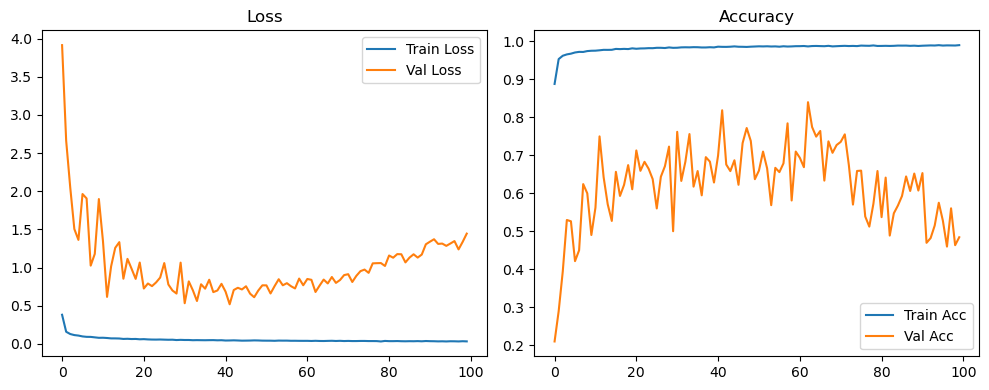

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1654, Acc: 0.9593 | Val Loss: 0.1149, Acc: 0.9656


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9833 | Val Loss: 0.1179, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.0607, Acc: 0.9807


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.0526, Acc: 0.9843


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0589, Acc: 0.9824


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0575, Acc: 0.9836


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0483, Acc: 0.9863


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0770, Acc: 0.9772


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0566, Acc: 0.9852


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0515, Acc: 0.9865


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0744, Acc: 0.9805


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9968 | Val Loss: 0.0521, Acc: 0.9872


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0568, Acc: 0.9866


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0497, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0490, Acc: 0.9889


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0606, Acc: 0.9865


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0758, Acc: 0.9841


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0504, Acc: 0.9873


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0574, Acc: 0.9884


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0558, Acc: 0.9887


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0597, Acc: 0.9878


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0680, Acc: 0.9854


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0600, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1399, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0830, Acc: 0.9839


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0604, Acc: 0.9878


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0889, Acc: 0.9848


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0728, Acc: 0.9878


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0647, Acc: 0.9882


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0804, Acc: 0.9862


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0802, Acc: 0.9860


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0812, Acc: 0.9863


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0634, Acc: 0.9891


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0848, Acc: 0.9852


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0684, Acc: 0.9866


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0663, Acc: 0.9864


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0687, Acc: 0.9882


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0695, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0700, Acc: 0.9889


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0612, Acc: 0.9890


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0701, Acc: 0.9883


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0815, Acc: 0.9868


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0723, Acc: 0.9871


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0663, Acc: 0.9878


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0575, Acc: 0.9904


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0967, Acc: 0.9854


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0741, Acc: 0.9887


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0773, Acc: 0.9881


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0841, Acc: 0.9867


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0705, Acc: 0.9882


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0621, Acc: 0.9897


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9908


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0614, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0564, Acc: 0.9906


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0736, Acc: 0.9887


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0644, Acc: 0.9908


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0690, Acc: 0.9898


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0728, Acc: 0.9881


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0637, Acc: 0.9897


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0646, Acc: 0.9894


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0759, Acc: 0.9888


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0671, Acc: 0.9900


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9904


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0678, Acc: 0.9893


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0688, Acc: 0.9891


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0633, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0696, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9908


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0675, Acc: 0.9897


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0719, Acc: 0.9900


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0716, Acc: 0.9898


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0660, Acc: 0.9900


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0694, Acc: 0.9900


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0634, Acc: 0.9912


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0691, Acc: 0.9892


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0695, Acc: 0.9898


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0662, Acc: 0.9905


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0669, Acc: 0.9903


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0682, Acc: 0.9902


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0651, Acc: 0.9908


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9912


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0628, Acc: 0.9918


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0628, Acc: 0.9920


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9922


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9919


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9920


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9917


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9919


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9919


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0674, Acc: 0.9908


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9908


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9909


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9908


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0666, Acc: 0.9915


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9915


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0634, Acc: 0.9917


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9912


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9914


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9909


Final Test Loss: 0.0773 Accuracy: 0.9893


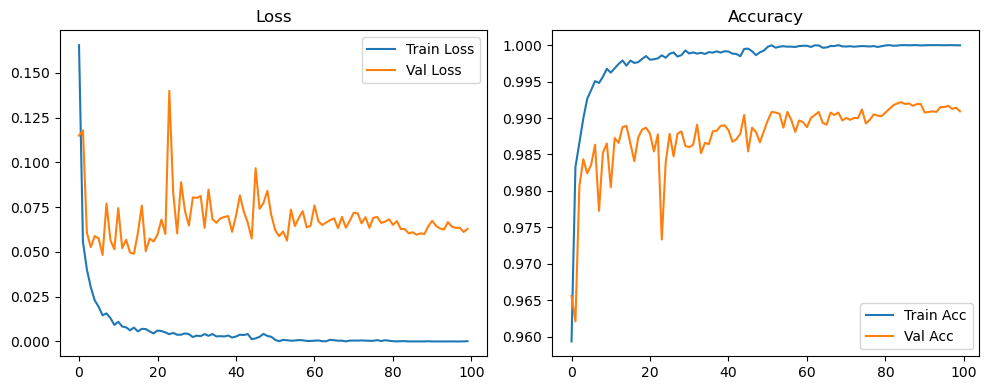

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2083, Acc: 0.9470 | Val Loss: 1.4537, Acc: 0.5826


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9756 | Val Loss: 0.7989, Acc: 0.7653


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9796 | Val Loss: 0.6107, Acc: 0.7992


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 0.3150, Acc: 0.8966


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9848 | Val Loss: 0.5167, Acc: 0.8457


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.5866, Acc: 0.8419


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9885 | Val Loss: 0.4032, Acc: 0.8869


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 0.1912, Acc: 0.9387


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.2133, Acc: 0.9381


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.2097, Acc: 0.9371


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.5693, Acc: 0.8640


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9914 | Val Loss: 0.3364, Acc: 0.9123


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.4207, Acc: 0.8955


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.2117, Acc: 0.9444


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.3538, Acc: 0.9137


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.3018, Acc: 0.9257


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.2263, Acc: 0.9472


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.3080, Acc: 0.9293


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.3174, Acc: 0.9289


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.3245, Acc: 0.9290


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.2614, Acc: 0.9441


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.2781, Acc: 0.9404


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.1889, Acc: 0.9581


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.2754, Acc: 0.9439


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.2724, Acc: 0.9470


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1874, Acc: 0.9588


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.2329, Acc: 0.9531


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.2326, Acc: 0.9537


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.2667, Acc: 0.9475


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.2454, Acc: 0.9533


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.2471, Acc: 0.9548


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.2827, Acc: 0.9444


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1751, Acc: 0.9683


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.2104, Acc: 0.9615


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.2559, Acc: 0.9533


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.3310, Acc: 0.9437


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1619, Acc: 0.9691


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1195, Acc: 0.9772


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.1937, Acc: 0.9673


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.2094, Acc: 0.9644


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.2875, Acc: 0.9529


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.2157, Acc: 0.9641


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.3489, Acc: 0.9443


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.2807, Acc: 0.9537


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.2473, Acc: 0.9579


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.2586, Acc: 0.9580


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.2511, Acc: 0.9578


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1823, Acc: 0.9687


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.3137, Acc: 0.9511


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.2074, Acc: 0.9684


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.2892, Acc: 0.9548


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.2133, Acc: 0.9654


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.2452, Acc: 0.9622


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.2064, Acc: 0.9688


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.2691, Acc: 0.9590


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.2472, Acc: 0.9601


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2735, Acc: 0.9568


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2141, Acc: 0.9664


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.3150, Acc: 0.9543


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.2746, Acc: 0.9598


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2957, Acc: 0.9573


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1999, Acc: 0.9713


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1948, Acc: 0.9721


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1957, Acc: 0.9734


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.2428, Acc: 0.9664


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.2134, Acc: 0.9708


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1604, Acc: 0.9769


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2882, Acc: 0.9608


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.2968, Acc: 0.9597


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.2532, Acc: 0.9666


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2758, Acc: 0.9624


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.3175, Acc: 0.9554


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.2697, Acc: 0.9623


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.2275, Acc: 0.9673


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2169, Acc: 0.9688


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1967, Acc: 0.9751


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2545, Acc: 0.9667


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1775, Acc: 0.9759


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1992, Acc: 0.9728


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.2111, Acc: 0.9730


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.2001, Acc: 0.9728


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1887, Acc: 0.9736


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1905, Acc: 0.9748


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1791, Acc: 0.9768


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1802, Acc: 0.9754


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2035, Acc: 0.9735


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1910, Acc: 0.9741


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2007, Acc: 0.9741


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1895, Acc: 0.9754


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2112, Acc: 0.9728


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2116, Acc: 0.9733


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1852, Acc: 0.9762


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.2215, Acc: 0.9712


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1871, Acc: 0.9762


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1925, Acc: 0.9754


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.2179, Acc: 0.9729


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1869, Acc: 0.9762


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2011, Acc: 0.9742


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1825, Acc: 0.9762


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1810, Acc: 0.9771


Final Test Loss: 0.2018 Accuracy: 0.9737


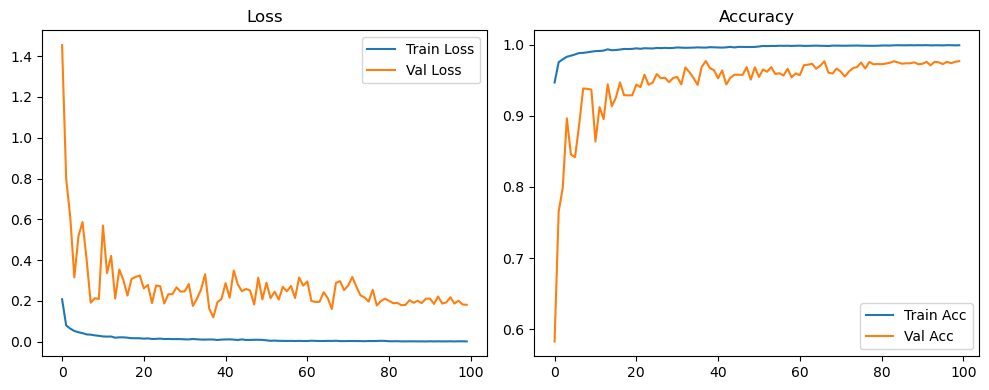

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3821, Acc: 0.8877 | Val Loss: 3.7629, Acc: 0.2218


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1593, Acc: 0.9527 | Val Loss: 2.5991, Acc: 0.3077


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1289, Acc: 0.9617 | Val Loss: 1.8506, Acc: 0.4286


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9650 | Val Loss: 1.2001, Acc: 0.6070


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9676 | Val Loss: 0.8770, Acc: 0.6620


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9694 | Val Loss: 1.8446, Acc: 0.4254


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9716 | Val Loss: 1.2824, Acc: 0.5539


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9727 | Val Loss: 0.8926, Acc: 0.6556


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9744 | Val Loss: 0.8692, Acc: 0.6904


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9756 | Val Loss: 1.3341, Acc: 0.5918


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9754 | Val Loss: 1.1193, Acc: 0.6047


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9759 | Val Loss: 0.5799, Acc: 0.7731


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9776 | Val Loss: 1.3641, Acc: 0.5445


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9775 | Val Loss: 1.1654, Acc: 0.6110


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9777 | Val Loss: 1.0762, Acc: 0.6136


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9792 | Val Loss: 0.6732, Acc: 0.7232


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9794 | Val Loss: 0.8214, Acc: 0.7043


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9807 | Val Loss: 1.0638, Acc: 0.6188


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9803 | Val Loss: 1.0320, Acc: 0.6152


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9811 | Val Loss: 0.8810, Acc: 0.6612


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9793 | Val Loss: 0.8142, Acc: 0.6836


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9814 | Val Loss: 0.6367, Acc: 0.7299


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9826 | Val Loss: 0.8894, Acc: 0.6521


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9822 | Val Loss: 0.8633, Acc: 0.6537


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9814 | Val Loss: 0.8159, Acc: 0.6582


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9817 | Val Loss: 0.9818, Acc: 0.6446


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9827 | Val Loss: 0.9334, Acc: 0.6147


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.5605, Acc: 0.7621


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9838 | Val Loss: 0.5659, Acc: 0.7605


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9828 | Val Loss: 0.9823, Acc: 0.5871


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.7915, Acc: 0.6406


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9841 | Val Loss: 0.8737, Acc: 0.6493


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9841 | Val Loss: 0.9375, Acc: 0.5937


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9851 | Val Loss: 0.6767, Acc: 0.7225


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9854 | Val Loss: 0.6016, Acc: 0.7212


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9845 | Val Loss: 0.6505, Acc: 0.7127


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 0.6491, Acc: 0.7117


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 0.6334, Acc: 0.7315


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.4709, Acc: 0.8033


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9844 | Val Loss: 0.5615, Acc: 0.7640


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 0.5615, Acc: 0.7675


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9851 | Val Loss: 0.4441, Acc: 0.8361


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9854 | Val Loss: 0.5760, Acc: 0.7839


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 0.5511, Acc: 0.7976


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9865 | Val Loss: 0.6452, Acc: 0.7177


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9853 | Val Loss: 0.6509, Acc: 0.7247


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.7604, Acc: 0.6593


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9852 | Val Loss: 0.7247, Acc: 0.6805


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9858 | Val Loss: 0.7680, Acc: 0.6709


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9859 | Val Loss: 0.6449, Acc: 0.7181


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.6249, Acc: 0.7562


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.6042, Acc: 0.7568


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9885 | Val Loss: 0.6659, Acc: 0.7277


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.6433, Acc: 0.7306


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.6538, Acc: 0.7484


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.6133, Acc: 0.7669


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.6803, Acc: 0.7170


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.5540, Acc: 0.8033


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.7206, Acc: 0.6632


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.6731, Acc: 0.7401


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.7123, Acc: 0.7296


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.7035, Acc: 0.7466


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9881 | Val Loss: 0.6655, Acc: 0.7942


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9900 | Val Loss: 0.6124, Acc: 0.8014


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9894 | Val Loss: 0.6799, Acc: 0.7502


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.6357, Acc: 0.7888


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.7397, Acc: 0.7471


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.7414, Acc: 0.7234


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.7853, Acc: 0.6892


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.7043, Acc: 0.7540


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.6424, Acc: 0.8079


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.6682, Acc: 0.7724


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.7218, Acc: 0.7692


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.7892, Acc: 0.7097


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9889 | Val Loss: 0.7704, Acc: 0.7448


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.7530, Acc: 0.7624


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.8343, Acc: 0.6921


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.8371, Acc: 0.7158


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.8477, Acc: 0.6822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.8218, Acc: 0.7197


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.8311, Acc: 0.7371


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.8232, Acc: 0.7396


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9910 | Val Loss: 0.8463, Acc: 0.7128


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.8743, Acc: 0.7121


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.9003, Acc: 0.6857


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.8572, Acc: 0.7274


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.8707, Acc: 0.7164


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.8552, Acc: 0.7421


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9923 | Val Loss: 0.8783, Acc: 0.7138


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.9213, Acc: 0.6467


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.9401, Acc: 0.6621


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.9590, Acc: 0.6215


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.9138, Acc: 0.6820


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.9493, Acc: 0.6588


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.9565, Acc: 0.6262


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.9691, Acc: 0.6987


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.9828, Acc: 0.6912


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.9845, Acc: 0.6328


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.9928, Acc: 0.6223


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 1.0024, Acc: 0.6479


Final Test Loss: 0.9978 Accuracy: 0.6467


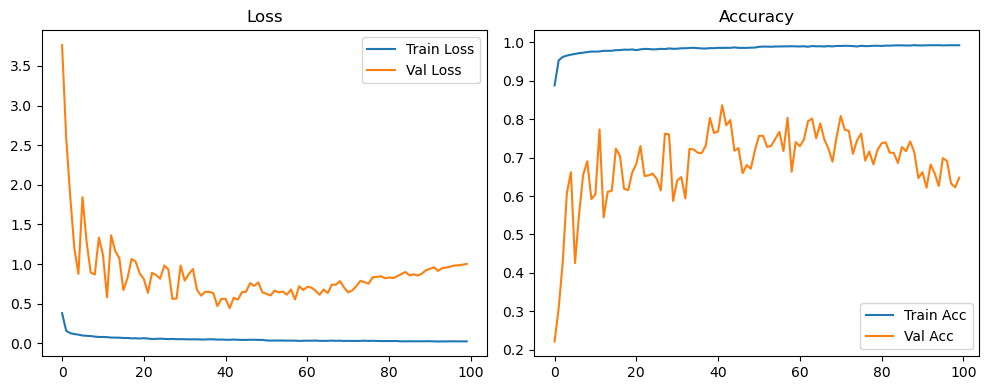

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1657, Acc: 0.9593 | Val Loss: 0.1290, Acc: 0.9596


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9834 | Val Loss: 0.1194, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0735, Acc: 0.9773


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0762, Acc: 0.9783


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0769, Acc: 0.9784


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0677, Acc: 0.9797


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0654, Acc: 0.9819


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0607, Acc: 0.9844


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0517, Acc: 0.9856


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0599, Acc: 0.9840


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0525, Acc: 0.9871


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1278, Acc: 0.9690


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0708, Acc: 0.9828


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0534, Acc: 0.9882


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0479, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0551, Acc: 0.9878


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0570, Acc: 0.9874


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0673, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0590, Acc: 0.9874


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0613, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0861, Acc: 0.9840


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0711, Acc: 0.9863


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0830, Acc: 0.9830


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0740, Acc: 0.9868


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0550, Acc: 0.9895


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0691, Acc: 0.9881


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0690, Acc: 0.9873


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0762, Acc: 0.9865


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0614, Acc: 0.9879


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0581, Acc: 0.9894


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0709, Acc: 0.9880


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0732, Acc: 0.9880


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0615, Acc: 0.9894


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0607, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0707, Acc: 0.9878


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0700, Acc: 0.9891


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0768, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0736, Acc: 0.9883


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0684, Acc: 0.9898


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0737, Acc: 0.9893


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0806, Acc: 0.9874


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0671, Acc: 0.9891


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0762, Acc: 0.9882


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0832, Acc: 0.9872


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0729, Acc: 0.9888


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0689, Acc: 0.9900


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0686, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0819, Acc: 0.9881


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0887, Acc: 0.9873


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0789, Acc: 0.9882


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0717, Acc: 0.9891


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0692, Acc: 0.9895


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0643, Acc: 0.9900


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0700, Acc: 0.9898


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0736, Acc: 0.9895


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0742, Acc: 0.9886


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0695, Acc: 0.9882


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0718, Acc: 0.9894


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0689, Acc: 0.9903


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0677, Acc: 0.9903


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0666, Acc: 0.9906


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0723, Acc: 0.9901


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0718, Acc: 0.9894


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0704, Acc: 0.9893


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0683, Acc: 0.9902


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0717, Acc: 0.9890


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0732, Acc: 0.9874


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0668, Acc: 0.9902


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0660, Acc: 0.9898


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0706, Acc: 0.9882


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9898


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9906


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0841, Acc: 0.9878


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0786, Acc: 0.9890


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0721, Acc: 0.9898


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0752, Acc: 0.9890


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0814, Acc: 0.9893


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0716, Acc: 0.9899


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0721, Acc: 0.9890


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0721, Acc: 0.9902


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0701, Acc: 0.9905


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0690, Acc: 0.9904


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0666, Acc: 0.9905


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9912


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9909


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0664, Acc: 0.9904


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9910


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9912


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0680, Acc: 0.9912


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0673, Acc: 0.9910


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0690, Acc: 0.9912


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0676, Acc: 0.9909


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0671, Acc: 0.9910


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0671, Acc: 0.9910


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0682, Acc: 0.9910


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9915


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9909


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0654, Acc: 0.9915


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9910


Final Test Loss: 0.0662 Accuracy: 0.9901


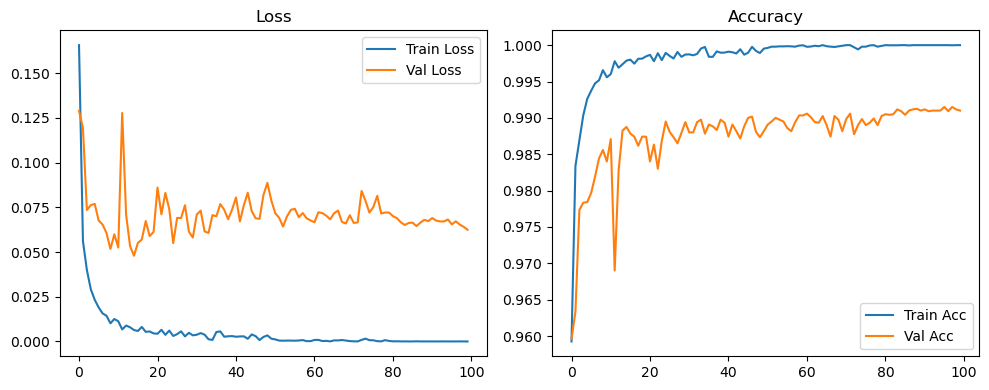

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2086, Acc: 0.9470 | Val Loss: 1.1923, Acc: 0.6310


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9761 | Val Loss: 0.6845, Acc: 0.7916


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9799 | Val Loss: 0.6230, Acc: 0.8013


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9831 | Val Loss: 0.3698, Acc: 0.8829


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9858 | Val Loss: 0.5327, Acc: 0.8443


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.4709, Acc: 0.8700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9881 | Val Loss: 0.7989, Acc: 0.8067


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9892 | Val Loss: 0.3727, Acc: 0.8908


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.4216, Acc: 0.8869


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.2011, Acc: 0.9443


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9908 | Val Loss: 0.4006, Acc: 0.9030


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.3153, Acc: 0.9190


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.4009, Acc: 0.9008


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9926 | Val Loss: 0.2650, Acc: 0.9359


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.2422, Acc: 0.9447


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.3854, Acc: 0.9133


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.2453, Acc: 0.9424


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.2155, Acc: 0.9485


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.3962, Acc: 0.9150


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.2716, Acc: 0.9416


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.1571, Acc: 0.9643


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.2215, Acc: 0.9517


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9946 | Val Loss: 0.1581, Acc: 0.9672


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.2266, Acc: 0.9521


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 0.2352, Acc: 0.9517


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1902, Acc: 0.9607


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.2340, Acc: 0.9522


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1803, Acc: 0.9644


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9951 | Val Loss: 0.2084, Acc: 0.9580


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.2670, Acc: 0.9463


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.2377, Acc: 0.9532


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.2562, Acc: 0.9493


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.2023, Acc: 0.9591


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.2931, Acc: 0.9444


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.2214, Acc: 0.9587


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.2850, Acc: 0.9507


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1433, Acc: 0.9714


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.2347, Acc: 0.9571


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.1948, Acc: 0.9620


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1677, Acc: 0.9698


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.2219, Acc: 0.9611


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1597, Acc: 0.9716


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.2450, Acc: 0.9587


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.2252, Acc: 0.9619


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1592, Acc: 0.9718


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1388, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.2001, Acc: 0.9676


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1291, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1561, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1641, Acc: 0.9729


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1435, Acc: 0.9766


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1483, Acc: 0.9760


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1598, Acc: 0.9752


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1486, Acc: 0.9766


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1550, Acc: 0.9770


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1309, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1443, Acc: 0.9767


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1480, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1331, Acc: 0.9789


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1501, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1214, Acc: 0.9814


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1201, Acc: 0.9822


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1102, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1187, Acc: 0.9826


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1319, Acc: 0.9800


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1247, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1119, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1383, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1503, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1431, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1323, Acc: 0.9803


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1532, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1427, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1398, Acc: 0.9779


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1241, Acc: 0.9817


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1110, Acc: 0.9825


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1433, Acc: 0.9787


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1331, Acc: 0.9809


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1264, Acc: 0.9812


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1553, Acc: 0.9797


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1405, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1275, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1394, Acc: 0.9809


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1304, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1351, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1420, Acc: 0.9809


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1276, Acc: 0.9822


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1379, Acc: 0.9813


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1379, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9991 | Val Loss: 0.1387, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1465, Acc: 0.9803


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1392, Acc: 0.9806


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1545, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1389, Acc: 0.9807


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1492, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1415, Acc: 0.9807


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1408, Acc: 0.9806


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1414, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1463, Acc: 0.9793


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1294, Acc: 0.9829


Final Test Loss: 0.1314 Accuracy: 0.9797


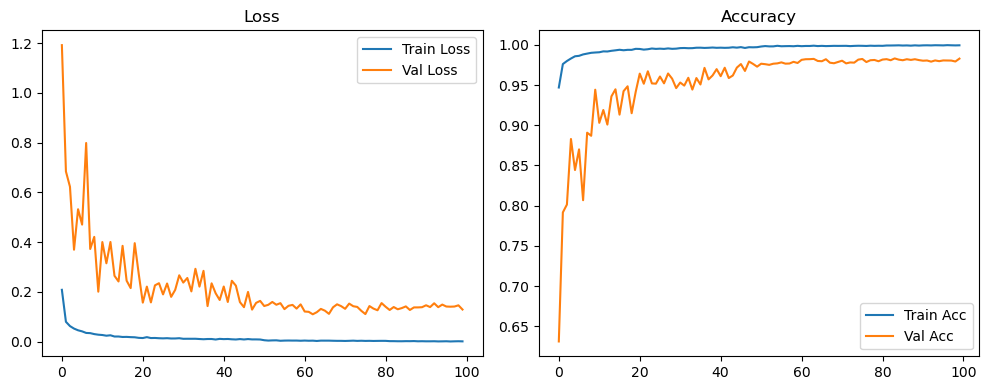

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3825, Acc: 0.8874 | Val Loss: 3.4566, Acc: 0.2462


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1602, Acc: 0.9525 | Val Loss: 2.2933, Acc: 0.3445


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9614 | Val Loss: 1.8106, Acc: 0.4387


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1179, Acc: 0.9650 | Val Loss: 1.3798, Acc: 0.5494


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9681 | Val Loss: 1.0551, Acc: 0.6028


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9704 | Val Loss: 1.4495, Acc: 0.5190


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9716 | Val Loss: 0.9971, Acc: 0.6454


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9727 | Val Loss: 0.6675, Acc: 0.7333


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0857, Acc: 0.9737 | Val Loss: 0.7316, Acc: 0.7295


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9749 | Val Loss: 1.0389, Acc: 0.6640


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9751 | Val Loss: 0.9465, Acc: 0.6552


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9761 | Val Loss: 0.6086, Acc: 0.7593


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9770 | Val Loss: 1.0178, Acc: 0.6425


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9765 | Val Loss: 0.8493, Acc: 0.6983


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9785 | Val Loss: 0.7453, Acc: 0.6963


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9802 | Val Loss: 0.8135, Acc: 0.6937


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9786 | Val Loss: 1.0626, Acc: 0.6402


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9801 | Val Loss: 0.7380, Acc: 0.7194


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9807 | Val Loss: 0.5400, Acc: 0.7831


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9809 | Val Loss: 0.9299, Acc: 0.6402


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.6592, Acc: 0.7347


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9819 | Val Loss: 0.5058, Acc: 0.7948


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.6624, Acc: 0.7380


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.4887, Acc: 0.8047


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9814 | Val Loss: 0.5025, Acc: 0.7912


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9825 | Val Loss: 0.6792, Acc: 0.7231


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9827 | Val Loss: 0.6774, Acc: 0.6977


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9829 | Val Loss: 0.5866, Acc: 0.7578


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.6044, Acc: 0.7599


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9828 | Val Loss: 0.8069, Acc: 0.6595


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9832 | Val Loss: 0.7370, Acc: 0.6762


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9847 | Val Loss: 0.7358, Acc: 0.7131


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9841 | Val Loss: 0.6827, Acc: 0.7093


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9846 | Val Loss: 0.5890, Acc: 0.7632


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9843 | Val Loss: 0.6229, Acc: 0.7291


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9846 | Val Loss: 0.5418, Acc: 0.7875


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.6946, Acc: 0.7212


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9845 | Val Loss: 0.6537, Acc: 0.7566


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9842 | Val Loss: 0.6635, Acc: 0.7330


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9843 | Val Loss: 0.6936, Acc: 0.7017


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9858 | Val Loss: 0.6388, Acc: 0.7452


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9855 | Val Loss: 0.5108, Acc: 0.8173


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9844 | Val Loss: 0.6535, Acc: 0.7307


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9855 | Val Loss: 0.5923, Acc: 0.7717


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.6369, Acc: 0.7313


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9854 | Val Loss: 0.6547, Acc: 0.7524


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9858 | Val Loss: 0.7251, Acc: 0.7102


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9846 | Val Loss: 0.7530, Acc: 0.6850


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9861 | Val Loss: 0.7341, Acc: 0.7062


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.6835, Acc: 0.7340


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.6236, Acc: 0.7858


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.5819, Acc: 0.8122


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.7073, Acc: 0.7070


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9883 | Val Loss: 0.7029, Acc: 0.6969


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.6857, Acc: 0.7387


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.6297, Acc: 0.7688


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.6857, Acc: 0.7318


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.6543, Acc: 0.8184


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.6876, Acc: 0.7550


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.7321, Acc: 0.7618


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.7757, Acc: 0.6977


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.7176, Acc: 0.7578


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.6943, Acc: 0.7858


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.6687, Acc: 0.7983


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.7145, Acc: 0.7586


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.7165, Acc: 0.7644


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9892 | Val Loss: 0.8340, Acc: 0.6822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.7824, Acc: 0.7128


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.8077, Acc: 0.7144


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.7538, Acc: 0.7611


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.7426, Acc: 0.7985


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.7574, Acc: 0.7817


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9901 | Val Loss: 0.7556, Acc: 0.7812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.8633, Acc: 0.6956


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.7821, Acc: 0.8037


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.7896, Acc: 0.7968


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9900 | Val Loss: 0.8768, Acc: 0.7462


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9894 | Val Loss: 0.8475, Acc: 0.7615


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.9039, Acc: 0.7021


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.8916, Acc: 0.7243


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9910 | Val Loss: 0.8520, Acc: 0.7565


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.8225, Acc: 0.7837


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.8457, Acc: 0.7557


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.8737, Acc: 0.7588


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.8854, Acc: 0.7533


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.8776, Acc: 0.7518


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.8926, Acc: 0.7470


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.8807, Acc: 0.7673


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.9117, Acc: 0.7377


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.9365, Acc: 0.7215


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.9349, Acc: 0.7359


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.9334, Acc: 0.7151


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.9126, Acc: 0.7682


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.9528, Acc: 0.7331


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.9550, Acc: 0.7120


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.9224, Acc: 0.7627


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.9373, Acc: 0.7570


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.9582, Acc: 0.7099


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.9505, Acc: 0.7268


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.9478, Acc: 0.7278


Final Test Loss: 0.9427 Accuracy: 0.7251


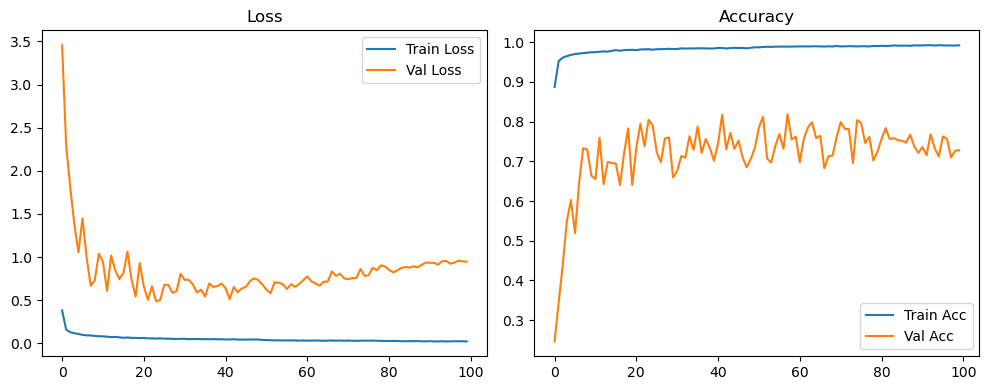

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1656, Acc: 0.9592 | Val Loss: 0.1819, Acc: 0.9420


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9834 | Val Loss: 0.1297, Acc: 0.9586


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9869 | Val Loss: 0.0923, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9901 | Val Loss: 0.0616, Acc: 0.9818


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0776, Acc: 0.9763


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0594, Acc: 0.9817


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0524, Acc: 0.9855


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1310, Acc: 0.9636


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0564, Acc: 0.9859


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0491, Acc: 0.9872


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0760, Acc: 0.9800


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0460, Acc: 0.9893


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0528, Acc: 0.9871


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0650, Acc: 0.9862


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0528, Acc: 0.9878


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0760, Acc: 0.9844


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0542, Acc: 0.9888


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0577, Acc: 0.9886


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0649, Acc: 0.9862


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0507, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0588, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0648, Acc: 0.9873


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0613, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0773, Acc: 0.9864


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0687, Acc: 0.9863


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1225, Acc: 0.9804


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0879, Acc: 0.9841


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0692, Acc: 0.9888


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0789, Acc: 0.9866


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0776, Acc: 0.9865


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0607, Acc: 0.9882


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0907, Acc: 0.9842


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0796, Acc: 0.9857


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0694, Acc: 0.9880


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0620, Acc: 0.9899


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0585, Acc: 0.9898


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0828, Acc: 0.9860


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0563, Acc: 0.9900


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0773, Acc: 0.9870


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0760, Acc: 0.9881


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0706, Acc: 0.9885


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0637, Acc: 0.9898


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0650, Acc: 0.9898


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0707, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0774, Acc: 0.9880


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0660, Acc: 0.9896


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0628, Acc: 0.9907


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0693, Acc: 0.9884


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0880, Acc: 0.9867


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0754, Acc: 0.9876


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0605, Acc: 0.9911


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0617, Acc: 0.9909


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0570, Acc: 0.9913


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9906


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9911


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9911


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9911


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9911


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9917


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9911


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9914


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9912


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9910


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9918


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0552, Acc: 0.9911


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9913


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9917


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9921


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9915


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9917


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9919


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9919


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9915


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9923


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9913


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9922


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0599, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0562, Acc: 0.9916


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9913


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9919


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9920


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9914


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9913


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9917


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9917


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9923


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9919


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9920


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9921


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9918


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9920


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9918


Final Test Loss: 0.0749 Accuracy: 0.9898


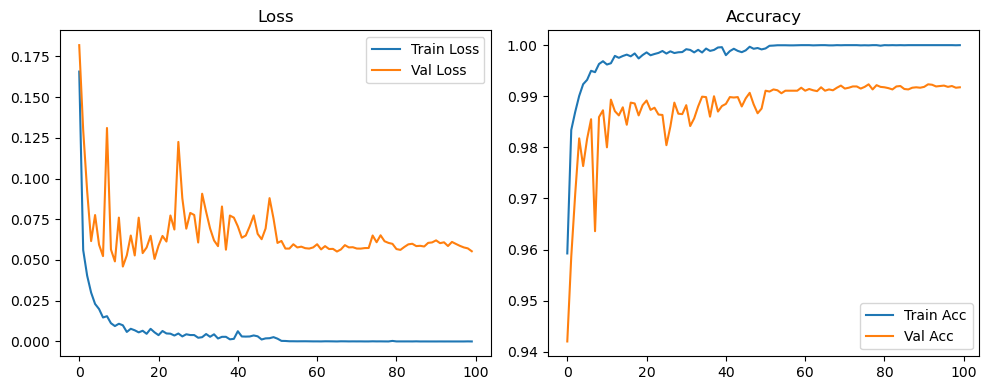

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2084, Acc: 0.9472 | Val Loss: 1.3261, Acc: 0.5950


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9755 | Val Loss: 0.8504, Acc: 0.7592


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9800 | Val Loss: 0.8319, Acc: 0.7467


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9833 | Val Loss: 0.4650, Acc: 0.8567


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 0.5843, Acc: 0.8305


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9860 | Val Loss: 0.6009, Acc: 0.8482


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.8851, Acc: 0.7926


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9882 | Val Loss: 0.3445, Acc: 0.8965


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.4976, Acc: 0.8661


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.3119, Acc: 0.9167


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.4107, Acc: 0.8948


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.2661, Acc: 0.9295


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.5085, Acc: 0.8778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.4497, Acc: 0.9004


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9926 | Val Loss: 0.3384, Acc: 0.9172


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.3677, Acc: 0.9150


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9929 | Val Loss: 0.2673, Acc: 0.9392


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.3781, Acc: 0.9164


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.4097, Acc: 0.9105


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.4409, Acc: 0.9161


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.2589, Acc: 0.9437


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1843, Acc: 0.9575


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.2079, Acc: 0.9533


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.3475, Acc: 0.9305


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.3269, Acc: 0.9323


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1446, Acc: 0.9695


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.2555, Acc: 0.9511


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1824, Acc: 0.9641


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1783, Acc: 0.9658


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.2392, Acc: 0.9537


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9956 | Val Loss: 0.1348, Acc: 0.9736


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.2050, Acc: 0.9597


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9962 | Val Loss: 0.2162, Acc: 0.9598


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.2323, Acc: 0.9581


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1911, Acc: 0.9640


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.2267, Acc: 0.9589


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1738, Acc: 0.9701


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1770, Acc: 0.9694


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9965 | Val Loss: 0.1781, Acc: 0.9701


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1611, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.2333, Acc: 0.9603


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.2521, Acc: 0.9570


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.2810, Acc: 0.9548


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.2481, Acc: 0.9583


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1914, Acc: 0.9684


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1491, Acc: 0.9749


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.2134, Acc: 0.9653


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1852, Acc: 0.9690


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.2060, Acc: 0.9630


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1723, Acc: 0.9717


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2218, Acc: 0.9625


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.2230, Acc: 0.9647


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1868, Acc: 0.9699


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1900, Acc: 0.9698


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2717, Acc: 0.9592


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1687, Acc: 0.9732


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1860, Acc: 0.9703


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1801, Acc: 0.9722


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1663, Acc: 0.9730


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1917, Acc: 0.9704


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.2030, Acc: 0.9692


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1613, Acc: 0.9754


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1565, Acc: 0.9762


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1790, Acc: 0.9724


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1693, Acc: 0.9742


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1576, Acc: 0.9766


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1636, Acc: 0.9756


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1900, Acc: 0.9710


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1984, Acc: 0.9703


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1907, Acc: 0.9724


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1599, Acc: 0.9762


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1932, Acc: 0.9706


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.2012, Acc: 0.9708


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1939, Acc: 0.9712


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1715, Acc: 0.9753


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1504, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1638, Acc: 0.9766


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1654, Acc: 0.9754


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1487, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1644, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1774, Acc: 0.9737


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1573, Acc: 0.9771


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1674, Acc: 0.9760


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1538, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1591, Acc: 0.9766


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1582, Acc: 0.9769


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1471, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1662, Acc: 0.9767


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1605, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1608, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1778, Acc: 0.9748


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1745, Acc: 0.9756


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1749, Acc: 0.9753


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1581, Acc: 0.9777


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1751, Acc: 0.9754


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1850, Acc: 0.9742


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1891, Acc: 0.9729


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1998, Acc: 0.9717


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1799, Acc: 0.9752


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1627, Acc: 0.9770


Final Test Loss: 0.1710 Accuracy: 0.9745


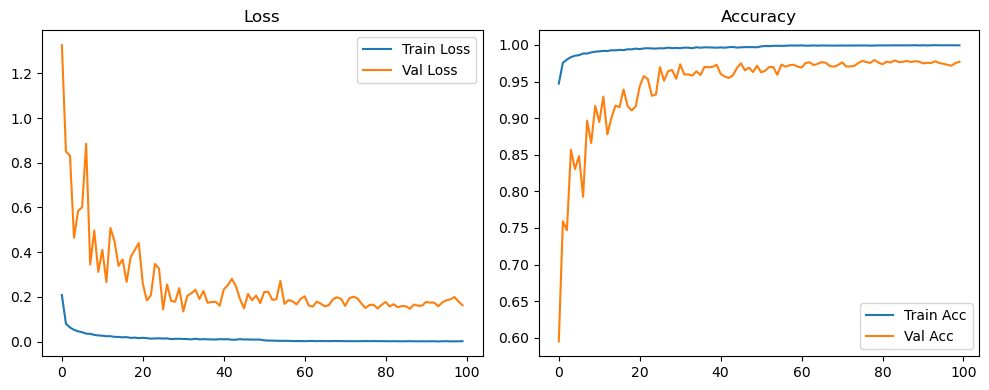

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3823, Acc: 0.8878 | Val Loss: 3.6682, Acc: 0.2283


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1598, Acc: 0.9524 | Val Loss: 2.3988, Acc: 0.3217


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1295, Acc: 0.9621 | Val Loss: 2.0353, Acc: 0.4015


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9651 | Val Loss: 1.5723, Acc: 0.5157


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9677 | Val Loss: 0.9197, Acc: 0.6483


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9692 | Val Loss: 2.0926, Acc: 0.3994


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9720 | Val Loss: 1.1737, Acc: 0.5931


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9715 | Val Loss: 0.9009, Acc: 0.6492


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9735 | Val Loss: 1.1634, Acc: 0.6067


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9747 | Val Loss: 1.4880, Acc: 0.5518


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9741 | Val Loss: 1.1374, Acc: 0.6224


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9762 | Val Loss: 0.4032, Acc: 0.8383


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9771 | Val Loss: 1.3095, Acc: 0.5597


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9769 | Val Loss: 0.9622, Acc: 0.6699


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9779 | Val Loss: 0.7401, Acc: 0.7038


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9797 | Val Loss: 0.7510, Acc: 0.7108


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9789 | Val Loss: 0.9180, Acc: 0.6864


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9806 | Val Loss: 0.8024, Acc: 0.7196


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9799 | Val Loss: 1.0605, Acc: 0.6177


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 0.7748, Acc: 0.7047


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9798 | Val Loss: 0.6650, Acc: 0.7377


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9814 | Val Loss: 0.6631, Acc: 0.7167


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.5404, Acc: 0.7868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9819 | Val Loss: 0.6512, Acc: 0.7559


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9823 | Val Loss: 0.5180, Acc: 0.7837


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9822 | Val Loss: 0.7393, Acc: 0.6986


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9826 | Val Loss: 0.7839, Acc: 0.6541


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9824 | Val Loss: 0.6492, Acc: 0.7136


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9838 | Val Loss: 0.5208, Acc: 0.7848


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9827 | Val Loss: 0.7757, Acc: 0.6553


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9837 | Val Loss: 0.6718, Acc: 0.6871


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9833 | Val Loss: 0.7969, Acc: 0.6537


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.7270, Acc: 0.6654


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9849 | Val Loss: 0.6817, Acc: 0.6887


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.7497, Acc: 0.6426


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9844 | Val Loss: 0.6543, Acc: 0.7077


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9840 | Val Loss: 0.8828, Acc: 0.6176


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9837 | Val Loss: 0.6090, Acc: 0.7455


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.4842, Acc: 0.7965


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9841 | Val Loss: 0.6138, Acc: 0.7275


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9857 | Val Loss: 0.5969, Acc: 0.7541


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9848 | Val Loss: 0.4648, Acc: 0.8273


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.5642, Acc: 0.7531


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9852 | Val Loss: 0.6393, Acc: 0.6983


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.6321, Acc: 0.7071


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9857 | Val Loss: 0.5758, Acc: 0.7362


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.7128, Acc: 0.6507


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.5900, Acc: 0.7472


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9861 | Val Loss: 0.6569, Acc: 0.7002


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.5865, Acc: 0.7588


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.5884, Acc: 0.7428


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.5918, Acc: 0.7375


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9888 | Val Loss: 0.5765, Acc: 0.7436


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9892 | Val Loss: 0.6384, Acc: 0.6897


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.5915, Acc: 0.7358


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.5701, Acc: 0.7608


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.6385, Acc: 0.7044


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.5337, Acc: 0.7808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.5836, Acc: 0.7392


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.5943, Acc: 0.7319


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 0.6117, Acc: 0.7205


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.5687, Acc: 0.7625


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.5101, Acc: 0.8077


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.5065, Acc: 0.8077


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.5608, Acc: 0.7712


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.5134, Acc: 0.7978


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.5592, Acc: 0.7903


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.5644, Acc: 0.7815


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.5640, Acc: 0.7808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.5444, Acc: 0.7937


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9907 | Val Loss: 0.5422, Acc: 0.7948


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9908 | Val Loss: 0.5537, Acc: 0.7867


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.5643, Acc: 0.7890


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.6037, Acc: 0.7461


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.5625, Acc: 0.7784


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.5611, Acc: 0.7809


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.6072, Acc: 0.7348


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.6025, Acc: 0.7436


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.6197, Acc: 0.7292


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.6388, Acc: 0.7177


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.6299, Acc: 0.7368


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.6147, Acc: 0.7518


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.6450, Acc: 0.7155


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.6546, Acc: 0.7309


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.6802, Acc: 0.7141


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.6544, Acc: 0.7186


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.6519, Acc: 0.7192


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.6272, Acc: 0.7437


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.6597, Acc: 0.7273


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.6786, Acc: 0.7154


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.6784, Acc: 0.7258


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.6787, Acc: 0.7175


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.6395, Acc: 0.7557


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.6614, Acc: 0.7363


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.6757, Acc: 0.7057


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.6516, Acc: 0.7268


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.6666, Acc: 0.7308


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.6862, Acc: 0.6923


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.6923, Acc: 0.6923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.6689, Acc: 0.7151


Final Test Loss: 0.6689 Accuracy: 0.7122


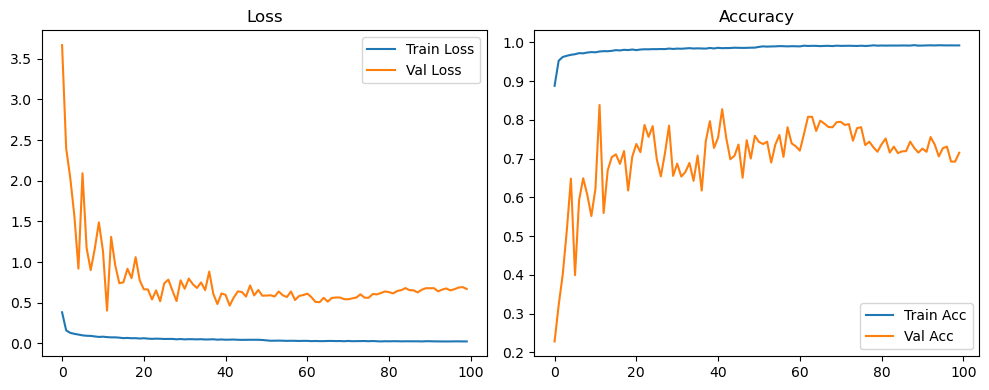

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2004, Acc: 0.9620 | Val Loss: 0.2550, Acc: 0.9272


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9841 | Val Loss: 0.1744, Acc: 0.9450


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9886 | Val Loss: 0.0571, Acc: 0.9818


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.0640, Acc: 0.9802


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.0649, Acc: 0.9807


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0924, Acc: 0.9714


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0641, Acc: 0.9814


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0708, Acc: 0.9789


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0465, Acc: 0.9862


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0689, Acc: 0.9809


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0693, Acc: 0.9802


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1080, Acc: 0.9702


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0531, Acc: 0.9868


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0618, Acc: 0.9854


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0641, Acc: 0.9852


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0492, Acc: 0.9882


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0618, Acc: 0.9855


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0505, Acc: 0.9875


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0582, Acc: 0.9864


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0550, Acc: 0.9876


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0709, Acc: 0.9852


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0603, Acc: 0.9878


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0647, Acc: 0.9867


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0717, Acc: 0.9854


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0604, Acc: 0.9880


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0569, Acc: 0.9888


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0821, Acc: 0.9836


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0663, Acc: 0.9853


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0770, Acc: 0.9853


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0666, Acc: 0.9858


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0613, Acc: 0.9872


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0732, Acc: 0.9854


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0544, Acc: 0.9887


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0677, Acc: 0.9862


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0705, Acc: 0.9859


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0557, Acc: 0.9896


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0668, Acc: 0.9882


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0592, Acc: 0.9880


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0758, Acc: 0.9862


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0751, Acc: 0.9859


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0683, Acc: 0.9869


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0568, Acc: 0.9894


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0702, Acc: 0.9874


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0712, Acc: 0.9880


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0661, Acc: 0.9883


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0690, Acc: 0.9874


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0591, Acc: 0.9883


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0652, Acc: 0.9873


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0591, Acc: 0.9887


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0653, Acc: 0.9882


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0641, Acc: 0.9882


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0652, Acc: 0.9882


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0634, Acc: 0.9892


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0692, Acc: 0.9872


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0685, Acc: 0.9875


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0662, Acc: 0.9898


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0770, Acc: 0.9871


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0654, Acc: 0.9892


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0694, Acc: 0.9884


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0649, Acc: 0.9886


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0707, Acc: 0.9883


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0711, Acc: 0.9868


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0566, Acc: 0.9903


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0675, Acc: 0.9899


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0608, Acc: 0.9898


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0774, Acc: 0.9869


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0580, Acc: 0.9891


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0580, Acc: 0.9911


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0600, Acc: 0.9903


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0671, Acc: 0.9872


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0642, Acc: 0.9901


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0672, Acc: 0.9898


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0772, Acc: 0.9878


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0813, Acc: 0.9881


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0648, Acc: 0.9891


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0697, Acc: 0.9886


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0781, Acc: 0.9872


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0609, Acc: 0.9894


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0714, Acc: 0.9892


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0789, Acc: 0.9872


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0717, Acc: 0.9884


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0667, Acc: 0.9883


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0793, Acc: 0.9877


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0716, Acc: 0.9884


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0681, Acc: 0.9878


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0731, Acc: 0.9877


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0726, Acc: 0.9883


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0742, Acc: 0.9891


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0768, Acc: 0.9884


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0749, Acc: 0.9886


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1051, Acc: 0.9840


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0864, Acc: 0.9868


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0772, Acc: 0.9883


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0689, Acc: 0.9893


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1327, Acc: 0.9801


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0696, Acc: 0.9890


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0679, Acc: 0.9890


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0695, Acc: 0.9889


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1225, Acc: 0.9822


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0737, Acc: 0.9880


Final Test Loss: 0.0882 Accuracy: 0.9861


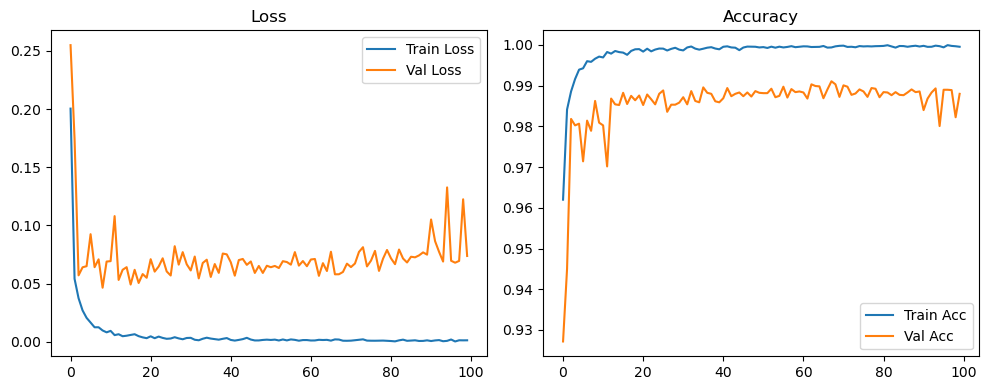

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2546, Acc: 0.9468 | Val Loss: 1.3465, Acc: 0.5610


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9760 | Val Loss: 0.7646, Acc: 0.7558


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.7464, Acc: 0.7808


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 0.8082, Acc: 0.7401


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.9465, Acc: 0.7287


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.9068, Acc: 0.7448


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9888 | Val Loss: 0.7123, Acc: 0.7878


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.5736, Acc: 0.8132


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.5888, Acc: 0.8388


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.4879, Acc: 0.8571


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.5075, Acc: 0.8679


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.2822, Acc: 0.9176


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.4946, Acc: 0.8662


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.6577, Acc: 0.8313


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.5527, Acc: 0.8555


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.5507, Acc: 0.8682


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.3717, Acc: 0.9053


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.4731, Acc: 0.8828


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.4759, Acc: 0.8812


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.6877, Acc: 0.8409


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.7044, Acc: 0.8484


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9951 | Val Loss: 0.4459, Acc: 0.8928


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.3775, Acc: 0.9085


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.6022, Acc: 0.8708


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.4890, Acc: 0.8863


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.4143, Acc: 0.9078


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.4050, Acc: 0.9051


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.3681, Acc: 0.9128


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.4642, Acc: 0.9012


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.3736, Acc: 0.9201


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.2879, Acc: 0.9361


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.3613, Acc: 0.9217


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.3808, Acc: 0.9238


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.3176, Acc: 0.9310


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.2687, Acc: 0.9411


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.3018, Acc: 0.9370


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1685, Acc: 0.9640


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.2591, Acc: 0.9467


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1929, Acc: 0.9584


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.2662, Acc: 0.9410


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.3471, Acc: 0.9278


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.2492, Acc: 0.9477


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.3485, Acc: 0.9273


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.2970, Acc: 0.9407


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.2402, Acc: 0.9483


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.2825, Acc: 0.9462


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.4313, Acc: 0.9134


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.3964, Acc: 0.9250


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.2672, Acc: 0.9473


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.2358, Acc: 0.9531


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.3891, Acc: 0.9272


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.2883, Acc: 0.9432


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.5254, Acc: 0.9049


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.2867, Acc: 0.9450


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.3529, Acc: 0.9312


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.2436, Acc: 0.9517


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.2630, Acc: 0.9470


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.2310, Acc: 0.9544


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.3261, Acc: 0.9369


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.2954, Acc: 0.9443


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.3006, Acc: 0.9429


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.2275, Acc: 0.9596


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.2260, Acc: 0.9575


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.3070, Acc: 0.9434


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.3354, Acc: 0.9415


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.2444, Acc: 0.9569


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.2019, Acc: 0.9621


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.2136, Acc: 0.9592


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.2605, Acc: 0.9538


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9978 | Val Loss: 0.2615, Acc: 0.9528


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.2857, Acc: 0.9486


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.2966, Acc: 0.9465


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.3357, Acc: 0.9411


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.2077, Acc: 0.9626


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.2159, Acc: 0.9607


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1917, Acc: 0.9656


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.2039, Acc: 0.9639


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2075, Acc: 0.9627


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.2368, Acc: 0.9600


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1865, Acc: 0.9673


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1856, Acc: 0.9650


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.2266, Acc: 0.9612


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.2367, Acc: 0.9593


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.2155, Acc: 0.9643


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.2507, Acc: 0.9564


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.3168, Acc: 0.9463


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2312, Acc: 0.9599


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.3865, Acc: 0.9392


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.2675, Acc: 0.9529


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.2990, Acc: 0.9489


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.3128, Acc: 0.9467


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.2366, Acc: 0.9594


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.2325, Acc: 0.9585


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3383, Acc: 0.9457


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.2548, Acc: 0.9580


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.2777, Acc: 0.9557


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.2139, Acc: 0.9622


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2453, Acc: 0.9598


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.2463, Acc: 0.9610


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2414, Acc: 0.9618


Final Test Loss: 0.2554 Accuracy: 0.9609


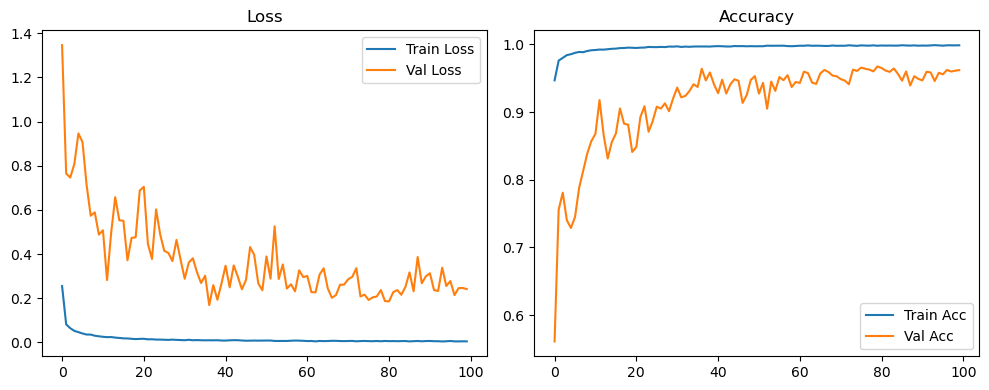

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4674, Acc: 0.8704 | Val Loss: 3.5952, Acc: 0.2016


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1736, Acc: 0.9491 | Val Loss: 3.2966, Acc: 0.2303


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1376, Acc: 0.9595 | Val Loss: 3.6748, Acc: 0.2347


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1219, Acc: 0.9638 | Val Loss: 2.8586, Acc: 0.2954


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1115, Acc: 0.9670 | Val Loss: 2.5625, Acc: 0.3474


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1017, Acc: 0.9693 | Val Loss: 2.8511, Acc: 0.3279


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0971, Acc: 0.9707 | Val Loss: 2.6815, Acc: 0.3360


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0926, Acc: 0.9717 | Val Loss: 2.4053, Acc: 0.3617


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9729 | Val Loss: 2.4798, Acc: 0.3762


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9741 | Val Loss: 2.7483, Acc: 0.3551


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0853, Acc: 0.9747 | Val Loss: 3.0665, Acc: 0.3317


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9752 | Val Loss: 2.0057, Acc: 0.4213


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9769 | Val Loss: 3.8766, Acc: 0.2642


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9766 | Val Loss: 3.2013, Acc: 0.3249


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9772 | Val Loss: 2.2969, Acc: 0.3997


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9784 | Val Loss: 2.7775, Acc: 0.3312


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9779 | Val Loss: 2.1043, Acc: 0.4377


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9800 | Val Loss: 2.3476, Acc: 0.3941


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9800 | Val Loss: 2.4094, Acc: 0.3720


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9804 | Val Loss: 2.9442, Acc: 0.3245


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9794 | Val Loss: 2.0192, Acc: 0.4674


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0645, Acc: 0.9803 | Val Loss: 1.5500, Acc: 0.5084


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9815 | Val Loss: 2.1337, Acc: 0.4168


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9815 | Val Loss: 2.1866, Acc: 0.4046


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 2.0776, Acc: 0.4255


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9827 | Val Loss: 2.6940, Acc: 0.3694


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 2.2373, Acc: 0.3951


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9822 | Val Loss: 1.7879, Acc: 0.4570


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9831 | Val Loss: 1.4079, Acc: 0.5643


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9834 | Val Loss: 2.1370, Acc: 0.4053


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 2.0596, Acc: 0.3743


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 1.8630, Acc: 0.4626


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9840 | Val Loss: 1.8789, Acc: 0.4607


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9836 | Val Loss: 1.5180, Acc: 0.5182


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9835 | Val Loss: 1.5419, Acc: 0.4833


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9847 | Val Loss: 1.4852, Acc: 0.4877


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9835 | Val Loss: 1.4847, Acc: 0.5105


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9841 | Val Loss: 1.2516, Acc: 0.5694


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 1.3808, Acc: 0.5586


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 1.2550, Acc: 0.5695


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9854 | Val Loss: 1.7357, Acc: 0.4272


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9853 | Val Loss: 1.0169, Acc: 0.6297


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9854 | Val Loss: 1.0866, Acc: 0.6173


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 1.2511, Acc: 0.5913


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9844 | Val Loss: 1.0999, Acc: 0.6009


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9859 | Val Loss: 0.9648, Acc: 0.6392


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9860 | Val Loss: 1.0073, Acc: 0.6123


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.9675, Acc: 0.6415


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9857 | Val Loss: 1.0836, Acc: 0.5540


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9856 | Val Loss: 1.0504, Acc: 0.5817


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9848 | Val Loss: 0.8384, Acc: 0.6723


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9853 | Val Loss: 0.9946, Acc: 0.5926


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 1.3722, Acc: 0.4966


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 1.1672, Acc: 0.5682


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9852 | Val Loss: 0.9008, Acc: 0.6456


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9853 | Val Loss: 0.9138, Acc: 0.6202


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.8366, Acc: 0.6597


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9855 | Val Loss: 0.6532, Acc: 0.7319


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.6984, Acc: 0.6946


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.7467, Acc: 0.6912


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.5834, Acc: 0.7565


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9863 | Val Loss: 0.6762, Acc: 0.7337


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.5784, Acc: 0.7702


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9871 | Val Loss: 0.4939, Acc: 0.8005


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.7717, Acc: 0.6855


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 0.7423, Acc: 0.7173


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.6840, Acc: 0.6922


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9865 | Val Loss: 0.7712, Acc: 0.6767


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.9271, Acc: 0.6082


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9870 | Val Loss: 0.7411, Acc: 0.7017


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9867 | Val Loss: 0.7393, Acc: 0.7071


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.7893, Acc: 0.6697


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9867 | Val Loss: 0.8244, Acc: 0.6913


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.7466, Acc: 0.7031


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9872 | Val Loss: 0.6378, Acc: 0.7535


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9879 | Val Loss: 0.6822, Acc: 0.7449


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9877 | Val Loss: 0.8298, Acc: 0.6439


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9872 | Val Loss: 0.8629, Acc: 0.6503


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.7665, Acc: 0.6883


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9876 | Val Loss: 0.6956, Acc: 0.7200


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9874 | Val Loss: 0.7136, Acc: 0.7059


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.6501, Acc: 0.7493


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 0.7315, Acc: 0.7299


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9879 | Val Loss: 0.6656, Acc: 0.7330


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9882 | Val Loss: 0.9240, Acc: 0.5710


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9875 | Val Loss: 0.7787, Acc: 0.6609


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.7207, Acc: 0.7153


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.8637, Acc: 0.6377


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.9676, Acc: 0.5941


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 1.1927, Acc: 0.5240


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.7683, Acc: 0.6679


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9883 | Val Loss: 0.7532, Acc: 0.6629


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9885 | Val Loss: 0.7269, Acc: 0.7093


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 0.8468, Acc: 0.5660


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.6901, Acc: 0.6747


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.7366, Acc: 0.6698


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.7108, Acc: 0.6833


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.7304, Acc: 0.6889


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.7769, Acc: 0.6533


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9886 | Val Loss: 0.8061, Acc: 0.6405


Final Test Loss: 0.7969 Accuracy: 0.6469


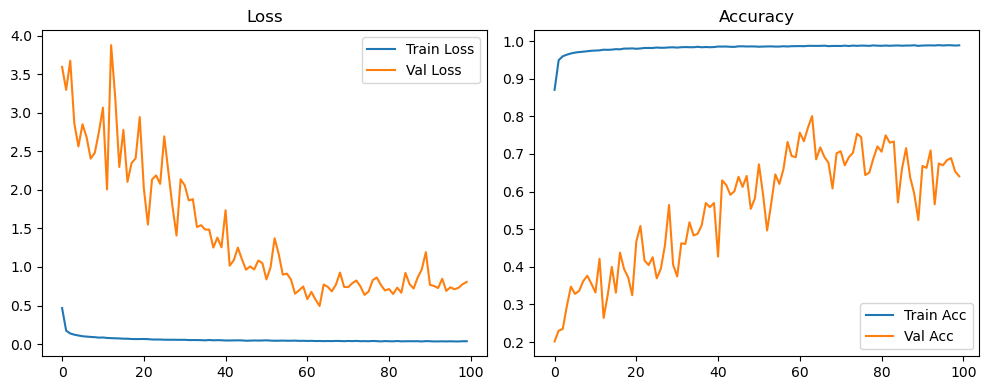

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2007, Acc: 0.9618 | Val Loss: 0.3899, Acc: 0.8842


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9843 | Val Loss: 0.1128, Acc: 0.9647


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9883 | Val Loss: 0.1292, Acc: 0.9612


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.0486, Acc: 0.9851


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0657, Acc: 0.9801


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.1038, Acc: 0.9687


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.0667, Acc: 0.9804


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0966, Acc: 0.9718


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1301, Acc: 0.9637


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0496, Acc: 0.9871


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.2328, Acc: 0.9393


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0599, Acc: 0.9836


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0589, Acc: 0.9853


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0494, Acc: 0.9876


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0632, Acc: 0.9844


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0525, Acc: 0.9878


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0759, Acc: 0.9812


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0510, Acc: 0.9875


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0647, Acc: 0.9848


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0534, Acc: 0.9876


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0580, Acc: 0.9855


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0485, Acc: 0.9889


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0726, Acc: 0.9832


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0802, Acc: 0.9822


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0599, Acc: 0.9868


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0534, Acc: 0.9888


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0614, Acc: 0.9870


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0581, Acc: 0.9862


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0512, Acc: 0.9887


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0668, Acc: 0.9867


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0538, Acc: 0.9891


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0660, Acc: 0.9867


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0546, Acc: 0.9882


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0546, Acc: 0.9883


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0524, Acc: 0.9892


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0644, Acc: 0.9875


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0569, Acc: 0.9880


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0657, Acc: 0.9875


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0661, Acc: 0.9885


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0568, Acc: 0.9903


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0662, Acc: 0.9877


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0605, Acc: 0.9887


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0587, Acc: 0.9888


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0654, Acc: 0.9880


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0642, Acc: 0.9883


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0633, Acc: 0.9888


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0598, Acc: 0.9896


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0689, Acc: 0.9884


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0579, Acc: 0.9888


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0625, Acc: 0.9882


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0598, Acc: 0.9899


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0574, Acc: 0.9898


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0562, Acc: 0.9901


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9903


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9907


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9906


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0558, Acc: 0.9903


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9905


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0583, Acc: 0.9905


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9903


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9902


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9908


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9904


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9897


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0670, Acc: 0.9894


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0640, Acc: 0.9904


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0608, Acc: 0.9901


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0628, Acc: 0.9896


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0634, Acc: 0.9897


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9898


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0749, Acc: 0.9878


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0704, Acc: 0.9892


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0661, Acc: 0.9902


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0649, Acc: 0.9907


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0661, Acc: 0.9896


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0675, Acc: 0.9888


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9897


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0654, Acc: 0.9900


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9900


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9898


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9896


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9902


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9900


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9898


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0658, Acc: 0.9898


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0675, Acc: 0.9892


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9893


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0683, Acc: 0.9898


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0707, Acc: 0.9897


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0701, Acc: 0.9898


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9899


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9891


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0687, Acc: 0.9897


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0676, Acc: 0.9901


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9903


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9906


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9907


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9902


Final Test Loss: 0.0620 Accuracy: 0.9898


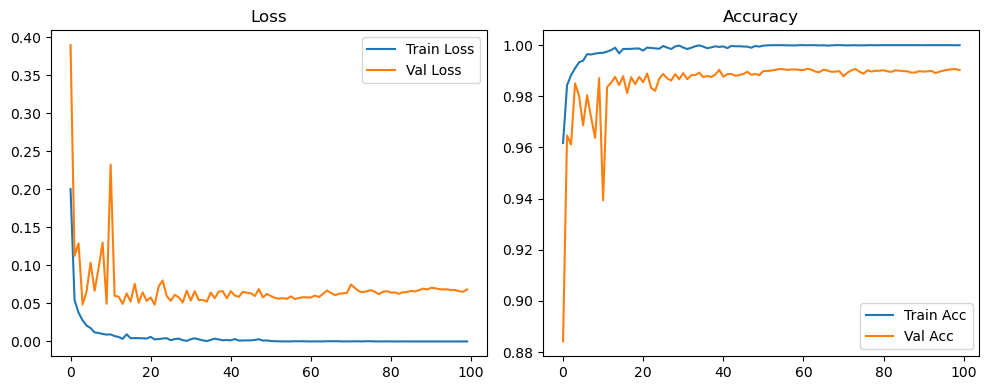

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2547, Acc: 0.9464 | Val Loss: 1.2958, Acc: 0.5577


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9759 | Val Loss: 0.7411, Acc: 0.7582


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9807 | Val Loss: 0.6674, Acc: 0.8098


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9835 | Val Loss: 0.8265, Acc: 0.7555


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9851 | Val Loss: 1.1927, Acc: 0.6773


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 1.1844, Acc: 0.7023


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.8997, Acc: 0.7597


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.5112, Acc: 0.8386


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.6174, Acc: 0.8327


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.4096, Acc: 0.8839


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.4676, Acc: 0.8769


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9913 | Val Loss: 0.2647, Acc: 0.9262


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.5668, Acc: 0.8526


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.5801, Acc: 0.8561


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.5561, Acc: 0.8695


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.5231, Acc: 0.8791


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.3507, Acc: 0.9186


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.5395, Acc: 0.8842


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.5138, Acc: 0.8768


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9946 | Val Loss: 0.4874, Acc: 0.8791


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.2943, Acc: 0.9282


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.2563, Acc: 0.9387


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.2251, Acc: 0.9425


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.3275, Acc: 0.9205


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.4039, Acc: 0.9087


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.2123, Acc: 0.9494


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.2472, Acc: 0.9425


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9958 | Val Loss: 0.1422, Acc: 0.9659


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.2563, Acc: 0.9407


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.3127, Acc: 0.9327


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.1438, Acc: 0.9668


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.3554, Acc: 0.9267


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1656, Acc: 0.9626


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1829, Acc: 0.9607


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1671, Acc: 0.9643


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1839, Acc: 0.9595


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1500, Acc: 0.9674


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1582, Acc: 0.9663


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1546, Acc: 0.9649


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1833, Acc: 0.9608


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1893, Acc: 0.9609


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.2440, Acc: 0.9533


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9964 | Val Loss: 0.2891, Acc: 0.9451


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1773, Acc: 0.9663


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1724, Acc: 0.9655


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.2051, Acc: 0.9603


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.2189, Acc: 0.9548


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1390, Acc: 0.9710


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9972 | Val Loss: 0.1971, Acc: 0.9601


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1356, Acc: 0.9723


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1830, Acc: 0.9647


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1719, Acc: 0.9674


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1872, Acc: 0.9639


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1655, Acc: 0.9677


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1973, Acc: 0.9646


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1316, Acc: 0.9752


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1522, Acc: 0.9716


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1415, Acc: 0.9734


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1946, Acc: 0.9633


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1810, Acc: 0.9667


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.1754, Acc: 0.9667


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1437, Acc: 0.9722


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1313, Acc: 0.9762


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1505, Acc: 0.9742


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1809, Acc: 0.9681


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2273, Acc: 0.9607


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1938, Acc: 0.9655


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2302, Acc: 0.9590


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1886, Acc: 0.9667


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1910, Acc: 0.9662


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.2171, Acc: 0.9618


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.2283, Acc: 0.9599


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2101, Acc: 0.9644


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1776, Acc: 0.9694


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1775, Acc: 0.9701


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1753, Acc: 0.9708


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.2035, Acc: 0.9647


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1909, Acc: 0.9672


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1803, Acc: 0.9691


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1891, Acc: 0.9667


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1908, Acc: 0.9663


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1586, Acc: 0.9722


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1744, Acc: 0.9695


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1599, Acc: 0.9731


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1725, Acc: 0.9698


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1903, Acc: 0.9667


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1470, Acc: 0.9747


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1694, Acc: 0.9702


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1863, Acc: 0.9684


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1650, Acc: 0.9703


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1686, Acc: 0.9712


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1620, Acc: 0.9726


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1941, Acc: 0.9680


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1827, Acc: 0.9692


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1637, Acc: 0.9726


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2001, Acc: 0.9681


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1953, Acc: 0.9671


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2167, Acc: 0.9644


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1739, Acc: 0.9718


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1738, Acc: 0.9717


Final Test Loss: 0.1976 Accuracy: 0.9689


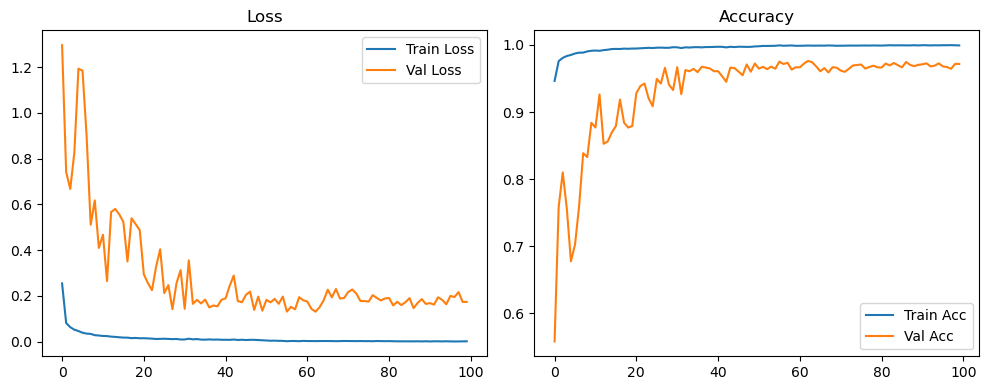

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4678, Acc: 0.8708 | Val Loss: 3.8310, Acc: 0.1840


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1737, Acc: 0.9489 | Val Loss: 3.5911, Acc: 0.2034


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1381, Acc: 0.9593 | Val Loss: 3.5896, Acc: 0.2278


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9639 | Val Loss: 2.7808, Acc: 0.3016


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9670 | Val Loss: 2.5923, Acc: 0.3347


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9692 | Val Loss: 2.6773, Acc: 0.3305


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9716 | Val Loss: 2.2135, Acc: 0.3870


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9721 | Val Loss: 2.0393, Acc: 0.4142


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0884, Acc: 0.9731 | Val Loss: 2.0225, Acc: 0.4355


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9752 | Val Loss: 2.4435, Acc: 0.3819


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 2.4607, Acc: 0.3903


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9756 | Val Loss: 1.2873, Acc: 0.5804


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9779 | Val Loss: 3.1706, Acc: 0.2928


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9777 | Val Loss: 2.4745, Acc: 0.3859


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9782 | Val Loss: 1.6953, Acc: 0.5009


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9791 | Val Loss: 2.4696, Acc: 0.3388


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9793 | Val Loss: 2.1311, Acc: 0.4442


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9807 | Val Loss: 1.8519, Acc: 0.4632


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9803 | Val Loss: 1.4576, Acc: 0.5396


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9804 | Val Loss: 1.5789, Acc: 0.5064


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9795 | Val Loss: 1.9103, Acc: 0.4723


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9809 | Val Loss: 1.1542, Acc: 0.5899


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9817 | Val Loss: 1.7081, Acc: 0.4784


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9824 | Val Loss: 1.9152, Acc: 0.4430


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9821 | Val Loss: 1.7018, Acc: 0.4842


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9831 | Val Loss: 1.9850, Acc: 0.4059


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9829 | Val Loss: 1.5749, Acc: 0.5070


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9830 | Val Loss: 1.3150, Acc: 0.5218


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9834 | Val Loss: 1.1017, Acc: 0.6188


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9822 | Val Loss: 1.5320, Acc: 0.4764


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9835 | Val Loss: 1.1412, Acc: 0.5629


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 1.1530, Acc: 0.5981


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9842 | Val Loss: 1.4401, Acc: 0.5132


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9847 | Val Loss: 0.9725, Acc: 0.6364


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 1.1069, Acc: 0.5581


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9850 | Val Loss: 1.0524, Acc: 0.5463


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 1.0654, Acc: 0.5897


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.8800, Acc: 0.6773


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9851 | Val Loss: 0.9484, Acc: 0.6288


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.9522, Acc: 0.6140


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9857 | Val Loss: 1.0276, Acc: 0.5851


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.8858, Acc: 0.6509


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9851 | Val Loss: 0.7883, Acc: 0.6858


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9861 | Val Loss: 0.9497, Acc: 0.6096


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 0.8620, Acc: 0.6614


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9860 | Val Loss: 0.9269, Acc: 0.6497


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9856 | Val Loss: 0.8555, Acc: 0.6593


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9853 | Val Loss: 0.7998, Acc: 0.6730


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9861 | Val Loss: 0.8735, Acc: 0.6374


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.7532, Acc: 0.6690


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 0.7389, Acc: 0.6807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.6940, Acc: 0.6903


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9893 | Val Loss: 0.8647, Acc: 0.6212


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.7016, Acc: 0.6937


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9881 | Val Loss: 0.6923, Acc: 0.7204


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.6152, Acc: 0.7430


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9891 | Val Loss: 0.7452, Acc: 0.6692


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.5810, Acc: 0.7652


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.6963, Acc: 0.6941


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.6372, Acc: 0.7336


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.6233, Acc: 0.7345


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.6253, Acc: 0.7434


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.5791, Acc: 0.7630


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.5210, Acc: 0.7917


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.6626, Acc: 0.7062


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.6075, Acc: 0.7380


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.6057, Acc: 0.7142


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.5937, Acc: 0.7634


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.6753, Acc: 0.6947


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.5607, Acc: 0.7752


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.5673, Acc: 0.7717


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.5920, Acc: 0.7608


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.5498, Acc: 0.7817


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.5794, Acc: 0.7478


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.5735, Acc: 0.7807


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.5380, Acc: 0.7954


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 0.6167, Acc: 0.7474


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9895 | Val Loss: 0.6185, Acc: 0.7467


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.5955, Acc: 0.7548


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.6210, Acc: 0.7465


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.5955, Acc: 0.7690


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.6024, Acc: 0.7536


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.5800, Acc: 0.7762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.6078, Acc: 0.7655


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.6377, Acc: 0.7411


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.6304, Acc: 0.7322


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9906 | Val Loss: 0.6021, Acc: 0.7628


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9910 | Val Loss: 0.5897, Acc: 0.7741


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.5976, Acc: 0.7741


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9909 | Val Loss: 0.6075, Acc: 0.7689


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.6173, Acc: 0.7659


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.6069, Acc: 0.7692


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.5899, Acc: 0.7973


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.6613, Acc: 0.7341


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.6644, Acc: 0.7223


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.6272, Acc: 0.7709


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.6229, Acc: 0.7777


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.5905, Acc: 0.7863


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.6329, Acc: 0.7678


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.6114, Acc: 0.7748


Final Test Loss: 0.6038 Accuracy: 0.7848


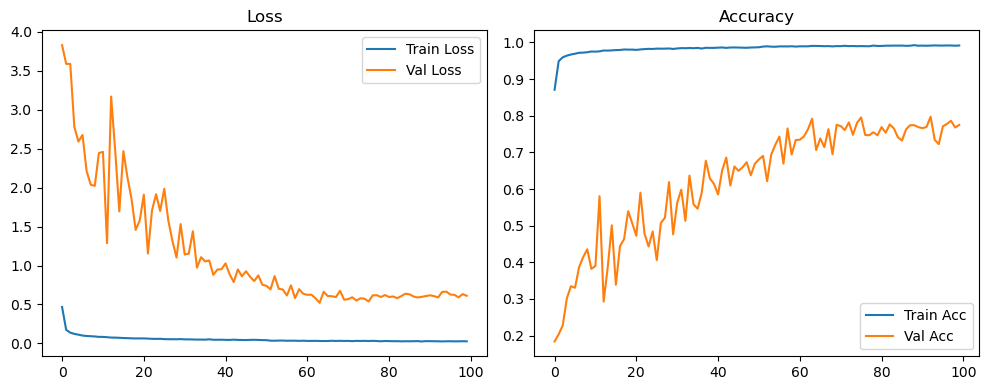

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3126, Acc: 0.9626 | Val Loss: 0.1293, Acc: 0.9714


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9852 | Val Loss: 0.4055, Acc: 0.8610


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9887 | Val Loss: 0.2039, Acc: 0.9400


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9925 | Val Loss: 0.1525, Acc: 0.9542


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9941 | Val Loss: 0.0805, Acc: 0.9762


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1326, Acc: 0.9592


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9966 | Val Loss: 0.1181, Acc: 0.9631


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.0603, Acc: 0.9831


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1235, Acc: 0.9603


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0822, Acc: 0.9765


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0726, Acc: 0.9806


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0462, Acc: 0.9880


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0535, Acc: 0.9866


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0554, Acc: 0.9859


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1346, Acc: 0.9631


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0571, Acc: 0.9846


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0645, Acc: 0.9830


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0544, Acc: 0.9858


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0661, Acc: 0.9839


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0597, Acc: 0.9837


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0429, Acc: 0.9881


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0499, Acc: 0.9870


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0904, Acc: 0.9792


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1246, Acc: 0.9718


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0509, Acc: 0.9884


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0708, Acc: 0.9832


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0589, Acc: 0.9868


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0796, Acc: 0.9821


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0904, Acc: 0.9759


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0557, Acc: 0.9871


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0519, Acc: 0.9889


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0524, Acc: 0.9886


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0688, Acc: 0.9842


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0524, Acc: 0.9876


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0535, Acc: 0.9887


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0477, Acc: 0.9889


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0581, Acc: 0.9862


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0711, Acc: 0.9852


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0514, Acc: 0.9898


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0551, Acc: 0.9879


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0538, Acc: 0.9884


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0760, Acc: 0.9829


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0656, Acc: 0.9852


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0525, Acc: 0.9888


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1259, Acc: 0.9727


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0515, Acc: 0.9881


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0644, Acc: 0.9864


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0554, Acc: 0.9875


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0653, Acc: 0.9862


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0529, Acc: 0.9876


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0475, Acc: 0.9900


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9900


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0599, Acc: 0.9870


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0572, Acc: 0.9880


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0499, Acc: 0.9900


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9889


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0584, Acc: 0.9886


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9898


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0519, Acc: 0.9888


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0564, Acc: 0.9882


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0654, Acc: 0.9877


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0543, Acc: 0.9889


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0553, Acc: 0.9890


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0553, Acc: 0.9893


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0499, Acc: 0.9909


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9905


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0808, Acc: 0.9841


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0600, Acc: 0.9880


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0559, Acc: 0.9895


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0528, Acc: 0.9898


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0589, Acc: 0.9892


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0727, Acc: 0.9856


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0690, Acc: 0.9873


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0580, Acc: 0.9878


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0827, Acc: 0.9850


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0601, Acc: 0.9878


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0647, Acc: 0.9877


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0766, Acc: 0.9866


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9894


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0595, Acc: 0.9884


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0662, Acc: 0.9878


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0834, Acc: 0.9840


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0547, Acc: 0.9898


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0653, Acc: 0.9878


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0636, Acc: 0.9879


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0613, Acc: 0.9879


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0615, Acc: 0.9877


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0697, Acc: 0.9878


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0644, Acc: 0.9884


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0636, Acc: 0.9883


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9890


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0608, Acc: 0.9886


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0723, Acc: 0.9869


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0645, Acc: 0.9883


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0655, Acc: 0.9886


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0652, Acc: 0.9886


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0654, Acc: 0.9882


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9884


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1017, Acc: 0.9819


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0645, Acc: 0.9887


Final Test Loss: 0.0621 Accuracy: 0.9878


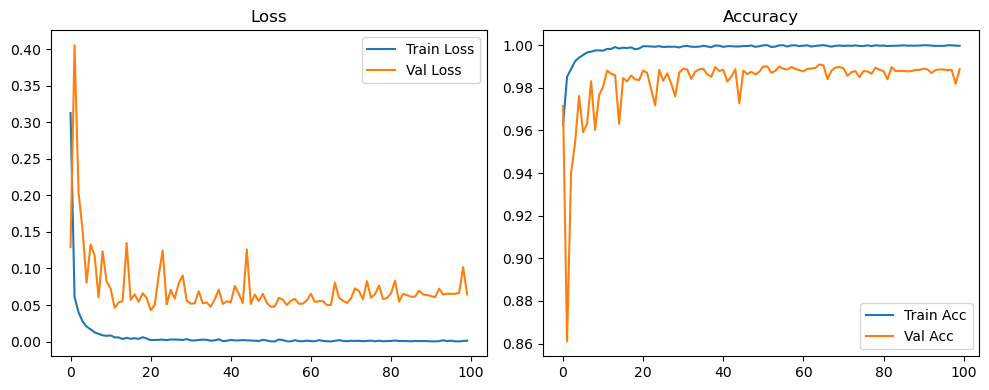

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3905, Acc: 0.9414 | Val Loss: 1.6060, Acc: 0.3792


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0955, Acc: 0.9749 | Val Loss: 0.9765, Acc: 0.6776


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0703, Acc: 0.9797 | Val Loss: 1.0601, Acc: 0.6677


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9823 | Val Loss: 1.2530, Acc: 0.6053


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9844 | Val Loss: 1.2857, Acc: 0.6137


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 1.4240, Acc: 0.6224


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.9039, Acc: 0.7318


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 1.0845, Acc: 0.6743


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.7026, Acc: 0.7881


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.6915, Acc: 0.8149


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.8210, Acc: 0.7922


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.9319, Acc: 0.7752


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.9848, Acc: 0.7665


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.6789, Acc: 0.8198


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.7216, Acc: 0.8059


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.5496, Acc: 0.8596


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.6715, Acc: 0.8251


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.6048, Acc: 0.8383


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.6099, Acc: 0.8348


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.6238, Acc: 0.8339


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.7155, Acc: 0.8297


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.4316, Acc: 0.8831


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.2977, Acc: 0.9178


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.7091, Acc: 0.8382


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.8193, Acc: 0.8147


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.4383, Acc: 0.8959


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.4033, Acc: 0.8925


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.2965, Acc: 0.9220


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.3958, Acc: 0.9003


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.5115, Acc: 0.8750


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.3882, Acc: 0.8991


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.4433, Acc: 0.8830


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.5171, Acc: 0.8768


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.5024, Acc: 0.8782


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.3293, Acc: 0.9198


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.3329, Acc: 0.9183


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.2882, Acc: 0.9306


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.2627, Acc: 0.9368


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.2956, Acc: 0.9293


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.2012, Acc: 0.9516


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.3155, Acc: 0.9273


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.2870, Acc: 0.9297


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.3034, Acc: 0.9293


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.4247, Acc: 0.9068


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.3057, Acc: 0.9307


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.3257, Acc: 0.9259


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.3502, Acc: 0.9251


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.2700, Acc: 0.9375


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.3463, Acc: 0.9259


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.2695, Acc: 0.9390


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.2864, Acc: 0.9340


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.3289, Acc: 0.9245


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.4460, Acc: 0.9070


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.2443, Acc: 0.9453


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.4203, Acc: 0.9131


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.2767, Acc: 0.9388


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.3330, Acc: 0.9263


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.2389, Acc: 0.9460


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.2835, Acc: 0.9370


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.2733, Acc: 0.9387


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.2149, Acc: 0.9519


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.2052, Acc: 0.9547


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2340, Acc: 0.9508


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.2429, Acc: 0.9477


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.2445, Acc: 0.9479


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.2516, Acc: 0.9464


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.2313, Acc: 0.9478


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.3489, Acc: 0.9291


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.2247, Acc: 0.9522


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.2733, Acc: 0.9435


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.2536, Acc: 0.9465


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.3236, Acc: 0.9333


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.3588, Acc: 0.9250


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.2079, Acc: 0.9559


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1785, Acc: 0.9637


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9980 | Val Loss: 0.1894, Acc: 0.9612


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.2527, Acc: 0.9492


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.2307, Acc: 0.9547


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.2386, Acc: 0.9528


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.2502, Acc: 0.9501


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.2119, Acc: 0.9567


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1814, Acc: 0.9632


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2482, Acc: 0.9529


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.2154, Acc: 0.9566


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.2381, Acc: 0.9513


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.2726, Acc: 0.9481


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1646, Acc: 0.9676


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1699, Acc: 0.9664


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1591, Acc: 0.9694


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1467, Acc: 0.9715


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1670, Acc: 0.9693


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1448, Acc: 0.9726


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1488, Acc: 0.9702


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.2282, Acc: 0.9575


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1558, Acc: 0.9707


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1801, Acc: 0.9670


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1804, Acc: 0.9657


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.2070, Acc: 0.9616


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1604, Acc: 0.9706


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2283, Acc: 0.9594


Final Test Loss: 0.2462 Accuracy: 0.9550


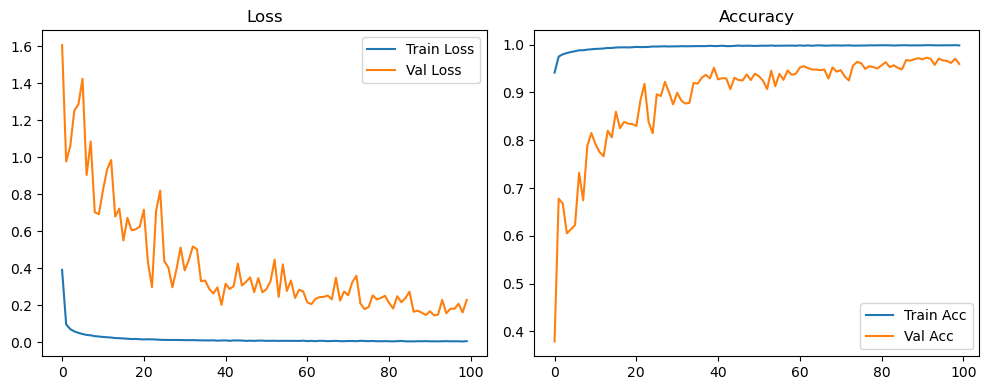

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6827, Acc: 0.8293 | Val Loss: 3.4018, Acc: 0.1888


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2242, Acc: 0.9384 | Val Loss: 3.4140, Acc: 0.2096


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1664, Acc: 0.9511 | Val Loss: 3.8106, Acc: 0.2128


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1402, Acc: 0.9593 | Val Loss: 3.0824, Acc: 0.2321


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1262, Acc: 0.9641 | Val Loss: 3.1595, Acc: 0.2519


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1131, Acc: 0.9666 | Val Loss: 3.2223, Acc: 0.2659


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1040, Acc: 0.9694 | Val Loss: 3.3914, Acc: 0.2682


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1002, Acc: 0.9696 | Val Loss: 3.0184, Acc: 0.2649


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0953, Acc: 0.9718 | Val Loss: 3.3195, Acc: 0.2488


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0910, Acc: 0.9731 | Val Loss: 3.2993, Acc: 0.2746


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0902, Acc: 0.9729 | Val Loss: 2.8750, Acc: 0.3278


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0835, Acc: 0.9754 | Val Loss: 2.4677, Acc: 0.3439


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9745 | Val Loss: 3.2088, Acc: 0.3049


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0804, Acc: 0.9760 | Val Loss: 2.6422, Acc: 0.3501


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9769 | Val Loss: 2.5751, Acc: 0.3513


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9773 | Val Loss: 3.2940, Acc: 0.2604


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9777 | Val Loss: 2.5371, Acc: 0.3524


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9786 | Val Loss: 2.5530, Acc: 0.3410


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9792 | Val Loss: 2.7261, Acc: 0.3256


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9806 | Val Loss: 2.4959, Acc: 0.3503


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9788 | Val Loss: 2.5710, Acc: 0.3733


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0636, Acc: 0.9810 | Val Loss: 2.1725, Acc: 0.4257


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0641, Acc: 0.9802 | Val Loss: 1.9278, Acc: 0.4617


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9807 | Val Loss: 2.4050, Acc: 0.3742


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9800 | Val Loss: 2.0525, Acc: 0.4330


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9813 | Val Loss: 2.7271, Acc: 0.3477


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9812 | Val Loss: 2.0183, Acc: 0.4527


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9810 | Val Loss: 1.8097, Acc: 0.4764


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9820 | Val Loss: 1.4960, Acc: 0.5625


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9818 | Val Loss: 2.5824, Acc: 0.3701


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9816 | Val Loss: 1.9795, Acc: 0.4403


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9817 | Val Loss: 1.9956, Acc: 0.4403


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9825 | Val Loss: 2.0336, Acc: 0.4306


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9834 | Val Loss: 1.7588, Acc: 0.4798


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9837 | Val Loss: 1.3231, Acc: 0.5771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9832 | Val Loss: 1.8524, Acc: 0.4736


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9822 | Val Loss: 1.2895, Acc: 0.6082


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9841 | Val Loss: 1.8073, Acc: 0.4728


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 1.3145, Acc: 0.5913


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9832 | Val Loss: 1.8574, Acc: 0.4773


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9844 | Val Loss: 1.7640, Acc: 0.4819


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9845 | Val Loss: 1.3199, Acc: 0.5794


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9834 | Val Loss: 1.3978, Acc: 0.5534


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9834 | Val Loss: 1.3190, Acc: 0.5833


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9846 | Val Loss: 1.3651, Acc: 0.5845


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9842 | Val Loss: 1.1978, Acc: 0.6063


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9840 | Val Loss: 1.2901, Acc: 0.6036


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 1.1249, Acc: 0.6163


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 1.4854, Acc: 0.5305


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9851 | Val Loss: 1.5436, Acc: 0.5233


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9847 | Val Loss: 1.3391, Acc: 0.6007


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 1.2547, Acc: 0.5940


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9849 | Val Loss: 1.1279, Acc: 0.6156


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9855 | Val Loss: 1.1940, Acc: 0.5788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9846 | Val Loss: 1.0630, Acc: 0.6501


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9854 | Val Loss: 0.8710, Acc: 0.6672


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 1.2270, Acc: 0.5761


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 1.1218, Acc: 0.6203


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 1.0615, Acc: 0.6136


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9854 | Val Loss: 0.9636, Acc: 0.6674


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 0.8920, Acc: 0.6850


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 1.0052, Acc: 0.6486


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9867 | Val Loss: 0.8910, Acc: 0.6868


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9869 | Val Loss: 0.6968, Acc: 0.7488


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9874 | Val Loss: 0.8307, Acc: 0.7212


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.8738, Acc: 0.7097


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.7691, Acc: 0.7014


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9858 | Val Loss: 0.8096, Acc: 0.6807


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.8705, Acc: 0.6937


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.8238, Acc: 0.7062


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.6555, Acc: 0.7469


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.8669, Acc: 0.6887


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.9146, Acc: 0.6524


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9868 | Val Loss: 0.9536, Acc: 0.6217


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.8851, Acc: 0.6606


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 0.6251, Acc: 0.7823


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9866 | Val Loss: 0.7901, Acc: 0.6893


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.7640, Acc: 0.7262


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.6674, Acc: 0.7455


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9881 | Val Loss: 0.6918, Acc: 0.7101


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9863 | Val Loss: 0.7742, Acc: 0.6956


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9870 | Val Loss: 0.6881, Acc: 0.7342


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9868 | Val Loss: 0.8608, Acc: 0.6762


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9881 | Val Loss: 0.7279, Acc: 0.7229


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.7176, Acc: 0.7080


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.7150, Acc: 0.6990


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9862 | Val Loss: 0.5926, Acc: 0.7591


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.5708, Acc: 0.7649


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.5803, Acc: 0.7842


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.6536, Acc: 0.7443


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.6132, Acc: 0.7575


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.5805, Acc: 0.7652


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.5245, Acc: 0.7879


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.6393, Acc: 0.7326


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9876 | Val Loss: 0.6009, Acc: 0.7563


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.6040, Acc: 0.7502


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.6076, Acc: 0.7572


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9872 | Val Loss: 0.5992, Acc: 0.7473


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.4789, Acc: 0.8073


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9878 | Val Loss: 0.5541, Acc: 0.7769


Final Test Loss: 0.5387 Accuracy: 0.7856


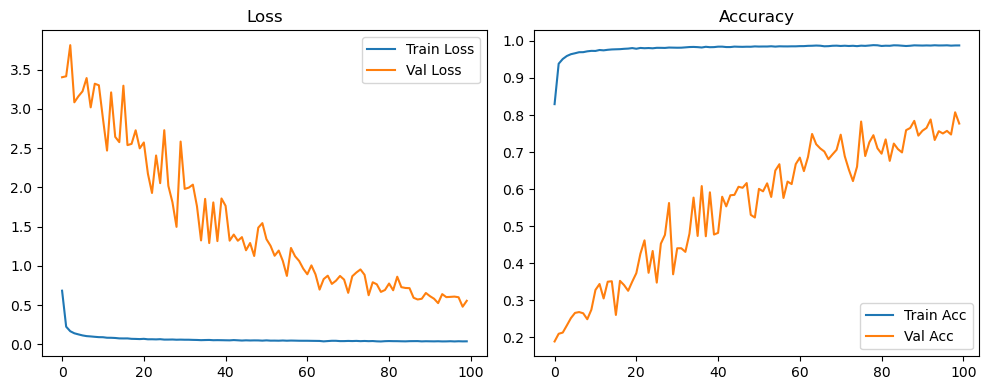

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4796, Acc: 0.9595 | Val Loss: 0.1494, Acc: 0.9758


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9850 | Val Loss: 0.1707, Acc: 0.9606


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9895 | Val Loss: 0.1416, Acc: 0.9632


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9920 | Val Loss: 0.0935, Acc: 0.9746


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9944 | Val Loss: 0.0838, Acc: 0.9733


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9959 | Val Loss: 0.1030, Acc: 0.9691


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9968 | Val Loss: 0.2128, Acc: 0.9371


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9974 | Val Loss: 0.0853, Acc: 0.9732


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9973 | Val Loss: 0.0674, Acc: 0.9812


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9985 | Val Loss: 0.0588, Acc: 0.9820


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0672, Acc: 0.9790


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.0594, Acc: 0.9824


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.0533, Acc: 0.9851


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0777, Acc: 0.9767


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0714, Acc: 0.9802


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0640, Acc: 0.9826


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9997 | Val Loss: 0.0508, Acc: 0.9866


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0595, Acc: 0.9840


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0459, Acc: 0.9872


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0655, Acc: 0.9826


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0900, Acc: 0.9766


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0516, Acc: 0.9858


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0675, Acc: 0.9836


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0587, Acc: 0.9864


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0705, Acc: 0.9826


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0528, Acc: 0.9884


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0467, Acc: 0.9887


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0511, Acc: 0.9880


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0664, Acc: 0.9823


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0581, Acc: 0.9865


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9896


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0536, Acc: 0.9879


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0847, Acc: 0.9805


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0462, Acc: 0.9885


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0475, Acc: 0.9888


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0489, Acc: 0.9869


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0499, Acc: 0.9869


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9902


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0711, Acc: 0.9831


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0559, Acc: 0.9868


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0514, Acc: 0.9888


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0839, Acc: 0.9788


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0508, Acc: 0.9889


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0759, Acc: 0.9822


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0666, Acc: 0.9842


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0496, Acc: 0.9886


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0715, Acc: 0.9844


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0677, Acc: 0.9850


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0562, Acc: 0.9870


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0481, Acc: 0.9888


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0488, Acc: 0.9889


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0676, Acc: 0.9828


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0577, Acc: 0.9862


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0489, Acc: 0.9891


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9891


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9900


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9898


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0688, Acc: 0.9852


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0497, Acc: 0.9887


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0471, Acc: 0.9911


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9902


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9905


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0483, Acc: 0.9895


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0545, Acc: 0.9888


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0514, Acc: 0.9899


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0480, Acc: 0.9893


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0491, Acc: 0.9898


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0602, Acc: 0.9867


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0566, Acc: 0.9876


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0545, Acc: 0.9879


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9876


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0628, Acc: 0.9860


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0551, Acc: 0.9886


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9886


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9890


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9892


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0955, Acc: 0.9828


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0598, Acc: 0.9871


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0536, Acc: 0.9883


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9889


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9895


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0615, Acc: 0.9870


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0530, Acc: 0.9872


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0527, Acc: 0.9893


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9900


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9898


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0830, Acc: 0.9832


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0568, Acc: 0.9873


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0607, Acc: 0.9875


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0549, Acc: 0.9878


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9884


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9897


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0656, Acc: 0.9868


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0518, Acc: 0.9896


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0629, Acc: 0.9876


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0604, Acc: 0.9880


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0569, Acc: 0.9885


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0597, Acc: 0.9880


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0554, Acc: 0.9888


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9897


Final Test Loss: 0.0555 Accuracy: 0.9890


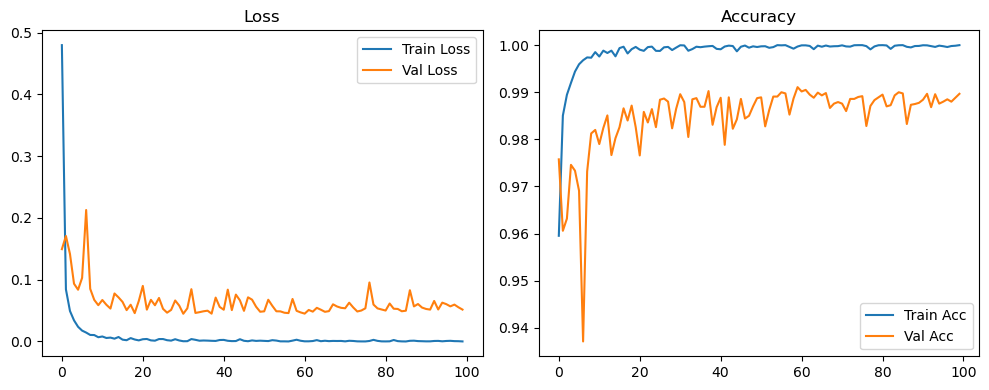

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5842, Acc: 0.9306 | Val Loss: 1.8414, Acc: 0.2735


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1335, Acc: 0.9726 | Val Loss: 1.7679, Acc: 0.3581


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0882, Acc: 0.9776 | Val Loss: 1.9644, Acc: 0.4128


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0693, Acc: 0.9814 | Val Loss: 1.8964, Acc: 0.4039


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0588, Acc: 0.9830 | Val Loss: 1.9499, Acc: 0.3749


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9848 | Val Loss: 1.8697, Acc: 0.4624


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9868 | Val Loss: 1.6609, Acc: 0.5252


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 2.3935, Acc: 0.3951


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9888 | Val Loss: 1.2036, Acc: 0.6583


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9890 | Val Loss: 1.7905, Acc: 0.5793


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 1.6687, Acc: 0.5627


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 1.2382, Acc: 0.6735


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 1.7697, Acc: 0.6208


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 1.6829, Acc: 0.5988


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 1.8198, Acc: 0.6261


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 1.3454, Acc: 0.6751


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 1.3347, Acc: 0.6481


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 1.0496, Acc: 0.7392


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 1.3100, Acc: 0.6763


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 1.3334, Acc: 0.6755


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 1.5702, Acc: 0.6543


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 1.6081, Acc: 0.6315


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.6936, Acc: 0.8199


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 1.0887, Acc: 0.7573


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 1.2226, Acc: 0.7325


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 1.1869, Acc: 0.7431


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.8189, Acc: 0.8122


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.8590, Acc: 0.7839


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 1.1356, Acc: 0.7480


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 1.0355, Acc: 0.7507


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.8563, Acc: 0.7978


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 1.2536, Acc: 0.7073


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 1.1862, Acc: 0.7492


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 1.0365, Acc: 0.7785


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 1.3405, Acc: 0.7144


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 1.0106, Acc: 0.7860


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 1.1122, Acc: 0.7572


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 1.5334, Acc: 0.7013


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.9887, Acc: 0.7957


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 1.0676, Acc: 0.7923


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 1.2822, Acc: 0.7279


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 1.0340, Acc: 0.7761


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.9867, Acc: 0.8059


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 1.0697, Acc: 0.7880


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.8368, Acc: 0.8247


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.9789, Acc: 0.7894


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 1.5394, Acc: 0.7227


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 1.0086, Acc: 0.8005


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 1.1502, Acc: 0.7765


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.6846, Acc: 0.8639


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.8076, Acc: 0.8322


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.8322, Acc: 0.8123


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 1.0011, Acc: 0.7887


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.5981, Acc: 0.8614


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 1.0750, Acc: 0.7931


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.5891, Acc: 0.8725


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.6373, Acc: 0.8635


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.7364, Acc: 0.8454


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.7741, Acc: 0.8303


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.7372, Acc: 0.8487


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.6362, Acc: 0.8748


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.6572, Acc: 0.8704


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.4374, Acc: 0.9013


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.5807, Acc: 0.8748


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.5273, Acc: 0.8798


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.6552, Acc: 0.8689


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.7465, Acc: 0.8472


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.6123, Acc: 0.8738


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.6602, Acc: 0.8498


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.6103, Acc: 0.8664


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.6761, Acc: 0.8631


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.6434, Acc: 0.8692


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.6474, Acc: 0.8610


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.5941, Acc: 0.8713


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.6787, Acc: 0.8463


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.6546, Acc: 0.8778


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.5171, Acc: 0.8886


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.4393, Acc: 0.9080


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.5795, Acc: 0.8779


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.5839, Acc: 0.8740


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.5711, Acc: 0.8822


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.6239, Acc: 0.8721


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.6847, Acc: 0.8586


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.7096, Acc: 0.8623


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.5862, Acc: 0.8781


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.6835, Acc: 0.8584


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.5590, Acc: 0.8858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.8151, Acc: 0.8395


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.6210, Acc: 0.8689


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.6232, Acc: 0.8751


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.5104, Acc: 0.8919


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.5050, Acc: 0.8929


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.6518, Acc: 0.8675


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.6577, Acc: 0.8732


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.5998, Acc: 0.8788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.6123, Acc: 0.8776


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.7290, Acc: 0.8592


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.6210, Acc: 0.8762


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.4674, Acc: 0.9000


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.3964, Acc: 0.9170


Final Test Loss: 0.3952 Accuracy: 0.9209


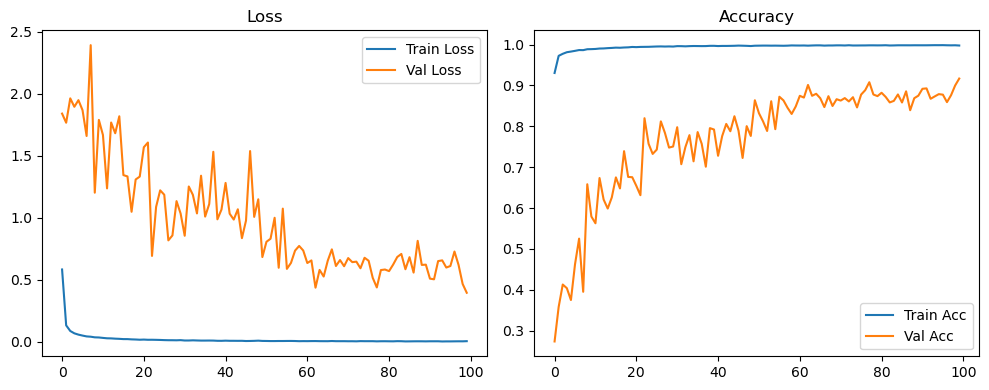

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9385, Acc: 0.7824 | Val Loss: 3.4724, Acc: 0.1167


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3284, Acc: 0.9193 | Val Loss: 3.1724, Acc: 0.2108


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2234, Acc: 0.9390 | Val Loss: 3.7021, Acc: 0.2120


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1772, Acc: 0.9503 | Val Loss: 3.2425, Acc: 0.2137


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1536, Acc: 0.9568 | Val Loss: 3.3981, Acc: 0.2133


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1362, Acc: 0.9605 | Val Loss: 3.3570, Acc: 0.2258


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1239, Acc: 0.9634 | Val Loss: 3.5878, Acc: 0.2160


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1172, Acc: 0.9656 | Val Loss: 3.0998, Acc: 0.2387


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1093, Acc: 0.9677 | Val Loss: 3.1606, Acc: 0.2312


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1024, Acc: 0.9691 | Val Loss: 2.9748, Acc: 0.2644


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1010, Acc: 0.9695 | Val Loss: 2.6386, Acc: 0.3196


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0939, Acc: 0.9716 | Val Loss: 2.4882, Acc: 0.3187


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0942, Acc: 0.9716 | Val Loss: 3.0625, Acc: 0.3240


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0899, Acc: 0.9738 | Val Loss: 2.7644, Acc: 0.3215


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0866, Acc: 0.9740 | Val Loss: 2.2350, Acc: 0.3897


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0845, Acc: 0.9752 | Val Loss: 2.4112, Acc: 0.3557


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0824, Acc: 0.9754 | Val Loss: 2.2976, Acc: 0.3760


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0784, Acc: 0.9756 | Val Loss: 2.1691, Acc: 0.4054


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0770, Acc: 0.9765 | Val Loss: 2.5968, Acc: 0.3393


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0732, Acc: 0.9781 | Val Loss: 2.6470, Acc: 0.3379


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9769 | Val Loss: 2.8227, Acc: 0.3173


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0697, Acc: 0.9790 | Val Loss: 2.5903, Acc: 0.3667


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0690, Acc: 0.9791 | Val Loss: 2.6376, Acc: 0.3442


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0695, Acc: 0.9787 | Val Loss: 2.6596, Acc: 0.3577


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0699, Acc: 0.9794 | Val Loss: 2.6094, Acc: 0.3757


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9794 | Val Loss: 2.3388, Acc: 0.3805


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0668, Acc: 0.9799 | Val Loss: 2.0091, Acc: 0.4554


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9799 | Val Loss: 2.2088, Acc: 0.4052


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9799 | Val Loss: 1.9161, Acc: 0.4788


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9795 | Val Loss: 2.4830, Acc: 0.3882


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0617, Acc: 0.9805 | Val Loss: 2.4509, Acc: 0.3873


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9805 | Val Loss: 2.5162, Acc: 0.3872


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9812 | Val Loss: 2.2807, Acc: 0.4058


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9814 | Val Loss: 2.2151, Acc: 0.4271


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0586, Acc: 0.9826 | Val Loss: 2.1706, Acc: 0.4267


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0586, Acc: 0.9815 | Val Loss: 2.5377, Acc: 0.3518


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0596, Acc: 0.9821 | Val Loss: 2.1520, Acc: 0.4354


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0581, Acc: 0.9818 | Val Loss: 2.4503, Acc: 0.3852


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0567, Acc: 0.9827 | Val Loss: 2.0516, Acc: 0.4645


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9823 | Val Loss: 2.0506, Acc: 0.4693


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 2.1282, Acc: 0.4368


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9834 | Val Loss: 2.3023, Acc: 0.4106


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0555, Acc: 0.9826 | Val Loss: 1.9221, Acc: 0.4785


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9828 | Val Loss: 2.0053, Acc: 0.4744


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 1.7927, Acc: 0.5053


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0527, Acc: 0.9838 | Val Loss: 1.7495, Acc: 0.5312


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 1.8170, Acc: 0.5093


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9834 | Val Loss: 1.7969, Acc: 0.5210


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9840 | Val Loss: 2.1096, Acc: 0.4713


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9840 | Val Loss: 1.9428, Acc: 0.4962


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9840 | Val Loss: 1.9315, Acc: 0.5042


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9841 | Val Loss: 1.7912, Acc: 0.5363


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9843 | Val Loss: 2.0171, Acc: 0.4813


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 1.8278, Acc: 0.5147


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9836 | Val Loss: 1.9804, Acc: 0.5030


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9842 | Val Loss: 1.7539, Acc: 0.5228


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9851 | Val Loss: 1.8643, Acc: 0.5144


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9841 | Val Loss: 1.7011, Acc: 0.5546


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 1.9055, Acc: 0.4959


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9850 | Val Loss: 2.0756, Acc: 0.4743


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9849 | Val Loss: 1.8320, Acc: 0.5110


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 1.5090, Acc: 0.5714


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 1.3929, Acc: 0.6067


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9846 | Val Loss: 1.3743, Acc: 0.6234


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 1.7654, Acc: 0.5367


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 1.5106, Acc: 0.6085


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9847 | Val Loss: 1.5359, Acc: 0.5682


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9857 | Val Loss: 1.8676, Acc: 0.5410


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 1.6270, Acc: 0.5527


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 1.5713, Acc: 0.6028


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9851 | Val Loss: 1.4993, Acc: 0.5733


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 1.7195, Acc: 0.5508


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9856 | Val Loss: 1.6596, Acc: 0.5356


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9847 | Val Loss: 1.6248, Acc: 0.5217


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9857 | Val Loss: 1.4577, Acc: 0.5936


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9855 | Val Loss: 1.2616, Acc: 0.6512


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 1.6687, Acc: 0.5378


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9869 | Val Loss: 1.4835, Acc: 0.5926


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 1.4469, Acc: 0.5877


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 1.2390, Acc: 0.6123


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9861 | Val Loss: 1.3975, Acc: 0.5921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9870 | Val Loss: 1.2350, Acc: 0.6294


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 1.2723, Acc: 0.6172


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 1.3535, Acc: 0.5975


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9873 | Val Loss: 1.3890, Acc: 0.5779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 1.5261, Acc: 0.5613


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 1.2303, Acc: 0.6185


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9874 | Val Loss: 1.2538, Acc: 0.6156


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 1.3982, Acc: 0.5980


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9873 | Val Loss: 1.2458, Acc: 0.6207


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9862 | Val Loss: 1.4685, Acc: 0.5741


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9864 | Val Loss: 1.1339, Acc: 0.6392


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 1.1276, Acc: 0.6538


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9870 | Val Loss: 1.1643, Acc: 0.6314


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9870 | Val Loss: 1.2974, Acc: 0.5894


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 1.2740, Acc: 0.6133


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 1.1781, Acc: 0.6465


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 1.2055, Acc: 0.6339


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 1.0042, Acc: 0.6568


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 1.2543, Acc: 0.6118


Final Test Loss: 1.2154 Accuracy: 0.6137


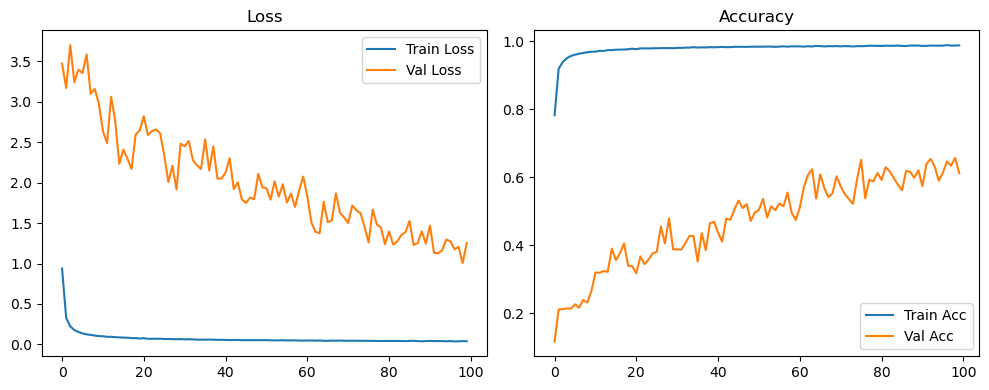

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2079, Acc: 0.9553 | Val Loss: 0.2282, Acc: 0.9307


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9838 | Val Loss: 0.1071, Acc: 0.9682


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.0851, Acc: 0.9738


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9922 | Val Loss: 0.0575, Acc: 0.9822


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9941 | Val Loss: 0.0605, Acc: 0.9815


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0582, Acc: 0.9816


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0496, Acc: 0.9837


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.2005, Acc: 0.9440


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0476, Acc: 0.9873


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0563, Acc: 0.9852


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.2144, Acc: 0.9447


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0496, Acc: 0.9867


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0619, Acc: 0.9854


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9968 | Val Loss: 0.0656, Acc: 0.9832


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0631, Acc: 0.9847


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0583, Acc: 0.9857


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0741, Acc: 0.9814


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0721, Acc: 0.9826


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0840, Acc: 0.9808


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0806, Acc: 0.9837


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0682, Acc: 0.9849


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0755, Acc: 0.9844


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0820, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0773, Acc: 0.9823


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0683, Acc: 0.9851


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0520, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0764, Acc: 0.9848


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0792, Acc: 0.9833


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0640, Acc: 0.9866


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.0736, Acc: 0.9848


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1166, Acc: 0.9769


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0668, Acc: 0.9869


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0556, Acc: 0.9877


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0599, Acc: 0.9888


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0659, Acc: 0.9876


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0652, Acc: 0.9870


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0651, Acc: 0.9872


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0676, Acc: 0.9876


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0640, Acc: 0.9867


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0714, Acc: 0.9873


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9893


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9899


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9906


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1253, Acc: 0.9776


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.0656, Acc: 0.9870


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0659, Acc: 0.9876


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0656, Acc: 0.9884


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0559, Acc: 0.9895


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0563, Acc: 0.9894


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9897


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0552, Acc: 0.9898


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9881


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0739, Acc: 0.9861


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0825, Acc: 0.9846


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0619, Acc: 0.9886


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0689, Acc: 0.9888


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0738, Acc: 0.9879


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0692, Acc: 0.9878


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0695, Acc: 0.9874


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0933, Acc: 0.9848


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0950, Acc: 0.9830


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0645, Acc: 0.9889


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0587, Acc: 0.9900


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9904


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9900


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9909


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0902, Acc: 0.9837


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0709, Acc: 0.9868


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0753, Acc: 0.9884


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0674, Acc: 0.9889


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9901


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0624, Acc: 0.9892


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0921, Acc: 0.9868


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0739, Acc: 0.9875


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0690, Acc: 0.9886


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0655, Acc: 0.9897


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0611, Acc: 0.9900


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0697, Acc: 0.9890


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0727, Acc: 0.9891


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0806, Acc: 0.9869


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0765, Acc: 0.9881


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0863, Acc: 0.9858


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0819, Acc: 0.9857


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0756, Acc: 0.9885


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0815, Acc: 0.9868


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0764, Acc: 0.9878


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0712, Acc: 0.9897


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0705, Acc: 0.9892


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0723, Acc: 0.9890


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0878, Acc: 0.9876


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0994, Acc: 0.9849


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0821, Acc: 0.9878


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0742, Acc: 0.9891


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0777, Acc: 0.9882


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0697, Acc: 0.9894


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9898


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0736, Acc: 0.9892


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1079, Acc: 0.9855


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0863, Acc: 0.9879


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0814, Acc: 0.9884


Final Test Loss: 0.0788 Accuracy: 0.9879


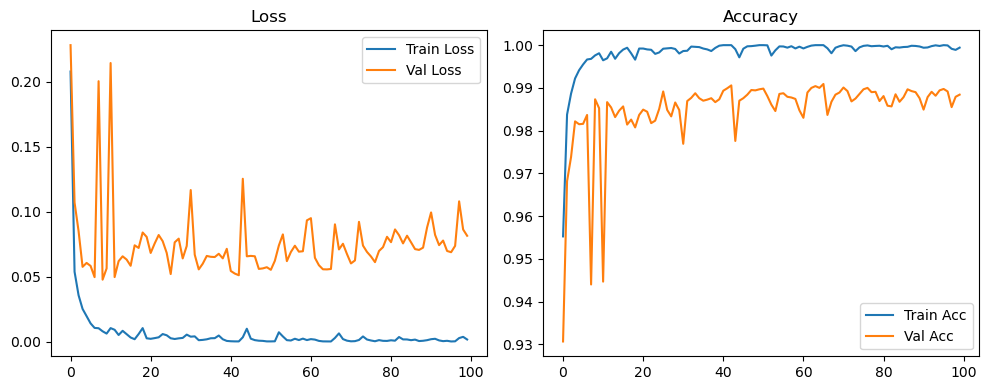

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2585, Acc: 0.9389 | Val Loss: 1.8121, Acc: 0.4779


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9750 | Val Loss: 0.8635, Acc: 0.7190


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9813 | Val Loss: 1.0187, Acc: 0.6911


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 0.6016, Acc: 0.7985


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.5087, Acc: 0.8413


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.6455, Acc: 0.8005


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9898 | Val Loss: 0.4520, Acc: 0.8562


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.3192, Acc: 0.8966


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.2865, Acc: 0.9081


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.2879, Acc: 0.9153


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.3616, Acc: 0.8913


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.2776, Acc: 0.9183


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.5239, Acc: 0.8623


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9930 | Val Loss: 0.2955, Acc: 0.9183


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.3567, Acc: 0.9062


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.2263, Acc: 0.9344


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1829, Acc: 0.9513


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.3433, Acc: 0.9094


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.2030, Acc: 0.9455


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.3081, Acc: 0.9224


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9951 | Val Loss: 0.2430, Acc: 0.9387


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9949 | Val Loss: 0.2224, Acc: 0.9404


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.2599, Acc: 0.9358


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1610, Acc: 0.9588


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1359, Acc: 0.9654


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1758, Acc: 0.9566


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.2848, Acc: 0.9343


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9961 | Val Loss: 0.1681, Acc: 0.9596


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9963 | Val Loss: 0.1200, Acc: 0.9686


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.2546, Acc: 0.9427


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1652, Acc: 0.9604


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.2268, Acc: 0.9484


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1398, Acc: 0.9676


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1239, Acc: 0.9722


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1947, Acc: 0.9561


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1560, Acc: 0.9640


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.1275, Acc: 0.9709


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.2118, Acc: 0.9532


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1641, Acc: 0.9633


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1783, Acc: 0.9615


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1212, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1234, Acc: 0.9718


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1793, Acc: 0.9607


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1419, Acc: 0.9692


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1278, Acc: 0.9742


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1131, Acc: 0.9739


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1726, Acc: 0.9655


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1809, Acc: 0.9620


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1583, Acc: 0.9681


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1379, Acc: 0.9720


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9975 | Val Loss: 0.1416, Acc: 0.9714


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1893, Acc: 0.9613


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1416, Acc: 0.9713


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9974 | Val Loss: 0.2277, Acc: 0.9576


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1929, Acc: 0.9637


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1281, Acc: 0.9759


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1690, Acc: 0.9666


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1575, Acc: 0.9691


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1514, Acc: 0.9718


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1570, Acc: 0.9708


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.2022, Acc: 0.9634


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1584, Acc: 0.9711


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1600, Acc: 0.9715


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1373, Acc: 0.9764


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1548, Acc: 0.9720


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.2286, Acc: 0.9593


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2277, Acc: 0.9597


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.2287, Acc: 0.9607


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.2165, Acc: 0.9641


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.2018, Acc: 0.9643


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1645, Acc: 0.9707


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9708


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2008, Acc: 0.9649


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1952, Acc: 0.9674


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1541, Acc: 0.9747


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1740, Acc: 0.9705


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1968, Acc: 0.9659


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1664, Acc: 0.9715


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1766, Acc: 0.9690


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1647, Acc: 0.9714


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1565, Acc: 0.9728


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1794, Acc: 0.9686


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.2043, Acc: 0.9642


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1555, Acc: 0.9747


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1783, Acc: 0.9708


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.2111, Acc: 0.9651


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1480, Acc: 0.9756


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1496, Acc: 0.9751


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1561, Acc: 0.9724


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1178, Acc: 0.9806


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1310, Acc: 0.9768


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.2198, Acc: 0.9643


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1513, Acc: 0.9742


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1643, Acc: 0.9735


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1666, Acc: 0.9741


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1470, Acc: 0.9782


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1405, Acc: 0.9766


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.2095, Acc: 0.9660


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1803, Acc: 0.9705


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1062, Acc: 0.9808


Final Test Loss: 0.1167 Accuracy: 0.9798


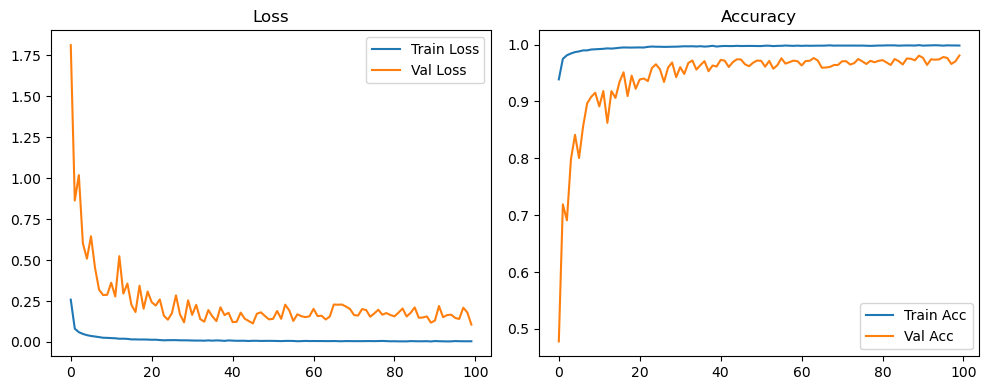

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4575, Acc: 0.8684 | Val Loss: 2.2053, Acc: 0.3165


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1666, Acc: 0.9515 | Val Loss: 1.7309, Acc: 0.4238


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9620 | Val Loss: 2.0388, Acc: 0.4334


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1117, Acc: 0.9661 | Val Loss: 1.4626, Acc: 0.4962


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9685 | Val Loss: 1.6660, Acc: 0.5018


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9709 | Val Loss: 1.5586, Acc: 0.4839


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9736 | Val Loss: 1.5055, Acc: 0.4974


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9737 | Val Loss: 1.2483, Acc: 0.5887


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9747 | Val Loss: 0.7984, Acc: 0.7082


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9766 | Val Loss: 1.0041, Acc: 0.6536


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9766 | Val Loss: 0.8886, Acc: 0.6743


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9771 | Val Loss: 0.8886, Acc: 0.6849


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9776 | Val Loss: 1.1649, Acc: 0.6257


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9795 | Val Loss: 0.6423, Acc: 0.7725


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9792 | Val Loss: 0.6688, Acc: 0.7409


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9804 | Val Loss: 0.6123, Acc: 0.7722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9810 | Val Loss: 0.9968, Acc: 0.6811


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9810 | Val Loss: 0.8226, Acc: 0.7042


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9813 | Val Loss: 0.8857, Acc: 0.7153


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9812 | Val Loss: 0.8117, Acc: 0.7200


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9830 | Val Loss: 0.6375, Acc: 0.7836


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9827 | Val Loss: 0.5647, Acc: 0.7980


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9828 | Val Loss: 0.4641, Acc: 0.8373


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9829 | Val Loss: 0.5180, Acc: 0.8157


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9826 | Val Loss: 0.5965, Acc: 0.7937


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9826 | Val Loss: 0.5710, Acc: 0.8036


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.5982, Acc: 0.8003


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9837 | Val Loss: 0.7690, Acc: 0.7436


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.8965, Acc: 0.7356


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9839 | Val Loss: 0.9248, Acc: 0.7238


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9832 | Val Loss: 0.8713, Acc: 0.7258


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9851 | Val Loss: 0.8891, Acc: 0.7278


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.9232, Acc: 0.7313


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9850 | Val Loss: 0.7785, Acc: 0.7601


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9856 | Val Loss: 0.7910, Acc: 0.7348


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9857 | Val Loss: 0.8956, Acc: 0.7193


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 0.5413, Acc: 0.8136


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9862 | Val Loss: 0.6558, Acc: 0.7751


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9856 | Val Loss: 0.5807, Acc: 0.7997


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9860 | Val Loss: 0.7289, Acc: 0.7510


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9853 | Val Loss: 0.6063, Acc: 0.7915


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9863 | Val Loss: 0.5213, Acc: 0.8170


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.6028, Acc: 0.7874


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9857 | Val Loss: 0.4269, Acc: 0.8335


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9868 | Val Loss: 0.6689, Acc: 0.7786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.5319, Acc: 0.8088


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9868 | Val Loss: 0.5093, Acc: 0.8229


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9866 | Val Loss: 0.6583, Acc: 0.7865


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9857 | Val Loss: 0.6695, Acc: 0.7642


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.5012, Acc: 0.8190


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.6912, Acc: 0.7747


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9871 | Val Loss: 0.7045, Acc: 0.7561


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9877 | Val Loss: 0.6413, Acc: 0.7819


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9867 | Val Loss: 0.5378, Acc: 0.7802


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.5460, Acc: 0.8013


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.3605, Acc: 0.8599


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9878 | Val Loss: 0.7200, Acc: 0.7459


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9873 | Val Loss: 0.7096, Acc: 0.7563


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.5031, Acc: 0.8095


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9880 | Val Loss: 0.4863, Acc: 0.8227


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9880 | Val Loss: 0.4859, Acc: 0.8048


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 0.4108, Acc: 0.8443


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9877 | Val Loss: 0.5918, Acc: 0.7833


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.4117, Acc: 0.8426


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9874 | Val Loss: 0.4389, Acc: 0.8283


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.4594, Acc: 0.8407


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9881 | Val Loss: 0.5935, Acc: 0.7708


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9880 | Val Loss: 0.6654, Acc: 0.7374


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9877 | Val Loss: 0.6837, Acc: 0.7390


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9883 | Val Loss: 0.5617, Acc: 0.7773


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.4267, Acc: 0.8342


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.8032, Acc: 0.7170


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9885 | Val Loss: 0.6803, Acc: 0.7551


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.5487, Acc: 0.7914


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9887 | Val Loss: 0.4660, Acc: 0.8165


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.6740, Acc: 0.7430


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.6110, Acc: 0.7625


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.5484, Acc: 0.7949


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9889 | Val Loss: 0.5040, Acc: 0.8075


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.6402, Acc: 0.7500


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9885 | Val Loss: 0.6000, Acc: 0.7769


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.6436, Acc: 0.7529


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.4840, Acc: 0.8138


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.4032, Acc: 0.8401


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.4750, Acc: 0.8112


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.4349, Acc: 0.8391


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.4245, Acc: 0.8375


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9900 | Val Loss: 0.5315, Acc: 0.7899


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.3712, Acc: 0.8588


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9893 | Val Loss: 0.5644, Acc: 0.7704


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9893 | Val Loss: 0.5003, Acc: 0.7836


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.5952, Acc: 0.7565


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.5542, Acc: 0.7684


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.7579, Acc: 0.6839


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.5242, Acc: 0.7719


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9892 | Val Loss: 0.5802, Acc: 0.7710


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9898 | Val Loss: 0.5857, Acc: 0.7684


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.4975, Acc: 0.8000


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9897 | Val Loss: 0.4701, Acc: 0.8063


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.5703, Acc: 0.7650


Final Test Loss: 0.5545 Accuracy: 0.7754


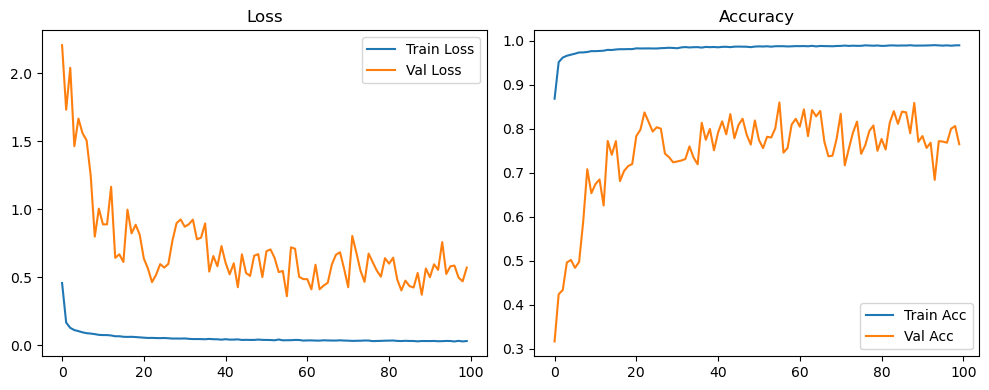

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2078, Acc: 0.9552 | Val Loss: 0.2402, Acc: 0.9240


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9842 | Val Loss: 0.1135, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.0938, Acc: 0.9717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9923 | Val Loss: 0.0634, Acc: 0.9802


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.0609, Acc: 0.9809


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1179, Acc: 0.9671


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0475, Acc: 0.9842


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0658, Acc: 0.9812


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0794, Acc: 0.9758


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0770, Acc: 0.9788


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0583, Acc: 0.9841


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1131, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1780, Acc: 0.9549


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0804, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0877, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0647, Acc: 0.9839


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0509, Acc: 0.9888


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0794, Acc: 0.9817


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0838, Acc: 0.9810


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0574, Acc: 0.9861


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0550, Acc: 0.9866


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0690, Acc: 0.9850


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0609, Acc: 0.9870


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0590, Acc: 0.9863


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0705, Acc: 0.9849


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0633, Acc: 0.9868


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0755, Acc: 0.9832


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0504, Acc: 0.9893


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0547, Acc: 0.9894


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0473, Acc: 0.9893


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9892


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1523, Acc: 0.9711


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0944, Acc: 0.9822


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0751, Acc: 0.9856


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0664, Acc: 0.9869


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0591, Acc: 0.9882


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0884, Acc: 0.9837


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0626, Acc: 0.9889


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0776, Acc: 0.9862


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0698, Acc: 0.9858


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0691, Acc: 0.9870


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0777, Acc: 0.9848


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1007, Acc: 0.9820


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0650, Acc: 0.9887


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0602, Acc: 0.9888


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9893


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0884, Acc: 0.9847


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0694, Acc: 0.9870


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0639, Acc: 0.9878


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0606, Acc: 0.9885


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0569, Acc: 0.9894


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9896


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9898


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9900


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9903


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9898


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9905


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9897


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9906


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9898


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1003, Acc: 0.9824


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0693, Acc: 0.9892


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0641, Acc: 0.9897


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0607, Acc: 0.9896


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9906


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0635, Acc: 0.9893


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9902


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9903


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9900


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9903


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9897


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0760, Acc: 0.9882


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1225, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0713, Acc: 0.9882


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0624, Acc: 0.9898


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0649, Acc: 0.9892


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9888


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9890


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9892


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9892


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9893


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9890


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9897


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9893


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9899


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9896


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0621, Acc: 0.9893


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9892


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9901


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0642, Acc: 0.9894


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9897


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9900


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9904


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9902


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9902


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9906


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9906


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9907


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9912


Final Test Loss: 0.0702 Accuracy: 0.9893


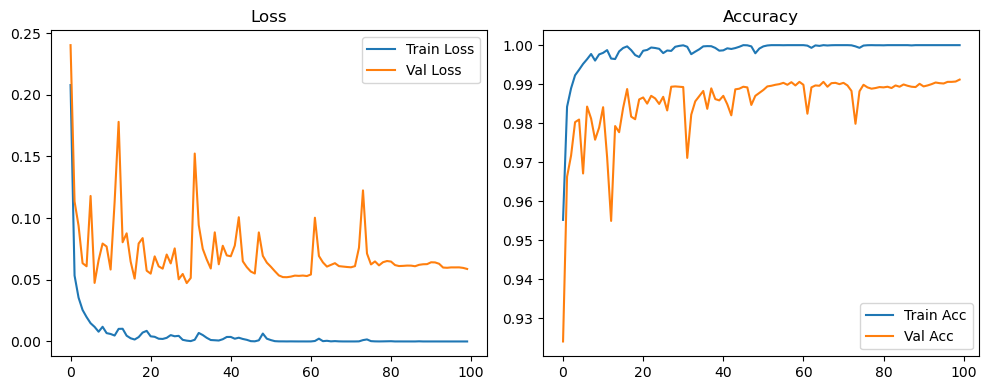

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2584, Acc: 0.9385 | Val Loss: 1.8760, Acc: 0.4714


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9750 | Val Loss: 0.8800, Acc: 0.7302


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9818 | Val Loss: 0.9647, Acc: 0.7117


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9844 | Val Loss: 0.6512, Acc: 0.7937


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9865 | Val Loss: 0.6347, Acc: 0.8002


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.5130, Acc: 0.8396


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.4326, Acc: 0.8618


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.5430, Acc: 0.8439


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.2894, Acc: 0.9083


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9910 | Val Loss: 0.4080, Acc: 0.8891


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.4094, Acc: 0.8815


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.2106, Acc: 0.9373


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.4404, Acc: 0.8801


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.2747, Acc: 0.9223


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.4084, Acc: 0.8927


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.2894, Acc: 0.9244


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.2061, Acc: 0.9443


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.2132, Acc: 0.9452


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1559, Acc: 0.9573


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.2538, Acc: 0.9351


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.1819, Acc: 0.9542


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.2625, Acc: 0.9313


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1794, Acc: 0.9549


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1827, Acc: 0.9552


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1765, Acc: 0.9570


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1907, Acc: 0.9531


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1774, Acc: 0.9541


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1588, Acc: 0.9626


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1621, Acc: 0.9609


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1285, Acc: 0.9695


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.2666, Acc: 0.9444


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.1683, Acc: 0.9604


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1848, Acc: 0.9581


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9966 | Val Loss: 0.1636, Acc: 0.9618


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1895, Acc: 0.9547


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1188, Acc: 0.9709


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1325, Acc: 0.9685


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1726, Acc: 0.9593


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9971 | Val Loss: 0.2379, Acc: 0.9492


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.2088, Acc: 0.9552


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1462, Acc: 0.9668


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1551, Acc: 0.9657


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.2482, Acc: 0.9487


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.2384, Acc: 0.9491


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1553, Acc: 0.9659


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1377, Acc: 0.9706


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1308, Acc: 0.9713


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1489, Acc: 0.9686


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1332, Acc: 0.9725


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1512, Acc: 0.9666


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1481, Acc: 0.9692


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1473, Acc: 0.9688


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1425, Acc: 0.9702


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1164, Acc: 0.9746


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1281, Acc: 0.9732


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1314, Acc: 0.9733


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1450, Acc: 0.9710


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1933, Acc: 0.9629


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1670, Acc: 0.9691


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1090, Acc: 0.9781


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1671, Acc: 0.9673


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1499, Acc: 0.9711


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1148, Acc: 0.9788


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1133, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1691, Acc: 0.9665


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1769, Acc: 0.9668


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1409, Acc: 0.9738


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1596, Acc: 0.9702


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1555, Acc: 0.9718


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1982, Acc: 0.9630


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1573, Acc: 0.9706


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1523, Acc: 0.9721


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1748, Acc: 0.9673


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1666, Acc: 0.9693


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1670, Acc: 0.9685


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.2052, Acc: 0.9641


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1803, Acc: 0.9684


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1334, Acc: 0.9740


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2068, Acc: 0.9624


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1508, Acc: 0.9722


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1507, Acc: 0.9725


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1617, Acc: 0.9713


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1450, Acc: 0.9735


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1327, Acc: 0.9758


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1471, Acc: 0.9737


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1666, Acc: 0.9703


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1448, Acc: 0.9739


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1651, Acc: 0.9712


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1716, Acc: 0.9698


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9736


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1430, Acc: 0.9739


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1580, Acc: 0.9719


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1460, Acc: 0.9738


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1418, Acc: 0.9754


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1596, Acc: 0.9715


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1594, Acc: 0.9724


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1613, Acc: 0.9707


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1506, Acc: 0.9728


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1401, Acc: 0.9748


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1542, Acc: 0.9719


Final Test Loss: 0.1745 Accuracy: 0.9690


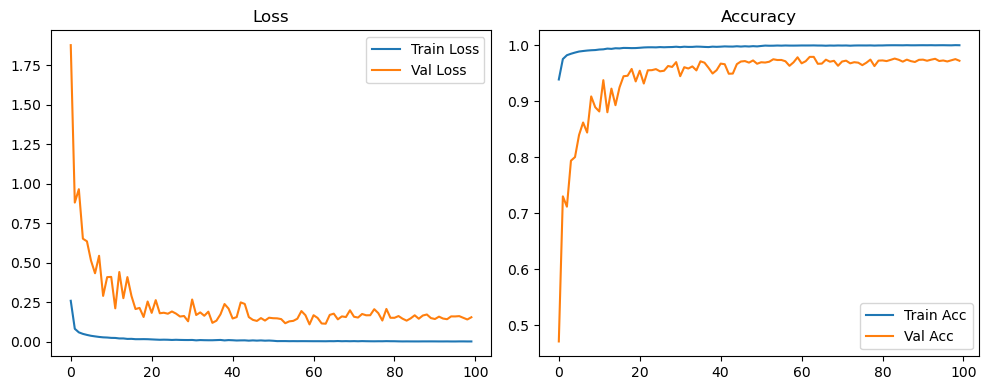

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4577, Acc: 0.8683 | Val Loss: 2.0865, Acc: 0.3468


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1656, Acc: 0.9516 | Val Loss: 1.7107, Acc: 0.4508


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9624 | Val Loss: 1.9312, Acc: 0.4665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9665 | Val Loss: 1.5962, Acc: 0.4865


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9687 | Val Loss: 1.8271, Acc: 0.4853


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9719 | Val Loss: 1.5954, Acc: 0.5251


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9731 | Val Loss: 1.7798, Acc: 0.4736


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9732 | Val Loss: 1.6750, Acc: 0.5124


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9747 | Val Loss: 1.1878, Acc: 0.6183


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9766 | Val Loss: 1.2815, Acc: 0.6083


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9765 | Val Loss: 1.1008, Acc: 0.6392


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9768 | Val Loss: 0.8571, Acc: 0.7090


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9786 | Val Loss: 1.4084, Acc: 0.5841


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9788 | Val Loss: 0.9740, Acc: 0.6933


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.9255, Acc: 0.6828


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 1.1445, Acc: 0.6389


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9809 | Val Loss: 1.5714, Acc: 0.5453


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9802 | Val Loss: 1.3051, Acc: 0.5883


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9807 | Val Loss: 1.2147, Acc: 0.6428


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.7065, Acc: 0.7622


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9819 | Val Loss: 0.8249, Acc: 0.7385


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9826 | Val Loss: 0.7819, Acc: 0.7536


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9827 | Val Loss: 0.5825, Acc: 0.8000


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9828 | Val Loss: 0.9190, Acc: 0.7018


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9830 | Val Loss: 0.8846, Acc: 0.7141


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9816 | Val Loss: 0.8715, Acc: 0.7376


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9834 | Val Loss: 0.6799, Acc: 0.7897


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 0.9651, Acc: 0.7103


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9840 | Val Loss: 1.1885, Acc: 0.6719


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9828 | Val Loss: 1.2451, Acc: 0.6532


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 1.1509, Acc: 0.6744


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9847 | Val Loss: 0.9241, Acc: 0.7309


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9849 | Val Loss: 0.8685, Acc: 0.7434


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9846 | Val Loss: 0.8182, Acc: 0.7440


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9845 | Val Loss: 0.7475, Acc: 0.7586


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9858 | Val Loss: 1.3370, Acc: 0.6408


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9843 | Val Loss: 0.6003, Acc: 0.8033


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.8144, Acc: 0.7297


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9856 | Val Loss: 0.8142, Acc: 0.7496


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9855 | Val Loss: 0.8150, Acc: 0.7377


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9855 | Val Loss: 0.8355, Acc: 0.7410


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9860 | Val Loss: 0.6509, Acc: 0.7898


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.7754, Acc: 0.7530


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.8295, Acc: 0.7402


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9866 | Val Loss: 0.7674, Acc: 0.7576


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.5724, Acc: 0.8055


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9861 | Val Loss: 0.6697, Acc: 0.7834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.6485, Acc: 0.7864


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9866 | Val Loss: 0.7786, Acc: 0.7499


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9863 | Val Loss: 1.1950, Acc: 0.6577


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.6294, Acc: 0.7868


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.6456, Acc: 0.7842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9892 | Val Loss: 0.5604, Acc: 0.8061


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.6175, Acc: 0.7823


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.7470, Acc: 0.7596


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.5146, Acc: 0.8148


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.7001, Acc: 0.7667


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9891 | Val Loss: 0.8661, Acc: 0.7262


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9889 | Val Loss: 0.6946, Acc: 0.7678


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9895 | Val Loss: 0.7068, Acc: 0.7650


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9892 | Val Loss: 0.7310, Acc: 0.7507


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.7257, Acc: 0.7582


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.8794, Acc: 0.7231


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.6144, Acc: 0.7911


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9894 | Val Loss: 0.6882, Acc: 0.7634


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.7167, Acc: 0.7595


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.6957, Acc: 0.7578


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9906 | Val Loss: 0.7752, Acc: 0.7376


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.7260, Acc: 0.7487


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.6445, Acc: 0.7705


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9895 | Val Loss: 0.6049, Acc: 0.7850


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.6952, Acc: 0.7669


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.8233, Acc: 0.7188


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.6518, Acc: 0.7590


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.5132, Acc: 0.8037


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.6734, Acc: 0.7626


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9910 | Val Loss: 0.7242, Acc: 0.7488


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9900 | Val Loss: 0.4937, Acc: 0.8184


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.5563, Acc: 0.7959


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.5738, Acc: 0.7926


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.5237, Acc: 0.8076


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9913 | Val Loss: 0.5187, Acc: 0.8123


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9917 | Val Loss: 0.5333, Acc: 0.8072


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.4642, Acc: 0.8209


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9920 | Val Loss: 0.5248, Acc: 0.8023


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.4881, Acc: 0.8168


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.4897, Acc: 0.8152


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.4919, Acc: 0.8174


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.4828, Acc: 0.8182


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.4994, Acc: 0.8111


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.5013, Acc: 0.8117


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9925 | Val Loss: 0.5346, Acc: 0.7983


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.5134, Acc: 0.8041


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.5385, Acc: 0.7940


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9925 | Val Loss: 0.5654, Acc: 0.7848


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.5563, Acc: 0.7890


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.5670, Acc: 0.7883


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.6557, Acc: 0.7652


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.5140, Acc: 0.8013


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.5180, Acc: 0.8007


Final Test Loss: 0.5069 Accuracy: 0.8017


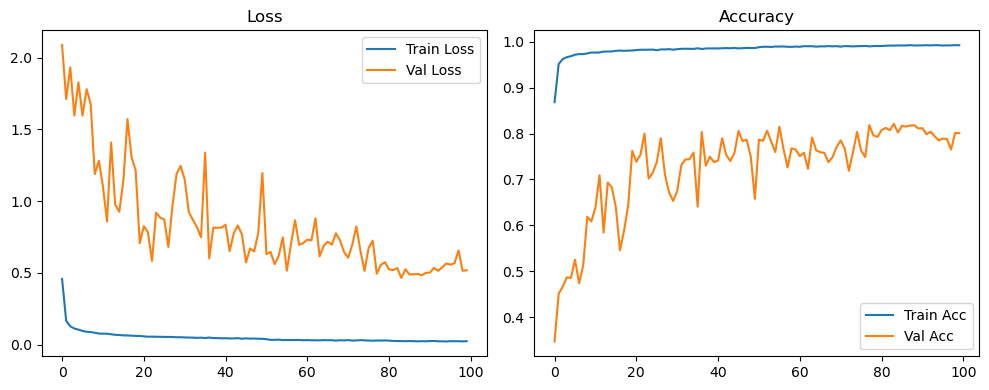

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2080, Acc: 0.9552 | Val Loss: 0.2407, Acc: 0.9237


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9836 | Val Loss: 0.1089, Acc: 0.9669


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9893 | Val Loss: 0.0989, Acc: 0.9694


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9923 | Val Loss: 0.0672, Acc: 0.9783


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.0546, Acc: 0.9828


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0532, Acc: 0.9828


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0641, Acc: 0.9807


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.2156, Acc: 0.9389


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0775, Acc: 0.9778


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0514, Acc: 0.9863


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1058, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0772, Acc: 0.9793


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0623, Acc: 0.9845


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1074, Acc: 0.9726


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1100, Acc: 0.9736


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0465, Acc: 0.9892


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0536, Acc: 0.9868


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0846, Acc: 0.9798


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0732, Acc: 0.9822


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0618, Acc: 0.9857


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0680, Acc: 0.9845


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0617, Acc: 0.9874


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0699, Acc: 0.9849


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0880, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0849, Acc: 0.9826


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0578, Acc: 0.9883


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0553, Acc: 0.9886


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0537, Acc: 0.9895


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0531, Acc: 0.9892


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0557, Acc: 0.9891


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0807, Acc: 0.9833


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0709, Acc: 0.9868


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0609, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0645, Acc: 0.9877


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0608, Acc: 0.9889


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9895


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0590, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0905, Acc: 0.9833


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1063, Acc: 0.9809


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0650, Acc: 0.9868


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0626, Acc: 0.9882


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0700, Acc: 0.9867


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0635, Acc: 0.9882


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0665, Acc: 0.9895


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0990, Acc: 0.9828


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0931, Acc: 0.9842


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0795, Acc: 0.9868


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0772, Acc: 0.9858


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0691, Acc: 0.9887


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0743, Acc: 0.9859


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0606, Acc: 0.9902


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9902


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9900


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9904


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9904


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9909


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9904


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9899


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0691, Acc: 0.9872


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0771, Acc: 0.9873


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0693, Acc: 0.9881


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0680, Acc: 0.9886


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0690, Acc: 0.9885


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9891


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9891


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9895


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0751, Acc: 0.9875


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0700, Acc: 0.9896


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9892


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9900


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9906


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9902


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9903


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9906


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9907


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9903


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9904


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9905


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9904


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9903


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9905


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9903


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9905


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9906


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9904


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9902


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9907


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9908


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9905


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9903


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9905


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9903


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9909


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9911


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9905


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9905


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9907


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9908


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9907


Final Test Loss: 0.0604 Accuracy: 0.9910


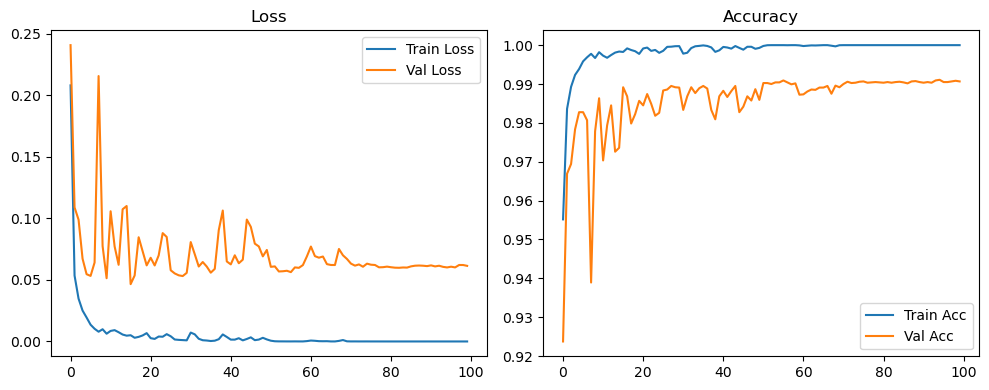

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2582, Acc: 0.9391 | Val Loss: 1.6010, Acc: 0.5363


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9756 | Val Loss: 0.7664, Acc: 0.7544


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9815 | Val Loss: 0.8193, Acc: 0.7489


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9844 | Val Loss: 0.6026, Acc: 0.8017


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9870 | Val Loss: 0.4370, Acc: 0.8592


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9885 | Val Loss: 0.4718, Acc: 0.8590


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.4009, Acc: 0.8702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9898 | Val Loss: 0.3698, Acc: 0.8832


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.3541, Acc: 0.8882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.2565, Acc: 0.9265


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.1723, Acc: 0.9462


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.1489, Acc: 0.9538


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.2517, Acc: 0.9254


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.2605, Acc: 0.9229


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.2471, Acc: 0.9316


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1560, Acc: 0.9558


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.2082, Acc: 0.9441


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1389, Acc: 0.9635


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1789, Acc: 0.9515


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1981, Acc: 0.9507


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9950 | Val Loss: 0.1738, Acc: 0.9555


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.2642, Acc: 0.9361


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9953 | Val Loss: 0.2403, Acc: 0.9447


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1572, Acc: 0.9624


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1788, Acc: 0.9558


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9956 | Val Loss: 0.2175, Acc: 0.9450


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9954 | Val Loss: 0.2434, Acc: 0.9393


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.2059, Acc: 0.9489


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.1755, Acc: 0.9567


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1668, Acc: 0.9601


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.1304, Acc: 0.9696


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.3271, Acc: 0.9289


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.2982, Acc: 0.9367


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1350, Acc: 0.9711


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.2007, Acc: 0.9562


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1632, Acc: 0.9633


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.1613, Acc: 0.9666


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.3755, Acc: 0.9310


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.2684, Acc: 0.9453


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1670, Acc: 0.9648


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1896, Acc: 0.9602


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.1322, Acc: 0.9718


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1774, Acc: 0.9646


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1425, Acc: 0.9699


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1827, Acc: 0.9631


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.1887, Acc: 0.9615


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.2009, Acc: 0.9613


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1416, Acc: 0.9715


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1126, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1606, Acc: 0.9696


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1349, Acc: 0.9735


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1803, Acc: 0.9653


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1261, Acc: 0.9771


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1383, Acc: 0.9738


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.2178, Acc: 0.9592


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1270, Acc: 0.9770


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1403, Acc: 0.9731


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1795, Acc: 0.9659


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1277, Acc: 0.9767


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1352, Acc: 0.9756


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1400, Acc: 0.9756


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1362, Acc: 0.9765


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1233, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1456, Acc: 0.9734


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1202, Acc: 0.9776


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1568, Acc: 0.9722


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1375, Acc: 0.9744


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1375, Acc: 0.9760


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1282, Acc: 0.9782


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1553, Acc: 0.9727


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1572, Acc: 0.9741


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1517, Acc: 0.9754


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2100, Acc: 0.9669


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1557, Acc: 0.9739


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1783, Acc: 0.9710


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1555, Acc: 0.9749


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1529, Acc: 0.9740


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1226, Acc: 0.9789


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1313, Acc: 0.9784


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1466, Acc: 0.9757


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1397, Acc: 0.9769


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1397, Acc: 0.9766


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1380, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1282, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1393, Acc: 0.9774


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1488, Acc: 0.9755


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1323, Acc: 0.9790


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1344, Acc: 0.9786


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1383, Acc: 0.9783


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1343, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1304, Acc: 0.9796


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1405, Acc: 0.9774


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1354, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1261, Acc: 0.9799


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1366, Acc: 0.9784


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1332, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1412, Acc: 0.9776


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1363, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1351, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1337, Acc: 0.9793


Final Test Loss: 0.1386 Accuracy: 0.9767


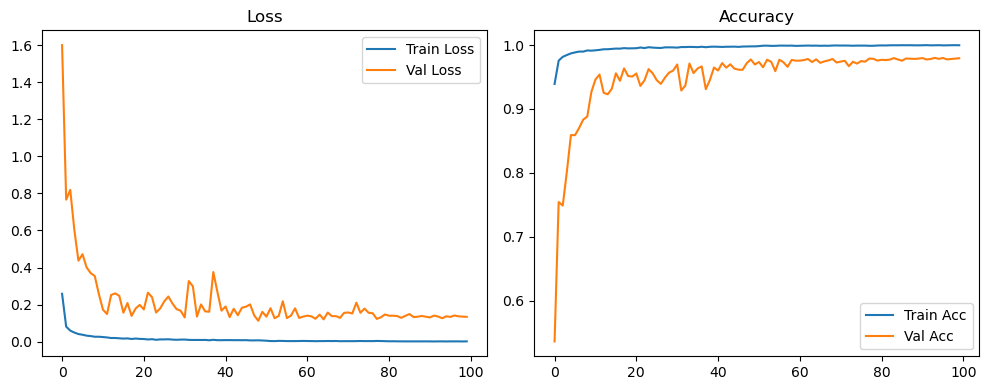

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4576, Acc: 0.8684 | Val Loss: 2.2468, Acc: 0.3065


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1662, Acc: 0.9513 | Val Loss: 1.8539, Acc: 0.3925


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9623 | Val Loss: 1.9694, Acc: 0.4447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9661 | Val Loss: 1.7220, Acc: 0.4233


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9686 | Val Loss: 1.6098, Acc: 0.5222


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0951, Acc: 0.9714 | Val Loss: 1.7947, Acc: 0.4511


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9730 | Val Loss: 1.4665, Acc: 0.5159


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9738 | Val Loss: 1.2928, Acc: 0.5841


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9751 | Val Loss: 0.7666, Acc: 0.7194


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9763 | Val Loss: 1.1632, Acc: 0.6392


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9771 | Val Loss: 0.9285, Acc: 0.6805


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9768 | Val Loss: 0.7590, Acc: 0.7332


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9782 | Val Loss: 0.9990, Acc: 0.6649


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9793 | Val Loss: 0.8110, Acc: 0.7357


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9796 | Val Loss: 0.7458, Acc: 0.7447


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9811 | Val Loss: 0.6884, Acc: 0.7500


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9802 | Val Loss: 1.0799, Acc: 0.6576


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9806 | Val Loss: 0.8438, Acc: 0.7301


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9813 | Val Loss: 0.7474, Acc: 0.7502


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9812 | Val Loss: 0.7086, Acc: 0.7567


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9822 | Val Loss: 0.5375, Acc: 0.8140


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9827 | Val Loss: 0.7341, Acc: 0.7608


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9830 | Val Loss: 0.5817, Acc: 0.8023


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9835 | Val Loss: 0.4892, Acc: 0.8293


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9828 | Val Loss: 0.5254, Acc: 0.8237


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 0.6137, Acc: 0.8047


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9830 | Val Loss: 0.6146, Acc: 0.8003


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9840 | Val Loss: 0.7649, Acc: 0.7532


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9839 | Val Loss: 0.8085, Acc: 0.7471


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9839 | Val Loss: 0.7735, Acc: 0.7622


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.5126, Acc: 0.8170


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9848 | Val Loss: 0.6525, Acc: 0.7819


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9854 | Val Loss: 0.9189, Acc: 0.7226


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.6421, Acc: 0.7837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9851 | Val Loss: 0.6443, Acc: 0.7854


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9846 | Val Loss: 0.8024, Acc: 0.7600


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9846 | Val Loss: 0.3509, Acc: 0.8763


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.6398, Acc: 0.7775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.5682, Acc: 0.8020


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9856 | Val Loss: 0.4213, Acc: 0.8486


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9855 | Val Loss: 0.4768, Acc: 0.8235


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9860 | Val Loss: 0.4125, Acc: 0.8455


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9864 | Val Loss: 0.5013, Acc: 0.8277


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9859 | Val Loss: 0.4727, Acc: 0.8211


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9864 | Val Loss: 0.5471, Acc: 0.8117


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.5265, Acc: 0.8069


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.6175, Acc: 0.7849


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.5818, Acc: 0.7991


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.6155, Acc: 0.7649


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 0.5858, Acc: 0.7920


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9876 | Val Loss: 0.4597, Acc: 0.8227


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.5839, Acc: 0.7864


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 0.4391, Acc: 0.8344


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.4595, Acc: 0.8229


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9898 | Val Loss: 0.5173, Acc: 0.8161


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.3793, Acc: 0.8620


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.6271, Acc: 0.7799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.6571, Acc: 0.7690


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.5794, Acc: 0.7927


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9899 | Val Loss: 0.5450, Acc: 0.8063


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.5977, Acc: 0.7835


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9901 | Val Loss: 0.5557, Acc: 0.7973


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.5032, Acc: 0.8125


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.3642, Acc: 0.8671


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9899 | Val Loss: 0.4677, Acc: 0.8269


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9901 | Val Loss: 0.5165, Acc: 0.8132


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9897 | Val Loss: 0.5152, Acc: 0.8093


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9906 | Val Loss: 0.5656, Acc: 0.7914


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9897 | Val Loss: 0.5391, Acc: 0.8003


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.4947, Acc: 0.8193


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.5560, Acc: 0.7936


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9908 | Val Loss: 0.6356, Acc: 0.7778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.6621, Acc: 0.7615


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.5309, Acc: 0.7923


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.4964, Acc: 0.8051


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.5547, Acc: 0.7845


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.5794, Acc: 0.7712


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9906 | Val Loss: 0.4227, Acc: 0.8331


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.5242, Acc: 0.7967


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.5224, Acc: 0.8003


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.4880, Acc: 0.8124


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.4804, Acc: 0.8171


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.5074, Acc: 0.8098


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.4504, Acc: 0.8239


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.4683, Acc: 0.8157


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.4458, Acc: 0.8254


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9925 | Val Loss: 0.4485, Acc: 0.8241


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9929 | Val Loss: 0.4473, Acc: 0.8263


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9924 | Val Loss: 0.4453, Acc: 0.8253


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.4827, Acc: 0.8130


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.4863, Acc: 0.8123


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.4887, Acc: 0.8098


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9923 | Val Loss: 0.4754, Acc: 0.8155


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9931 | Val Loss: 0.4865, Acc: 0.8077


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.4979, Acc: 0.8016


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.4801, Acc: 0.8088


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.4868, Acc: 0.8109


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.4866, Acc: 0.8118


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.4074, Acc: 0.8396


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.4238, Acc: 0.8323


Final Test Loss: 0.4083 Accuracy: 0.8358


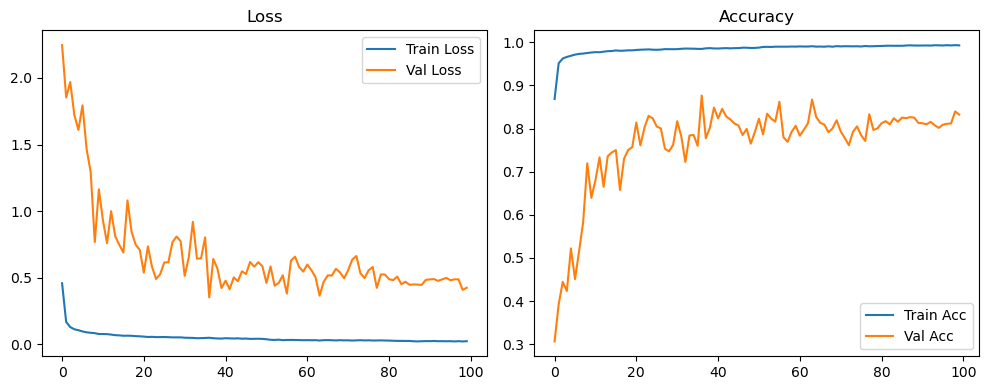

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2076, Acc: 0.9553 | Val Loss: 0.3376, Acc: 0.8955


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9841 | Val Loss: 0.0921, Acc: 0.9731


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.1027, Acc: 0.9661


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9925 | Val Loss: 0.0602, Acc: 0.9805


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0798, Acc: 0.9758


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0565, Acc: 0.9835


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.0784, Acc: 0.9769


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.7553, Acc: 0.8049


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0738, Acc: 0.9791


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0981, Acc: 0.9751


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0723, Acc: 0.9800


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0655, Acc: 0.9827


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0573, Acc: 0.9854


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0687, Acc: 0.9835


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0798, Acc: 0.9834


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0604, Acc: 0.9856


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0843, Acc: 0.9811


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1035, Acc: 0.9768


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0750, Acc: 0.9828


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0491, Acc: 0.9890


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0537, Acc: 0.9887


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0617, Acc: 0.9867


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0737, Acc: 0.9838


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0598, Acc: 0.9877


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0714, Acc: 0.9842


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1388, Acc: 0.9708


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0603, Acc: 0.9864


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0959, Acc: 0.9795


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0850, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0605, Acc: 0.9872


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0613, Acc: 0.9879


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0716, Acc: 0.9851


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0573, Acc: 0.9886


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0659, Acc: 0.9862


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0782, Acc: 0.9840


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0673, Acc: 0.9859


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0824, Acc: 0.9854


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0649, Acc: 0.9885


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0813, Acc: 0.9859


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0772, Acc: 0.9857


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0676, Acc: 0.9878


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9996 | Val Loss: 0.0742, Acc: 0.9868


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0805, Acc: 0.9857


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0666, Acc: 0.9877


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0584, Acc: 0.9895


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0602, Acc: 0.9892


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0737, Acc: 0.9859


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0839, Acc: 0.9862


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1087, Acc: 0.9817


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0692, Acc: 0.9883


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0633, Acc: 0.9893


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9892


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9893


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9894


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9898


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9898


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9898


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9898


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9892


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9898


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9899


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9901


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9901


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9899


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9905


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9903


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9903


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9901


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9902


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9891


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9892


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9901


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9901


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0656, Acc: 0.9896


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9898


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9900


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9894


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9899


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9892


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9901


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9899


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9898


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9897


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9900


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9896


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9903


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9898


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9901


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9903


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9902


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9898


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9900


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9903


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9907


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9907


Final Test Loss: 0.0627 Accuracy: 0.9905


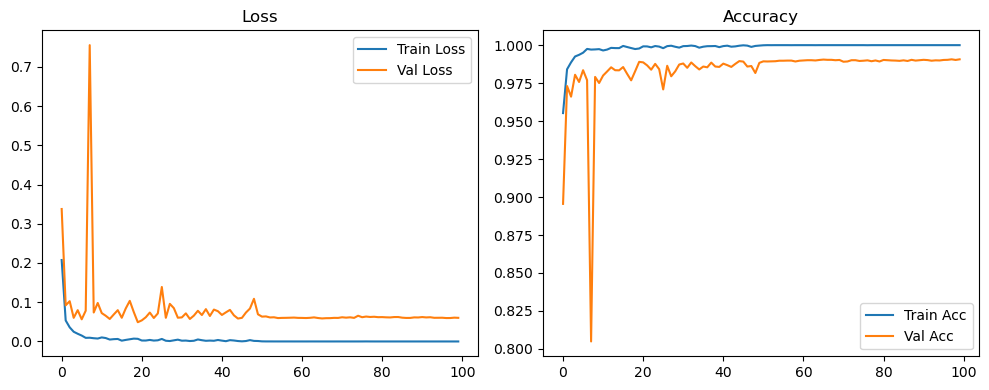

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2583, Acc: 0.9392 | Val Loss: 1.7748, Acc: 0.4895


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.7396, Acc: 0.7642


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9814 | Val Loss: 0.8963, Acc: 0.7204


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9847 | Val Loss: 0.5939, Acc: 0.8034


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.5258, Acc: 0.8334


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9883 | Val Loss: 0.4962, Acc: 0.8516


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9898 | Val Loss: 0.3400, Acc: 0.8899


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.3198, Acc: 0.9026


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.1850, Acc: 0.9413


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.2911, Acc: 0.9133


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.2562, Acc: 0.9224


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9921 | Val Loss: 0.2206, Acc: 0.9341


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.4083, Acc: 0.8913


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9930 | Val Loss: 0.2253, Acc: 0.9367


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.2221, Acc: 0.9393


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.3043, Acc: 0.9169


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.2286, Acc: 0.9399


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1673, Acc: 0.9547


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.2244, Acc: 0.9415


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.3195, Acc: 0.9227


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1673, Acc: 0.9593


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.2078, Acc: 0.9506


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9954 | Val Loss: 0.1838, Acc: 0.9563


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1619, Acc: 0.9609


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1625, Acc: 0.9599


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9959 | Val Loss: 0.1841, Acc: 0.9553


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1624, Acc: 0.9613


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1598, Acc: 0.9618


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1115, Acc: 0.9735


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.2277, Acc: 0.9513


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.2035, Acc: 0.9560


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1621, Acc: 0.9639


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.2739, Acc: 0.9406


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1571, Acc: 0.9657


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1881, Acc: 0.9587


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1404, Acc: 0.9689


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9965 | Val Loss: 0.1482, Acc: 0.9677


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1379, Acc: 0.9692


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1511, Acc: 0.9677


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1792, Acc: 0.9656


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1233, Acc: 0.9744


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0878, Acc: 0.9820


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1696, Acc: 0.9658


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.2007, Acc: 0.9604


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1350, Acc: 0.9727


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1171, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1986, Acc: 0.9616


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1869, Acc: 0.9666


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1143, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1643, Acc: 0.9681


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1396, Acc: 0.9736


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1437, Acc: 0.9733


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1333, Acc: 0.9753


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1326, Acc: 0.9761


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1349, Acc: 0.9752


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1217, Acc: 0.9777


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1260, Acc: 0.9775


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1353, Acc: 0.9758


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1251, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1483, Acc: 0.9732


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1412, Acc: 0.9742


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1499, Acc: 0.9734


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1327, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1333, Acc: 0.9767


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1448, Acc: 0.9757


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1420, Acc: 0.9751


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1147, Acc: 0.9809


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1431, Acc: 0.9760


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1303, Acc: 0.9780


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1270, Acc: 0.9780


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1186, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1255, Acc: 0.9787


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1441, Acc: 0.9753


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1416, Acc: 0.9758


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1522, Acc: 0.9742


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1291, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1181, Acc: 0.9821


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1275, Acc: 0.9786


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1343, Acc: 0.9774


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1346, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1272, Acc: 0.9800


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1312, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1276, Acc: 0.9783


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1180, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1284, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1328, Acc: 0.9784


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1275, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1350, Acc: 0.9777


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1218, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1218, Acc: 0.9807


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1235, Acc: 0.9806


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1312, Acc: 0.9791


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1302, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1185, Acc: 0.9819


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1302, Acc: 0.9804


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1261, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1268, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1285, Acc: 0.9794


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1258, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1251, Acc: 0.9808


Final Test Loss: 0.1402 Accuracy: 0.9763


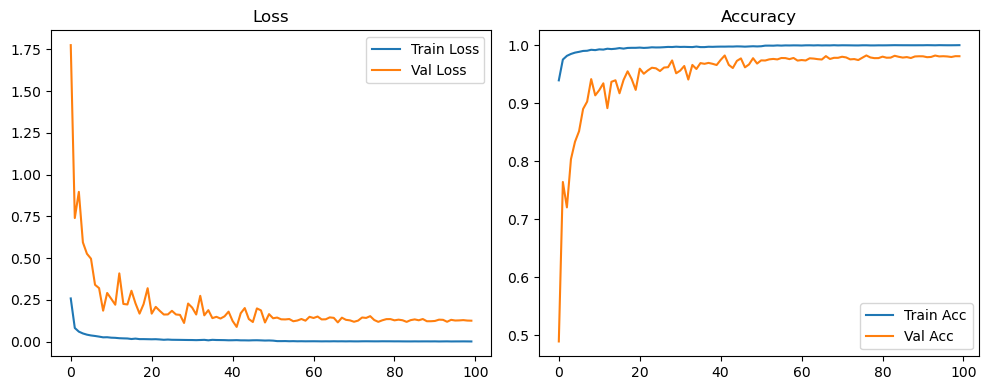

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4577, Acc: 0.8685 | Val Loss: 2.1799, Acc: 0.3215


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1664, Acc: 0.9514 | Val Loss: 1.7989, Acc: 0.4039


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9618 | Val Loss: 1.8168, Acc: 0.4717


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1117, Acc: 0.9664 | Val Loss: 1.5350, Acc: 0.4726


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1038, Acc: 0.9687 | Val Loss: 1.4788, Acc: 0.5475


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9712 | Val Loss: 1.5538, Acc: 0.4967


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9731 | Val Loss: 1.5992, Acc: 0.4800


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9736 | Val Loss: 1.4201, Acc: 0.5543


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9748 | Val Loss: 0.8619, Acc: 0.6773


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9768 | Val Loss: 0.9908, Acc: 0.6633


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9770 | Val Loss: 0.9333, Acc: 0.6687


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9769 | Val Loss: 0.9140, Acc: 0.6890


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9780 | Val Loss: 1.5637, Acc: 0.5179


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9791 | Val Loss: 0.8263, Acc: 0.7043


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9799 | Val Loss: 0.9999, Acc: 0.6590


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9810 | Val Loss: 0.8412, Acc: 0.7033


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9808 | Val Loss: 1.2353, Acc: 0.6248


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9810 | Val Loss: 1.0654, Acc: 0.6460


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9813 | Val Loss: 1.2294, Acc: 0.6252


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9813 | Val Loss: 0.7955, Acc: 0.7263


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9820 | Val Loss: 0.7626, Acc: 0.7506


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9834 | Val Loss: 0.7193, Acc: 0.7566


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9827 | Val Loss: 0.6882, Acc: 0.7592


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9836 | Val Loss: 0.6202, Acc: 0.7837


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9830 | Val Loss: 0.7962, Acc: 0.7367


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9820 | Val Loss: 0.8746, Acc: 0.7223


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9834 | Val Loss: 0.5886, Acc: 0.8008


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9838 | Val Loss: 0.7847, Acc: 0.7317


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 0.9414, Acc: 0.6910


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9838 | Val Loss: 0.9583, Acc: 0.6942


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9835 | Val Loss: 0.5896, Acc: 0.7911


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9850 | Val Loss: 0.7713, Acc: 0.7475


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.6722, Acc: 0.7643


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 0.6593, Acc: 0.7668


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.6709, Acc: 0.7702


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 0.8942, Acc: 0.7163


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9843 | Val Loss: 0.5393, Acc: 0.8151


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.7720, Acc: 0.7260


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9860 | Val Loss: 0.5659, Acc: 0.7967


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.5913, Acc: 0.7859


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9857 | Val Loss: 0.6039, Acc: 0.7912


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9856 | Val Loss: 0.4643, Acc: 0.8356


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.4501, Acc: 0.8360


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.6127, Acc: 0.7758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.6483, Acc: 0.7825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9865 | Val Loss: 0.5578, Acc: 0.7998


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.5898, Acc: 0.7958


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.4378, Acc: 0.8463


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9867 | Val Loss: 0.4807, Acc: 0.8137


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9866 | Val Loss: 0.6730, Acc: 0.7628


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.5319, Acc: 0.8083


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.6113, Acc: 0.7827


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.5520, Acc: 0.8009


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.5349, Acc: 0.7992


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.5574, Acc: 0.7973


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9903 | Val Loss: 0.4623, Acc: 0.8262


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.5735, Acc: 0.7904


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.5778, Acc: 0.7887


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.4915, Acc: 0.8176


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.5028, Acc: 0.8154


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.5581, Acc: 0.7931


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.5904, Acc: 0.7882


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9907 | Val Loss: 0.5213, Acc: 0.8071


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.4704, Acc: 0.8259


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.4745, Acc: 0.8243


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.4798, Acc: 0.8253


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.5044, Acc: 0.8131


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.4856, Acc: 0.8193


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.4865, Acc: 0.8227


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.4650, Acc: 0.8283


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9911 | Val Loss: 0.4428, Acc: 0.8373


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.5014, Acc: 0.8236


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.4661, Acc: 0.8301


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.4706, Acc: 0.8226


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.4514, Acc: 0.8275


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9911 | Val Loss: 0.4684, Acc: 0.8267


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.4802, Acc: 0.8231


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.4498, Acc: 0.8289


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.4478, Acc: 0.8328


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.4185, Acc: 0.8437


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.4421, Acc: 0.8353


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.4007, Acc: 0.8498


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9920 | Val Loss: 0.4258, Acc: 0.8425


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.3833, Acc: 0.8527


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9922 | Val Loss: 0.4246, Acc: 0.8387


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.4134, Acc: 0.8452


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9922 | Val Loss: 0.4131, Acc: 0.8426


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.4080, Acc: 0.8467


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.3852, Acc: 0.8546


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9923 | Val Loss: 0.4118, Acc: 0.8454


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.4129, Acc: 0.8452


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.4384, Acc: 0.8337


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.4104, Acc: 0.8434


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.4089, Acc: 0.8439


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9924 | Val Loss: 0.4541, Acc: 0.8272


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.4251, Acc: 0.8363


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.4313, Acc: 0.8365


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.4640, Acc: 0.8238


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9924 | Val Loss: 0.3784, Acc: 0.8503


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.3784, Acc: 0.8536


Final Test Loss: 0.3652 Accuracy: 0.8567


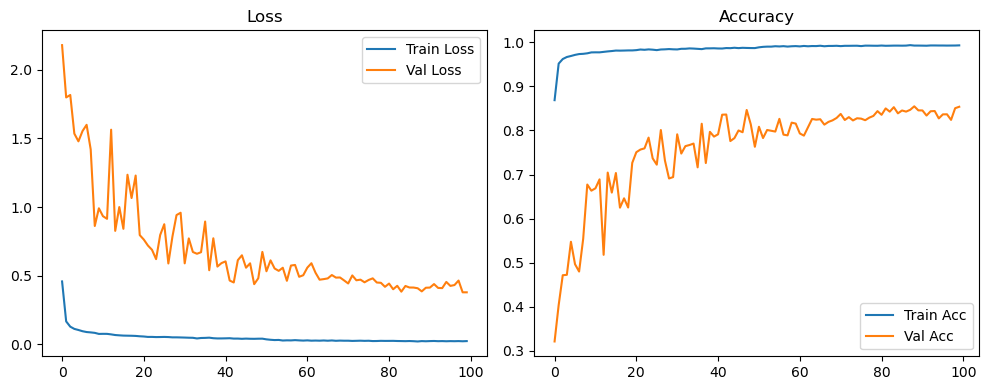

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2695, Acc: 0.9576 | Val Loss: 0.2038, Acc: 0.9430


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9847 | Val Loss: 0.1849, Acc: 0.9423


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9899 | Val Loss: 0.1831, Acc: 0.9447


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9931 | Val Loss: 0.0938, Acc: 0.9708


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9946 | Val Loss: 0.0603, Acc: 0.9810


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9968 | Val Loss: 0.0762, Acc: 0.9772


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.0907, Acc: 0.9702


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.1319, Acc: 0.9599


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1200, Acc: 0.9657


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1968, Acc: 0.9472


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1224, Acc: 0.9677


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1093, Acc: 0.9685


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0536, Acc: 0.9848


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0485, Acc: 0.9861


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0497, Acc: 0.9868


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0539, Acc: 0.9865


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9999 | Val Loss: 0.0673, Acc: 0.9821


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.2364, Acc: 0.9387


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0556, Acc: 0.9851


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0547, Acc: 0.9858


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0878, Acc: 0.9772


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0483, Acc: 0.9882


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9894


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9901


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9899


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9902


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9897


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9896


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.4099, Acc: 0.9103


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0629, Acc: 0.9842


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0565, Acc: 0.9842


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0537, Acc: 0.9867


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0441, Acc: 0.9882


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0525, Acc: 0.9885


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0664, Acc: 0.9840


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0683, Acc: 0.9834


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0648, Acc: 0.9858


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0652, Acc: 0.9858


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0481, Acc: 0.9887


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0538, Acc: 0.9876


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0682, Acc: 0.9870


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0851, Acc: 0.9828


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0632, Acc: 0.9851


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0647, Acc: 0.9856


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0838, Acc: 0.9828


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0646, Acc: 0.9857


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0594, Acc: 0.9889


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0540, Acc: 0.9895


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9892


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0765, Acc: 0.9846


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0828, Acc: 0.9835


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0663, Acc: 0.9872


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0568, Acc: 0.9892


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9896


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9877


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9885


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9891


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0925, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0657, Acc: 0.9863


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9886


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9900


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9896


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9898


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9892


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1260, Acc: 0.9745


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1391, Acc: 0.9761


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0721, Acc: 0.9868


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0601, Acc: 0.9881


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9891


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0599, Acc: 0.9886


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9891


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9891


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9893


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9892


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9893


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9891


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9895


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9895


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9901


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9894


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0708, Acc: 0.9876


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.0756, Acc: 0.9852


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0665, Acc: 0.9866


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9996 | Val Loss: 0.0662, Acc: 0.9875


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0602, Acc: 0.9883


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0675, Acc: 0.9867


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0656, Acc: 0.9873


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0651, Acc: 0.9890


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0812, Acc: 0.9848


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0864, Acc: 0.9851


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0709, Acc: 0.9879


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0657, Acc: 0.9878


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9892


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9895


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9891


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9892


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9892


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1411, Acc: 0.9748


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0778, Acc: 0.9843


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0641, Acc: 0.9892


Final Test Loss: 0.0692 Accuracy: 0.9866


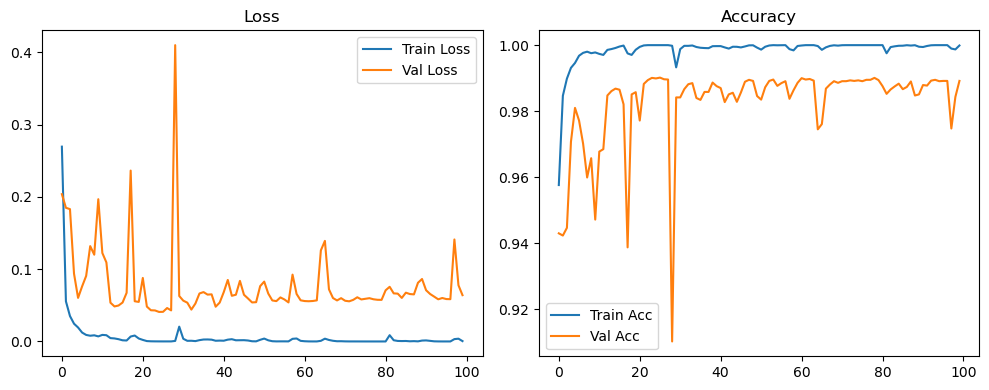

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3339, Acc: 0.9393 | Val Loss: 2.2746, Acc: 0.2917


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0894, Acc: 0.9741 | Val Loss: 1.5985, Acc: 0.4793


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9810 | Val Loss: 1.4001, Acc: 0.5957


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9839 | Val Loss: 1.2876, Acc: 0.6387


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9853 | Val Loss: 1.0331, Acc: 0.6914


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9878 | Val Loss: 0.8329, Acc: 0.7212


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.7231, Acc: 0.7716


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.8402, Acc: 0.7715


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.7213, Acc: 0.7947


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.5521, Acc: 0.8433


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.3640, Acc: 0.8836


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.4030, Acc: 0.8728


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.6313, Acc: 0.8111


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.6215, Acc: 0.8257


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.6412, Acc: 0.8373


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.6748, Acc: 0.8288


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.4808, Acc: 0.8669


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.4941, Acc: 0.8614


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.6008, Acc: 0.8384


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.5512, Acc: 0.8531


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.4650, Acc: 0.8825


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.5330, Acc: 0.8538


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.4405, Acc: 0.8841


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.4160, Acc: 0.8968


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.3253, Acc: 0.9143


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.3571, Acc: 0.9102


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.3528, Acc: 0.9106


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.1817, Acc: 0.9510


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.3544, Acc: 0.9117


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.5509, Acc: 0.8678


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1954, Acc: 0.9474


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.4321, Acc: 0.8908


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.2519, Acc: 0.9358


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.2048, Acc: 0.9470


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.3444, Acc: 0.9158


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1590, Acc: 0.9599


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1883, Acc: 0.9512


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1424, Acc: 0.9629


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.2173, Acc: 0.9487


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.2598, Acc: 0.9401


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.2048, Acc: 0.9513


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1859, Acc: 0.9523


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.2115, Acc: 0.9524


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1786, Acc: 0.9554


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1935, Acc: 0.9529


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.2668, Acc: 0.9385


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.2773, Acc: 0.9360


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.2266, Acc: 0.9465


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.2093, Acc: 0.9497


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.2629, Acc: 0.9371


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.2616, Acc: 0.9382


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.3333, Acc: 0.9281


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1807, Acc: 0.9597


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1491, Acc: 0.9654


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1677, Acc: 0.9631


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1616, Acc: 0.9647


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1929, Acc: 0.9562


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1918, Acc: 0.9578


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1838, Acc: 0.9599


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.2204, Acc: 0.9533


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1826, Acc: 0.9603


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1545, Acc: 0.9662


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.2045, Acc: 0.9571


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1621, Acc: 0.9653


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1785, Acc: 0.9607


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1735, Acc: 0.9613


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1971, Acc: 0.9596


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2410, Acc: 0.9497


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1788, Acc: 0.9617


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1713, Acc: 0.9652


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.2554, Acc: 0.9476


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1613, Acc: 0.9663


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1699, Acc: 0.9633


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1728, Acc: 0.9635


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1544, Acc: 0.9673


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1543, Acc: 0.9649


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1426, Acc: 0.9692


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1406, Acc: 0.9696


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1173, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.1799, Acc: 0.9628


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1287, Acc: 0.9733


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1896, Acc: 0.9598


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1538, Acc: 0.9678


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1743, Acc: 0.9644


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1538, Acc: 0.9700


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.2146, Acc: 0.9577


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1726, Acc: 0.9651


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1457, Acc: 0.9680


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1814, Acc: 0.9629


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1646, Acc: 0.9674


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1596, Acc: 0.9699


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2395, Acc: 0.9514


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1653, Acc: 0.9655


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1476, Acc: 0.9693


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2125, Acc: 0.9568


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.2203, Acc: 0.9558


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1652, Acc: 0.9667


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1696, Acc: 0.9668


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1505, Acc: 0.9701


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1466, Acc: 0.9712


Final Test Loss: 0.1694 Accuracy: 0.9685


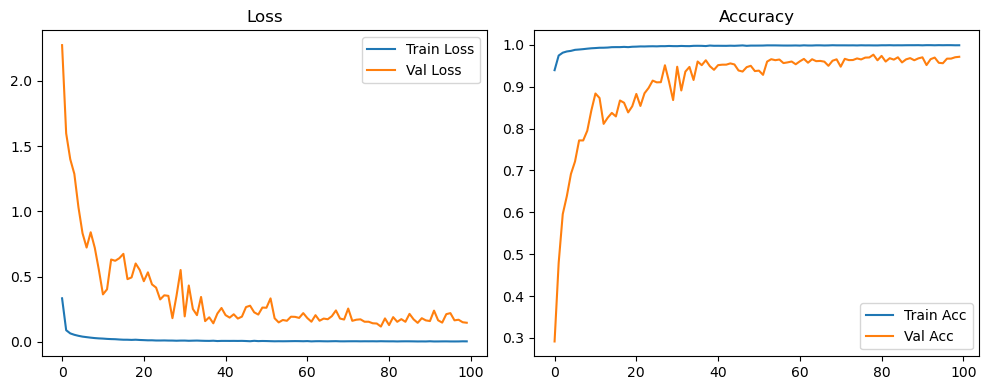

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5837, Acc: 0.8464 | Val Loss: 2.6480, Acc: 0.2213


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1945, Acc: 0.9435 | Val Loss: 2.3182, Acc: 0.2968


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1445, Acc: 0.9581 | Val Loss: 2.4744, Acc: 0.2909


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1238, Acc: 0.9639 | Val Loss: 2.4801, Acc: 0.3079


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1094, Acc: 0.9677 | Val Loss: 2.6709, Acc: 0.3350


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1031, Acc: 0.9694 | Val Loss: 2.1459, Acc: 0.3738


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0940, Acc: 0.9714 | Val Loss: 1.8531, Acc: 0.4404


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0887, Acc: 0.9732 | Val Loss: 2.1190, Acc: 0.4310


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0855, Acc: 0.9747 | Val Loss: 1.3815, Acc: 0.5971


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9756 | Val Loss: 1.4898, Acc: 0.5682


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0795, Acc: 0.9753 | Val Loss: 1.6125, Acc: 0.5282


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9765 | Val Loss: 1.1724, Acc: 0.6351


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9778 | Val Loss: 2.0366, Acc: 0.4462


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9788 | Val Loss: 1.5555, Acc: 0.5604


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9791 | Val Loss: 1.4758, Acc: 0.5911


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0664, Acc: 0.9800 | Val Loss: 1.5651, Acc: 0.5477


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9795 | Val Loss: 1.5137, Acc: 0.5642


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9799 | Val Loss: 1.0771, Acc: 0.6930


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9808 | Val Loss: 1.6877, Acc: 0.5396


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0599, Acc: 0.9818 | Val Loss: 1.5166, Acc: 0.5859


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9816 | Val Loss: 1.3957, Acc: 0.6417


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9825 | Val Loss: 1.1510, Acc: 0.7071


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9825 | Val Loss: 1.0895, Acc: 0.6890


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9821 | Val Loss: 1.1627, Acc: 0.6685


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9823 | Val Loss: 1.3254, Acc: 0.6206


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9829 | Val Loss: 1.5017, Acc: 0.6176


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9839 | Val Loss: 1.1298, Acc: 0.6717


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9837 | Val Loss: 1.6578, Acc: 0.5514


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 1.6911, Acc: 0.5369


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9833 | Val Loss: 1.7261, Acc: 0.5453


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9831 | Val Loss: 1.3630, Acc: 0.6382


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 1.2555, Acc: 0.6263


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9836 | Val Loss: 1.0166, Acc: 0.7014


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9845 | Val Loss: 1.1552, Acc: 0.6776


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 1.1011, Acc: 0.6576


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 1.4067, Acc: 0.6222


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9843 | Val Loss: 1.1031, Acc: 0.6677


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9851 | Val Loss: 1.2663, Acc: 0.6189


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9856 | Val Loss: 1.2103, Acc: 0.6586


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9855 | Val Loss: 0.9738, Acc: 0.6939


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.9361, Acc: 0.7200


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 0.8495, Acc: 0.7502


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9852 | Val Loss: 1.0523, Acc: 0.6822


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 1.1447, Acc: 0.6687


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9853 | Val Loss: 1.1268, Acc: 0.6646


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 1.3026, Acc: 0.6207


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 1.3026, Acc: 0.6143


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9866 | Val Loss: 1.1864, Acc: 0.6677


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 1.2289, Acc: 0.6368


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9867 | Val Loss: 1.3313, Acc: 0.6318


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9863 | Val Loss: 1.1225, Acc: 0.6756


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9866 | Val Loss: 1.4277, Acc: 0.5907


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 1.2850, Acc: 0.6491


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 1.1737, Acc: 0.6360


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 1.3315, Acc: 0.6282


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 1.1738, Acc: 0.6477


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9878 | Val Loss: 1.3819, Acc: 0.6011


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 1.7171, Acc: 0.5248


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 1.2698, Acc: 0.6126


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.8830, Acc: 0.7192


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9865 | Val Loss: 1.2219, Acc: 0.6286


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9874 | Val Loss: 1.1611, Acc: 0.6457


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 1.0451, Acc: 0.6871


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9879 | Val Loss: 1.1554, Acc: 0.6713


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9878 | Val Loss: 0.9859, Acc: 0.6732


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.9416, Acc: 0.6973


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.9866, Acc: 0.6795


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.9231, Acc: 0.6977


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 1.0119, Acc: 0.6752


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.7776, Acc: 0.7260


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.8944, Acc: 0.6804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.8301, Acc: 0.7019


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.8820, Acc: 0.6825


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9885 | Val Loss: 0.8662, Acc: 0.6749


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9881 | Val Loss: 0.8797, Acc: 0.6887


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9877 | Val Loss: 0.9911, Acc: 0.6544


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9885 | Val Loss: 1.0334, Acc: 0.6369


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.8669, Acc: 0.7007


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 0.8872, Acc: 0.6772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9895 | Val Loss: 0.9875, Acc: 0.6672


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.7570, Acc: 0.7170


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.7392, Acc: 0.7298


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.8157, Acc: 0.7103


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.8408, Acc: 0.6979


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9886 | Val Loss: 1.1522, Acc: 0.6142


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9893 | Val Loss: 0.8616, Acc: 0.6923


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.8074, Acc: 0.7074


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.8573, Acc: 0.6978


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.8093, Acc: 0.7009


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.8130, Acc: 0.6931


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.6771, Acc: 0.7402


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9889 | Val Loss: 0.8270, Acc: 0.6989


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.8052, Acc: 0.7059


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.8657, Acc: 0.6870


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9895 | Val Loss: 0.8103, Acc: 0.6860


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.7796, Acc: 0.6907


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.8303, Acc: 0.6803


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 0.8473, Acc: 0.6938


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.6710, Acc: 0.7350


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.7452, Acc: 0.7092


Final Test Loss: 0.7190 Accuracy: 0.7195


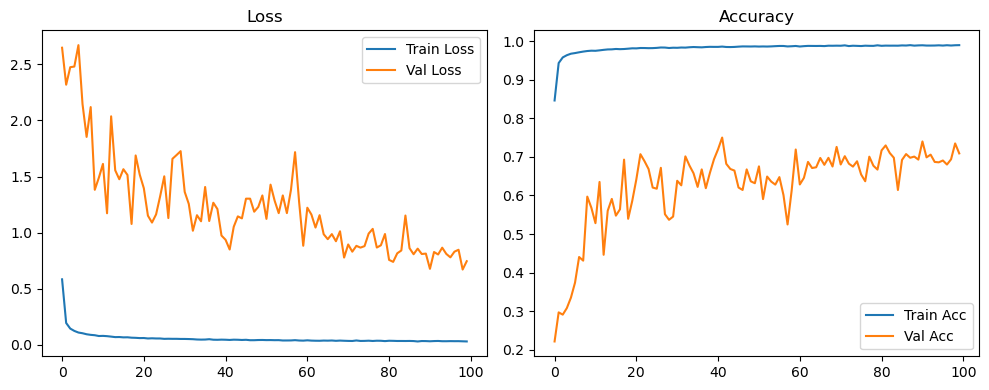

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2697, Acc: 0.9579 | Val Loss: 0.2040, Acc: 0.9430


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9845 | Val Loss: 0.1944, Acc: 0.9403


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9899 | Val Loss: 0.1285, Acc: 0.9651


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9931 | Val Loss: 0.0716, Acc: 0.9782


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.1043, Acc: 0.9680


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.0479, Acc: 0.9851


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1058, Acc: 0.9671


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.0875, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0597, Acc: 0.9818


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.3252, Acc: 0.9069


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0902, Acc: 0.9764


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0603, Acc: 0.9840


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0530, Acc: 0.9854


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0689, Acc: 0.9818


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0558, Acc: 0.9852


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0624, Acc: 0.9842


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0715, Acc: 0.9816


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0782, Acc: 0.9812


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.2218, Acc: 0.9461


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0522, Acc: 0.9862


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0501, Acc: 0.9889


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0491, Acc: 0.9882


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0722, Acc: 0.9822


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0511, Acc: 0.9882


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.3015, Acc: 0.9318


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9961 | Val Loss: 0.0598, Acc: 0.9864


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0558, Acc: 0.9868


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0493, Acc: 0.9898


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0560, Acc: 0.9873


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9902


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9899


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9901


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9897


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0741, Acc: 0.9822


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0633, Acc: 0.9873


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0608, Acc: 0.9863


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0504, Acc: 0.9892


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9896


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9899


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9898


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9902


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9897


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0859, Acc: 0.9813


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0699, Acc: 0.9847


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0574, Acc: 0.9872


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9896


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9892


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0571, Acc: 0.9875


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0566, Acc: 0.9879


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1124, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0604, Acc: 0.9885


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0542, Acc: 0.9883


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9900


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9900


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9900


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9903


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9901


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9898


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9899


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9903


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9903


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9907


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9904


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9903


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9905


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9905


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9902


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9908


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9902


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9826


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0588, Acc: 0.9890


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9887


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0533, Acc: 0.9902


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9901


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9906


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9904


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9892


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0557, Acc: 0.9900


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9901


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9900


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9903


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9904


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9902


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9900


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9900


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9903


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9902


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9903


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9903


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9903


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9905


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9908


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9905


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9898


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9900


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9903


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9902


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9897


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9904


Final Test Loss: 0.0588 Accuracy: 0.9889


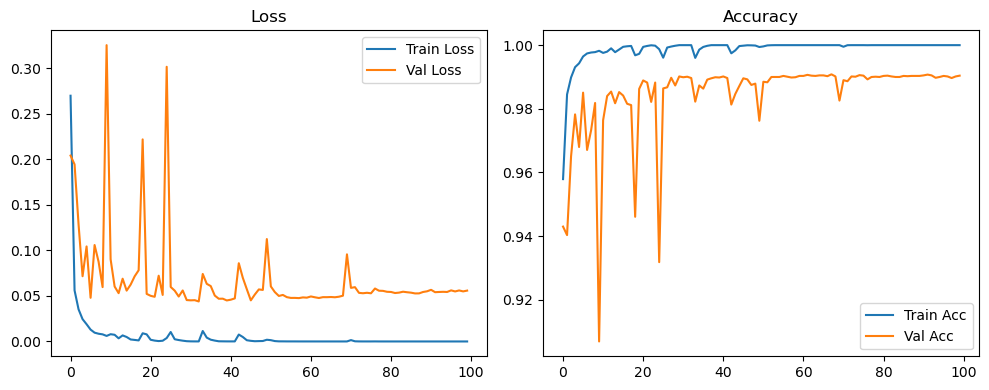

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3343, Acc: 0.9397 | Val Loss: 2.4064, Acc: 0.2977


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9740 | Val Loss: 1.3008, Acc: 0.5533


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9813 | Val Loss: 1.2440, Acc: 0.6377


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9832 | Val Loss: 1.3302, Acc: 0.6367


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9855 | Val Loss: 1.0601, Acc: 0.6797


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.8026, Acc: 0.7397


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9885 | Val Loss: 0.7390, Acc: 0.7839


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.9125, Acc: 0.7828


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.8182, Acc: 0.7766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.4191, Acc: 0.8772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.6025, Acc: 0.8143


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.4904, Acc: 0.8502


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.7474, Acc: 0.7963


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.2972, Acc: 0.9088


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.5573, Acc: 0.8424


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.6684, Acc: 0.8273


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9939 | Val Loss: 0.5693, Acc: 0.8448


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.6019, Acc: 0.8461


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.4389, Acc: 0.8854


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.5294, Acc: 0.8698


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.3257, Acc: 0.9096


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.5221, Acc: 0.8753


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.4115, Acc: 0.8943


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.3784, Acc: 0.9033


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.3196, Acc: 0.9143


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.3189, Acc: 0.9194


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.2398, Acc: 0.9378


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1951, Acc: 0.9473


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.2435, Acc: 0.9373


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.2649, Acc: 0.9333


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9966 | Val Loss: 0.3399, Acc: 0.9181


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.2692, Acc: 0.9349


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.3307, Acc: 0.9183


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1796, Acc: 0.9570


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.3476, Acc: 0.9203


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.1815, Acc: 0.9546


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1416, Acc: 0.9657


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9963 | Val Loss: 0.2201, Acc: 0.9467


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.2447, Acc: 0.9425


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1951, Acc: 0.9546


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.2151, Acc: 0.9510


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.2184, Acc: 0.9490


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.2421, Acc: 0.9440


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.2704, Acc: 0.9388


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.2851, Acc: 0.9345


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1866, Acc: 0.9558


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.2429, Acc: 0.9474


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.2226, Acc: 0.9500


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1684, Acc: 0.9609


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1743, Acc: 0.9607


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1643, Acc: 0.9650


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1974, Acc: 0.9568


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1533, Acc: 0.9673


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1302, Acc: 0.9716


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1446, Acc: 0.9692


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1335, Acc: 0.9706


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1441, Acc: 0.9688


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1488, Acc: 0.9676


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1431, Acc: 0.9698


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1591, Acc: 0.9656


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1721, Acc: 0.9623


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1603, Acc: 0.9656


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1600, Acc: 0.9665


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1725, Acc: 0.9633


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1619, Acc: 0.9655


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1779, Acc: 0.9627


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1496, Acc: 0.9687


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1994, Acc: 0.9599


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1496, Acc: 0.9691


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1661, Acc: 0.9657


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2262, Acc: 0.9535


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2003, Acc: 0.9600


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1805, Acc: 0.9623


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1887, Acc: 0.9613


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1853, Acc: 0.9617


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1681, Acc: 0.9658


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1800, Acc: 0.9633


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1777, Acc: 0.9643


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1609, Acc: 0.9685


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1896, Acc: 0.9624


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1550, Acc: 0.9683


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1607, Acc: 0.9668


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1657, Acc: 0.9663


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1469, Acc: 0.9692


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1440, Acc: 0.9703


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1710, Acc: 0.9656


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1502, Acc: 0.9701


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1717, Acc: 0.9669


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1674, Acc: 0.9662


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1555, Acc: 0.9700


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1510, Acc: 0.9692


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1574, Acc: 0.9684


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1787, Acc: 0.9650


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1557, Acc: 0.9698


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1785, Acc: 0.9639


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1865, Acc: 0.9643


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1794, Acc: 0.9651


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1667, Acc: 0.9678


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1731, Acc: 0.9674


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1608, Acc: 0.9690


Final Test Loss: 0.1874 Accuracy: 0.9660


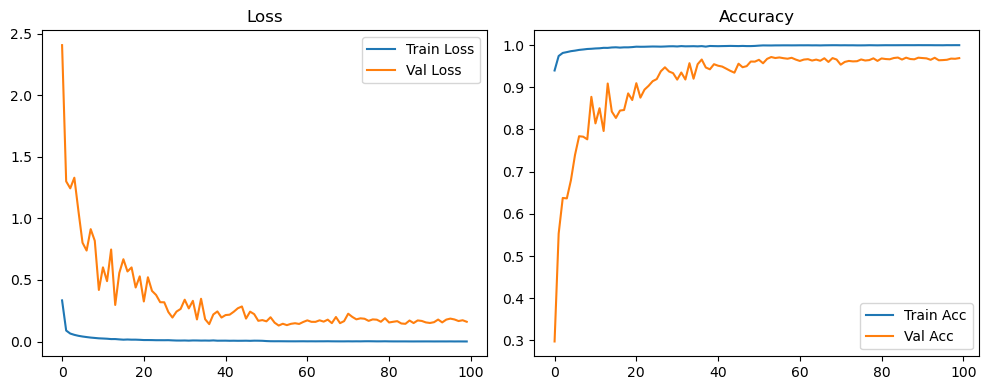

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5837, Acc: 0.8464 | Val Loss: 2.5417, Acc: 0.2285


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1935, Acc: 0.9437 | Val Loss: 2.1959, Acc: 0.3207


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1437, Acc: 0.9581 | Val Loss: 2.3345, Acc: 0.3220


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1223, Acc: 0.9645 | Val Loss: 2.3571, Acc: 0.3421


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1089, Acc: 0.9676 | Val Loss: 2.8324, Acc: 0.3302


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1025, Acc: 0.9696 | Val Loss: 2.3735, Acc: 0.3625


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9710 | Val Loss: 2.0985, Acc: 0.4078


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9732 | Val Loss: 2.2559, Acc: 0.4000


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9743 | Val Loss: 1.7868, Acc: 0.4786


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0786, Acc: 0.9760 | Val Loss: 1.6329, Acc: 0.5282


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9747 | Val Loss: 1.9642, Acc: 0.4389


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0773, Acc: 0.9767 | Val Loss: 1.5224, Acc: 0.5499


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9776 | Val Loss: 2.1677, Acc: 0.4141


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9792 | Val Loss: 1.5638, Acc: 0.5462


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9793 | Val Loss: 1.3421, Acc: 0.6145


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9802 | Val Loss: 1.7602, Acc: 0.5009


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9799 | Val Loss: 1.4577, Acc: 0.5825


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9800 | Val Loss: 1.1278, Acc: 0.6873


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9808 | Val Loss: 1.5439, Acc: 0.5719


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9810 | Val Loss: 1.1890, Acc: 0.6607


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9808 | Val Loss: 1.2721, Acc: 0.6706


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9825 | Val Loss: 1.1685, Acc: 0.6943


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9817 | Val Loss: 0.9414, Acc: 0.7078


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9824 | Val Loss: 1.1464, Acc: 0.6745


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9820 | Val Loss: 1.1535, Acc: 0.6687


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9828 | Val Loss: 1.3438, Acc: 0.6448


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9840 | Val Loss: 1.2175, Acc: 0.6555


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9826 | Val Loss: 1.4324, Acc: 0.5975


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9831 | Val Loss: 1.7235, Acc: 0.5372


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9831 | Val Loss: 1.7626, Acc: 0.5423


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9834 | Val Loss: 1.5462, Acc: 0.5760


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9842 | Val Loss: 1.6004, Acc: 0.5615


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 1.6097, Acc: 0.5813


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9842 | Val Loss: 1.6004, Acc: 0.5846


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9844 | Val Loss: 1.4337, Acc: 0.5839


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9841 | Val Loss: 1.5009, Acc: 0.5837


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9838 | Val Loss: 1.1090, Acc: 0.6656


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9847 | Val Loss: 1.2535, Acc: 0.6438


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9855 | Val Loss: 1.2798, Acc: 0.6529


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9857 | Val Loss: 1.1495, Acc: 0.6544


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9855 | Val Loss: 1.0744, Acc: 0.6833


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9854 | Val Loss: 0.9115, Acc: 0.7354


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9858 | Val Loss: 1.1279, Acc: 0.6723


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 1.2761, Acc: 0.6153


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 1.2032, Acc: 0.6427


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9848 | Val Loss: 1.0265, Acc: 0.6711


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 1.1812, Acc: 0.6563


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 1.0859, Acc: 0.6729


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9856 | Val Loss: 0.9109, Acc: 0.7019


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9866 | Val Loss: 1.0750, Acc: 0.6765


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9863 | Val Loss: 1.0674, Acc: 0.6927


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 1.2792, Acc: 0.6384


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 1.0493, Acc: 0.6926


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 1.0607, Acc: 0.6825


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 1.0908, Acc: 0.6873


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 1.0297, Acc: 0.6967


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 1.1612, Acc: 0.6575


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 1.2749, Acc: 0.6323


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 1.1769, Acc: 0.6455


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 1.0300, Acc: 0.6907


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 1.3806, Acc: 0.5991


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9897 | Val Loss: 1.2163, Acc: 0.6377


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.9950, Acc: 0.6858


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 1.0717, Acc: 0.6659


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 1.0588, Acc: 0.6595


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.9585, Acc: 0.6923


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 1.1013, Acc: 0.6638


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 1.1904, Acc: 0.6423


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 1.0697, Acc: 0.6813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 1.0076, Acc: 0.6872


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.9860, Acc: 0.6946


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 1.0933, Acc: 0.6627


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 1.1365, Acc: 0.6365


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 1.0926, Acc: 0.6387


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9896 | Val Loss: 1.0805, Acc: 0.6518


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 1.0073, Acc: 0.6672


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 1.0034, Acc: 0.6688


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.9200, Acc: 0.7018


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.9919, Acc: 0.6792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.9822, Acc: 0.6827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.9596, Acc: 0.6869


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.8465, Acc: 0.7173


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.9908, Acc: 0.6885


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9910 | Val Loss: 0.9164, Acc: 0.6956


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.9783, Acc: 0.6822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.9531, Acc: 0.6861


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.8916, Acc: 0.7023


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.9870, Acc: 0.6812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9910 | Val Loss: 0.8927, Acc: 0.6973


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.9599, Acc: 0.6849


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9910 | Val Loss: 0.9236, Acc: 0.6943


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.9051, Acc: 0.6942


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.8394, Acc: 0.7223


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9914 | Val Loss: 0.8540, Acc: 0.7143


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.8012, Acc: 0.7209


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9903 | Val Loss: 0.8809, Acc: 0.7031


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.7557, Acc: 0.7392


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.9738, Acc: 0.6848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.8065, Acc: 0.7212


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9910 | Val Loss: 0.8416, Acc: 0.7177


Final Test Loss: 0.8084 Accuracy: 0.7275


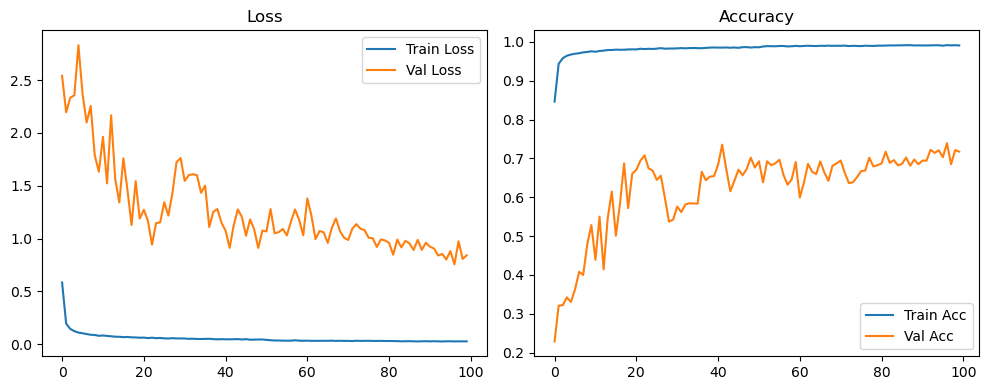

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4470, Acc: 0.9579 | Val Loss: 0.2548, Acc: 0.9448


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0774, Acc: 0.9851 | Val Loss: 0.1199, Acc: 0.9710


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9905 | Val Loss: 0.1464, Acc: 0.9592


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9933 | Val Loss: 0.1534, Acc: 0.9501


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9953 | Val Loss: 0.0806, Acc: 0.9741


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9976 | Val Loss: 0.0741, Acc: 0.9768


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9979 | Val Loss: 0.1032, Acc: 0.9702


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9988 | Val Loss: 0.0873, Acc: 0.9744


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9984 | Val Loss: 0.1809, Acc: 0.9424


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9985 | Val Loss: 0.0655, Acc: 0.9781


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9989 | Val Loss: 0.1404, Acc: 0.9597


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9996 | Val Loss: 0.0621, Acc: 0.9820


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.3810, Acc: 0.8876


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.0635, Acc: 0.9815


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.2704, Acc: 0.9230


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9995 | Val Loss: 0.0903, Acc: 0.9754


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9997 | Val Loss: 0.0546, Acc: 0.9841


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0721, Acc: 0.9798


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.5274, Acc: 0.8515


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0606, Acc: 0.9841


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0794, Acc: 0.9781


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9998 | Val Loss: 0.0704, Acc: 0.9812


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9886


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9895


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9885


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9893


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9892


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9890


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9892


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9892


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9895


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9892


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9892


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9895


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9891


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9896


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9891


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9892


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9892


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9889


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9893


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9897


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9969 | Val Loss: 1.6369, Acc: 0.6489


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0675, Acc: 0.9831


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0739, Acc: 0.9808


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0452, Acc: 0.9888


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0552, Acc: 0.9874


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9882


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9885


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9889


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9889


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9891


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9897


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9889


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9889


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9895


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9898


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9892


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1120, Acc: 0.9735


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.0561, Acc: 0.9861


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0472, Acc: 0.9888


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0467, Acc: 0.9888


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0476, Acc: 0.9883


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9894


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9900


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9892


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9889


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9898


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0902, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0695, Acc: 0.9815


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0489, Acc: 0.9876


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9884


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9889


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9892


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9892


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9891


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0649, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0589, Acc: 0.9865


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0473, Acc: 0.9886


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9892


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9898


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9894


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9895


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.3324, Acc: 0.9231


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1146, Acc: 0.9732


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0545, Acc: 0.9885


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0560, Acc: 0.9888


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9892


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9889


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9893


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9887


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9890


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9892


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0533, Acc: 0.9888


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9888


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9888


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9893


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9891


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9891


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9894


Final Test Loss: 0.0529 Accuracy: 0.9881


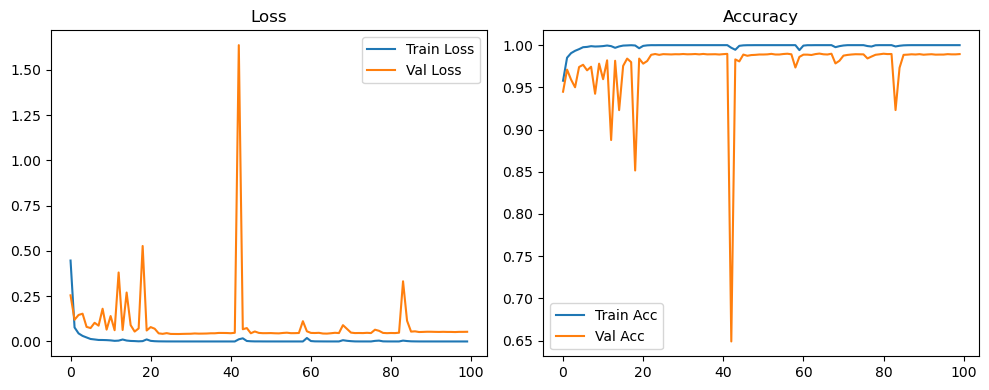

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5410, Acc: 0.9316 | Val Loss: 2.0057, Acc: 0.2522


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1233, Acc: 0.9725 | Val Loss: 0.9498, Acc: 0.6645


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0820, Acc: 0.9792 | Val Loss: 1.2143, Acc: 0.6206


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0669, Acc: 0.9818 | Val Loss: 2.0547, Acc: 0.4103


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9837 | Val Loss: 1.6535, Acc: 0.5211


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9856 | Val Loss: 1.6980, Acc: 0.5373


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9871 | Val Loss: 1.5196, Acc: 0.6107


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 1.6432, Acc: 0.5937


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 1.3390, Acc: 0.6482


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9902 | Val Loss: 0.9038, Acc: 0.7394


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 1.0462, Acc: 0.6761


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 1.4729, Acc: 0.6105


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9920 | Val Loss: 1.4109, Acc: 0.6595


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.9374, Acc: 0.7318


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 1.2947, Acc: 0.6985


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 1.2493, Acc: 0.7007


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 1.4082, Acc: 0.6248


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 1.3145, Acc: 0.6551


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 1.1692, Acc: 0.7255


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 1.2984, Acc: 0.6674


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.8580, Acc: 0.8083


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 1.1685, Acc: 0.7236


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.7473, Acc: 0.8093


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.6858, Acc: 0.8314


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.8910, Acc: 0.7782


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.7937, Acc: 0.8029


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.7544, Acc: 0.8252


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.5842, Acc: 0.8375


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.6914, Acc: 0.8389


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.9112, Acc: 0.7929


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.8610, Acc: 0.7987


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.8899, Acc: 0.7938


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.7118, Acc: 0.8249


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.7645, Acc: 0.8203


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.5893, Acc: 0.8526


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.9308, Acc: 0.7802


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.5805, Acc: 0.8519


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.8261, Acc: 0.8178


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.8986, Acc: 0.8025


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.8470, Acc: 0.8147


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.6923, Acc: 0.8320


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.6824, Acc: 0.8473


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.8815, Acc: 0.8235


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.6910, Acc: 0.8387


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.8005, Acc: 0.8196


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.8700, Acc: 0.8153


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.9879, Acc: 0.8037


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.5351, Acc: 0.8833


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.6266, Acc: 0.8681


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.5689, Acc: 0.8630


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.5689, Acc: 0.8645


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.6832, Acc: 0.8569


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.4179, Acc: 0.9032


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.4805, Acc: 0.8934


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.5162, Acc: 0.8862


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.4520, Acc: 0.8953


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.5408, Acc: 0.8772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.4786, Acc: 0.8887


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.4759, Acc: 0.8931


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.5068, Acc: 0.8833


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.3773, Acc: 0.9107


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.5105, Acc: 0.8850


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.4486, Acc: 0.8991


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.3868, Acc: 0.9162


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.3915, Acc: 0.9107


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.4167, Acc: 0.9069


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.3506, Acc: 0.9192


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.3909, Acc: 0.9159


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.3850, Acc: 0.9127


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.4598, Acc: 0.8998


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.5924, Acc: 0.8758


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.5131, Acc: 0.8878


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.6845, Acc: 0.8629


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.5509, Acc: 0.8870


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.6706, Acc: 0.8632


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.5109, Acc: 0.8928


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.4921, Acc: 0.8961


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.3969, Acc: 0.9179


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.4918, Acc: 0.8991


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.5543, Acc: 0.8799


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.4720, Acc: 0.9068


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.4116, Acc: 0.9167


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.4828, Acc: 0.9017


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.4311, Acc: 0.9127


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.3878, Acc: 0.9193


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.4189, Acc: 0.9115


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.3397, Acc: 0.9287


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.3540, Acc: 0.9259


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.3272, Acc: 0.9268


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.4042, Acc: 0.9133


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.4213, Acc: 0.9085


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.4174, Acc: 0.9144


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.4203, Acc: 0.9101


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.4720, Acc: 0.9050


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.4296, Acc: 0.9128


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.4992, Acc: 0.9018


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.4056, Acc: 0.9178


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.3458, Acc: 0.9279


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2750, Acc: 0.9400


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.3537, Acc: 0.9297


Final Test Loss: 0.3546 Accuracy: 0.9343


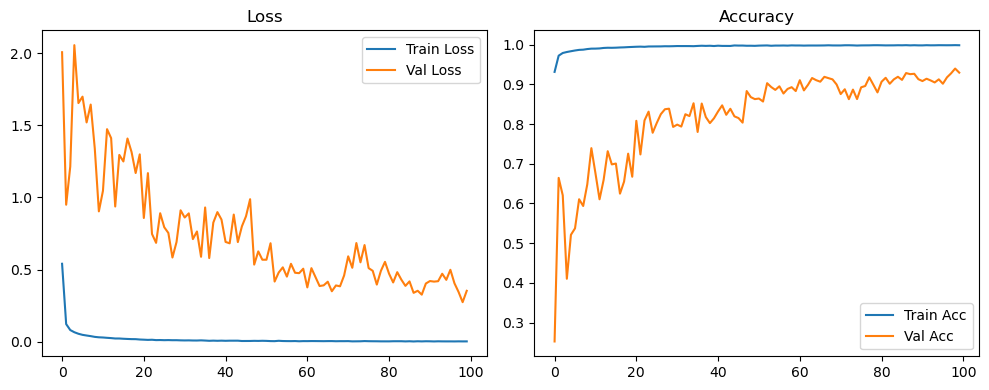

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.8717, Acc: 0.7919 | Val Loss: 3.0329, Acc: 0.1698


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2954, Acc: 0.9228 | Val Loss: 2.7636, Acc: 0.2357


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1985, Acc: 0.9463 | Val Loss: 2.7218, Acc: 0.2592


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1612, Acc: 0.9539 | Val Loss: 3.0331, Acc: 0.2333


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1382, Acc: 0.9604 | Val Loss: 3.2756, Acc: 0.2445


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1246, Acc: 0.9639 | Val Loss: 3.3514, Acc: 0.2497


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1153, Acc: 0.9653 | Val Loss: 3.3819, Acc: 0.2370


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1046, Acc: 0.9694 | Val Loss: 3.4243, Acc: 0.2318


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1028, Acc: 0.9692 | Val Loss: 3.0570, Acc: 0.2706


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0942, Acc: 0.9717 | Val Loss: 3.1069, Acc: 0.2722


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0927, Acc: 0.9729 | Val Loss: 3.0809, Acc: 0.3050


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0859, Acc: 0.9739 | Val Loss: 3.0863, Acc: 0.3182


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0812, Acc: 0.9757 | Val Loss: 3.0017, Acc: 0.3307


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0804, Acc: 0.9757 | Val Loss: 2.8560, Acc: 0.3383


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0770, Acc: 0.9761 | Val Loss: 2.3144, Acc: 0.4012


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0747, Acc: 0.9782 | Val Loss: 2.3030, Acc: 0.3945


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0754, Acc: 0.9770 | Val Loss: 2.3417, Acc: 0.3849


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 2.1611, Acc: 0.4279


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0709, Acc: 0.9791 | Val Loss: 2.3441, Acc: 0.4255


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9796 | Val Loss: 2.4319, Acc: 0.3985


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0668, Acc: 0.9796 | Val Loss: 2.0507, Acc: 0.4788


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9805 | Val Loss: 2.0138, Acc: 0.4784


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9808 | Val Loss: 1.6050, Acc: 0.5402


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 1.4950, Acc: 0.5960


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9807 | Val Loss: 1.8258, Acc: 0.5056


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9818 | Val Loss: 1.6039, Acc: 0.5799


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9821 | Val Loss: 1.4967, Acc: 0.5626


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9817 | Val Loss: 1.7161, Acc: 0.5044


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9815 | Val Loss: 2.0297, Acc: 0.4587


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9820 | Val Loss: 1.7103, Acc: 0.5132


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9826 | Val Loss: 1.8071, Acc: 0.5120


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0552, Acc: 0.9834 | Val Loss: 1.4627, Acc: 0.5868


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 1.7083, Acc: 0.5294


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 1.4784, Acc: 0.6042


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 1.4811, Acc: 0.5701


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9844 | Val Loss: 1.3933, Acc: 0.6141


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9831 | Val Loss: 0.9733, Acc: 0.7080


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9839 | Val Loss: 1.2641, Acc: 0.6479


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9840 | Val Loss: 1.1196, Acc: 0.7024


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 1.1337, Acc: 0.6551


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9838 | Val Loss: 1.1438, Acc: 0.6742


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 1.0982, Acc: 0.6882


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9841 | Val Loss: 1.0298, Acc: 0.7018


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9844 | Val Loss: 1.0501, Acc: 0.6807


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.9203, Acc: 0.7000


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9844 | Val Loss: 1.2439, Acc: 0.6358


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 1.1452, Acc: 0.6679


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9849 | Val Loss: 1.4679, Acc: 0.5813


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9849 | Val Loss: 1.4395, Acc: 0.5990


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9856 | Val Loss: 1.3222, Acc: 0.6497


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9846 | Val Loss: 1.0301, Acc: 0.7059


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 1.4139, Acc: 0.6215


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 1.2696, Acc: 0.6508


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 1.2044, Acc: 0.6512


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9857 | Val Loss: 1.1503, Acc: 0.6723


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9860 | Val Loss: 1.4717, Acc: 0.5888


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 1.4122, Acc: 0.6083


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 1.5519, Acc: 0.5779


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 1.3678, Acc: 0.6246


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9863 | Val Loss: 1.0983, Acc: 0.7053


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9858 | Val Loss: 1.4672, Acc: 0.5867


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 1.2801, Acc: 0.6284


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 1.2642, Acc: 0.6425


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9863 | Val Loss: 1.1485, Acc: 0.6690


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9868 | Val Loss: 1.1982, Acc: 0.6437


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9870 | Val Loss: 1.3696, Acc: 0.6298


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9871 | Val Loss: 1.2885, Acc: 0.6178


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 1.5748, Acc: 0.5868


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9868 | Val Loss: 1.4417, Acc: 0.6076


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 1.0700, Acc: 0.6864


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9873 | Val Loss: 1.1855, Acc: 0.6651


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 1.2144, Acc: 0.6587


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 1.2550, Acc: 0.6483


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 1.1262, Acc: 0.6514


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9867 | Val Loss: 1.2859, Acc: 0.6251


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9866 | Val Loss: 1.4517, Acc: 0.6050


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 1.3872, Acc: 0.6017


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.9440, Acc: 0.6991


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 1.0122, Acc: 0.6740


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9879 | Val Loss: 1.0758, Acc: 0.6763


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.9448, Acc: 0.6993


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 1.2008, Acc: 0.6441


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 1.2355, Acc: 0.6610


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9871 | Val Loss: 0.9945, Acc: 0.6907


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 1.3485, Acc: 0.6172


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 1.3220, Acc: 0.6236


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.8925, Acc: 0.7173


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9879 | Val Loss: 1.0264, Acc: 0.6803


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9882 | Val Loss: 0.9381, Acc: 0.7046


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.9899, Acc: 0.7057


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9879 | Val Loss: 1.0984, Acc: 0.6758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.9652, Acc: 0.6967


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 1.1479, Acc: 0.6633


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9884 | Val Loss: 1.2680, Acc: 0.6387


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9880 | Val Loss: 1.0810, Acc: 0.6513


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9881 | Val Loss: 1.0694, Acc: 0.6823


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 1.4044, Acc: 0.6058


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 1.5640, Acc: 0.5896


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.9857, Acc: 0.6925


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 1.0389, Acc: 0.6896


Final Test Loss: 1.0189 Accuracy: 0.7001


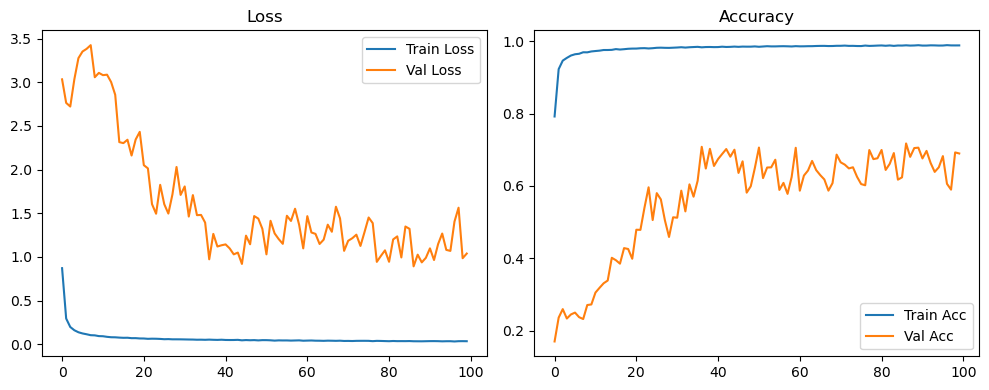

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6885, Acc: 0.9527 | Val Loss: 0.2753, Acc: 0.9727


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1360, Acc: 0.9840 | Val Loss: 0.2011, Acc: 0.9638


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9892 | Val Loss: 0.1901, Acc: 0.9622


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9922 | Val Loss: 0.2261, Acc: 0.9272


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9948 | Val Loss: 0.0911, Acc: 0.9762


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9965 | Val Loss: 0.0738, Acc: 0.9777


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9974 | Val Loss: 0.0696, Acc: 0.9785


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9989 | Val Loss: 0.1235, Acc: 0.9641


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9993 | Val Loss: 0.0632, Acc: 0.9798


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9993 | Val Loss: 0.0871, Acc: 0.9728


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9991 | Val Loss: 0.1567, Acc: 0.9495


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9989 | Val Loss: 0.1670, Acc: 0.9445


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9991 | Val Loss: 0.1456, Acc: 0.9549


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9986 | Val Loss: 0.1063, Acc: 0.9717


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9996 | Val Loss: 0.1953, Acc: 0.9427


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9999 | Val Loss: 0.0576, Acc: 0.9824


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 1.7809, Acc: 0.6254


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9981 | Val Loss: 0.0823, Acc: 0.9738


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.7111, Acc: 0.8027


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9995 | Val Loss: 0.0514, Acc: 0.9842


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9896


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9884


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9901


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9897


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9898


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9894


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9901


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9896


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9900


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9897


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9895


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9902


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9892


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9891


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9884


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9891


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9897


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9893


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9897


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9879


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9910 | Val Loss: 0.0670, Acc: 0.9799


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0592, Acc: 0.9822


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0403, Acc: 0.9883


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9897


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9900


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9905


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9905


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9899


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9899


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9902


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9899


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 1.7863, Acc: 0.5801


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0583, Acc: 0.9828


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.0707, Acc: 0.9812


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9898


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9902


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9893


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9901


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9900


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9900


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9902


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9901


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9901


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9901


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9905


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9902


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9892


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9898


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1100, Acc: 0.9716


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0920, Acc: 0.9782


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0489, Acc: 0.9868


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9888


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9896


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9898


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9898


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9901


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9899


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9899


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9899


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9900


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9898


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9893


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9901


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9898


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9891


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9892


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9895


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.2411, Acc: 0.9432


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0514, Acc: 0.9856


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0534, Acc: 0.9868


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9899


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9902


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9906


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9902


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9901


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9899


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9900


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9899


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9897


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9898


Final Test Loss: 0.0428 Accuracy: 0.9886


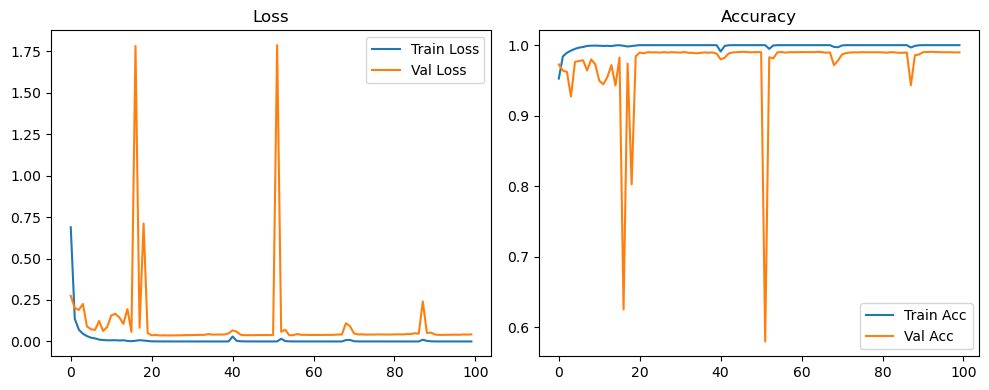

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.8008, Acc: 0.9180 | Val Loss: 1.6413, Acc: 0.2936


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2078, Acc: 0.9686 | Val Loss: 1.0660, Acc: 0.6141


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1194, Acc: 0.9765 | Val Loss: 1.5619, Acc: 0.4953


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0901, Acc: 0.9799 | Val Loss: 2.1497, Acc: 0.3215


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0734, Acc: 0.9822 | Val Loss: 1.5714, Acc: 0.4854


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9837 | Val Loss: 1.7449, Acc: 0.4733


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9855 | Val Loss: 1.2316, Acc: 0.6248


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9862 | Val Loss: 1.5406, Acc: 0.5789


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9872 | Val Loss: 1.8595, Acc: 0.5368


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9881 | Val Loss: 1.2363, Acc: 0.6458


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9885 | Val Loss: 1.4784, Acc: 0.5834


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9898 | Val Loss: 1.9288, Acc: 0.5077


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9899 | Val Loss: 1.7030, Acc: 0.5868


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9911 | Val Loss: 2.0438, Acc: 0.4535


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 1.4447, Acc: 0.6564


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 1.5523, Acc: 0.6310


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9925 | Val Loss: 2.0486, Acc: 0.5272


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9927 | Val Loss: 1.3569, Acc: 0.6580


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 1.4901, Acc: 0.6546


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 1.3843, Acc: 0.6362


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.9732, Acc: 0.7665


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 1.2653, Acc: 0.6957


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 1.4219, Acc: 0.6682


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 1.4428, Acc: 0.6420


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 1.3150, Acc: 0.6787


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 1.5757, Acc: 0.6452


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 1.0993, Acc: 0.7342


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 1.2380, Acc: 0.7004


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 1.1656, Acc: 0.7127


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 1.3739, Acc: 0.6762


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 1.3769, Acc: 0.6762


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 1.6431, Acc: 0.6316


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.8722, Acc: 0.7745


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 1.6295, Acc: 0.6558


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.9970, Acc: 0.7558


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 1.7592, Acc: 0.6274


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 1.0178, Acc: 0.7622


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 1.0417, Acc: 0.7750


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 1.2112, Acc: 0.7384


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 1.2273, Acc: 0.7384


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 1.1274, Acc: 0.7244


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 1.1707, Acc: 0.7702


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 1.0269, Acc: 0.8040


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 1.3950, Acc: 0.7096


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 1.4081, Acc: 0.7123


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 1.0109, Acc: 0.7863


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 1.0724, Acc: 0.7798


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 1.2144, Acc: 0.7124


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.8631, Acc: 0.8076


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 1.1781, Acc: 0.7273


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.8827, Acc: 0.7927


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 1.1424, Acc: 0.7391


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 1.0648, Acc: 0.7646


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.6965, Acc: 0.8337


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.7309, Acc: 0.8460


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.9307, Acc: 0.7961


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.9146, Acc: 0.8133


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 1.0549, Acc: 0.7772


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 1.0766, Acc: 0.7654


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.9358, Acc: 0.7924


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.6661, Acc: 0.8413


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.8615, Acc: 0.8183


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.7140, Acc: 0.8472


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.9447, Acc: 0.8007


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.7337, Acc: 0.8416


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.8084, Acc: 0.8197


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.6175, Acc: 0.8569


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 1.0070, Acc: 0.8102


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.6964, Acc: 0.8456


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.8919, Acc: 0.8233


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.8505, Acc: 0.8371


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.8677, Acc: 0.8251


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 1.1633, Acc: 0.8087


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.9933, Acc: 0.8244


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.8840, Acc: 0.8445


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.5590, Acc: 0.8794


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 1.0178, Acc: 0.7776


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.5798, Acc: 0.8692


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.5876, Acc: 0.8743


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.6983, Acc: 0.8438


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.4805, Acc: 0.8952


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.6632, Acc: 0.8585


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.5972, Acc: 0.8776


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.4545, Acc: 0.8938


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.4908, Acc: 0.8883


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.6698, Acc: 0.8476


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.5659, Acc: 0.8709


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.6528, Acc: 0.8632


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.6031, Acc: 0.8608


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.6520, Acc: 0.8548


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.7157, Acc: 0.8416


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.7383, Acc: 0.8458


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.6082, Acc: 0.8652


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.6069, Acc: 0.8722


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.4566, Acc: 0.8939


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.5917, Acc: 0.8722


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.6678, Acc: 0.8599


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.3801, Acc: 0.9089


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.7938, Acc: 0.8338


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.6234, Acc: 0.8703


Final Test Loss: 0.6041 Accuracy: 0.8727


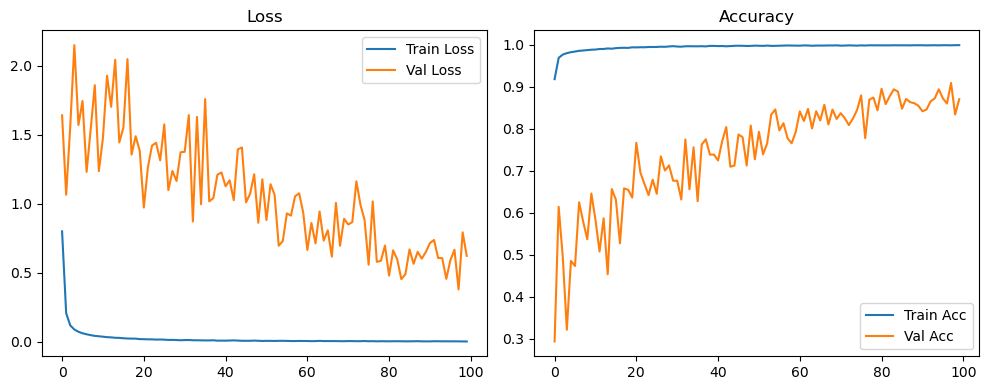

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.1596, Acc: 0.7389 | Val Loss: 3.1534, Acc: 0.1133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4808, Acc: 0.8905 | Val Loss: 3.2505, Acc: 0.1965


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3034, Acc: 0.9251 | Val Loss: 3.0308, Acc: 0.2210


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2300, Acc: 0.9395 | Val Loss: 3.1812, Acc: 0.2152


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1904, Acc: 0.9487 | Val Loss: 3.4057, Acc: 0.2200


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1650, Acc: 0.9541 | Val Loss: 3.6119, Acc: 0.2233


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1504, Acc: 0.9572 | Val Loss: 3.6545, Acc: 0.2224


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1344, Acc: 0.9616 | Val Loss: 3.5257, Acc: 0.2404


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 3.5954, Acc: 0.2531


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1162, Acc: 0.9662 | Val Loss: 3.5537, Acc: 0.2412


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1134, Acc: 0.9660 | Val Loss: 3.5536, Acc: 0.2545


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1057, Acc: 0.9685 | Val Loss: 3.5216, Acc: 0.2770


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1001, Acc: 0.9704 | Val Loss: 3.3753, Acc: 0.2955


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9706 | Val Loss: 3.5620, Acc: 0.2684


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0942, Acc: 0.9718 | Val Loss: 3.3568, Acc: 0.2735


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0895, Acc: 0.9738 | Val Loss: 3.0451, Acc: 0.3058


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9734 | Val Loss: 3.2064, Acc: 0.3119


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9750 | Val Loss: 2.9158, Acc: 0.3191


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9745 | Val Loss: 3.3484, Acc: 0.3113


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9766 | Val Loss: 2.9786, Acc: 0.3260


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9768 | Val Loss: 3.1680, Acc: 0.3211


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0732, Acc: 0.9782 | Val Loss: 2.9644, Acc: 0.3365


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9781 | Val Loss: 2.6493, Acc: 0.3664


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9774 | Val Loss: 2.7440, Acc: 0.3442


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9789 | Val Loss: 2.7124, Acc: 0.3389


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9786 | Val Loss: 2.5428, Acc: 0.3862


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0690, Acc: 0.9793 | Val Loss: 2.6642, Acc: 0.3673


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9787 | Val Loss: 2.8013, Acc: 0.3483


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9798 | Val Loss: 2.9815, Acc: 0.3317


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0642, Acc: 0.9805 | Val Loss: 2.8742, Acc: 0.3494


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9804 | Val Loss: 3.0184, Acc: 0.3438


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9809 | Val Loss: 2.5936, Acc: 0.3792


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9809 | Val Loss: 3.0457, Acc: 0.3195


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9815 | Val Loss: 2.7507, Acc: 0.3643


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9823 | Val Loss: 2.8765, Acc: 0.3562


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0586, Acc: 0.9821 | Val Loss: 2.7978, Acc: 0.3720


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9810 | Val Loss: 2.3075, Acc: 0.4251


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9823 | Val Loss: 2.2837, Acc: 0.4506


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9830 | Val Loss: 1.9555, Acc: 0.4967


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9827 | Val Loss: 2.0179, Acc: 0.4674


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9823 | Val Loss: 1.8872, Acc: 0.5054


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9831 | Val Loss: 1.9882, Acc: 0.4883


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9831 | Val Loss: 2.0293, Acc: 0.4919


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0574, Acc: 0.9826 | Val Loss: 1.9707, Acc: 0.4885


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9837 | Val Loss: 1.6397, Acc: 0.5453


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9829 | Val Loss: 1.8862, Acc: 0.4912


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9835 | Val Loss: 2.0087, Acc: 0.4793


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9834 | Val Loss: 2.1185, Acc: 0.4636


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9841 | Val Loss: 2.1341, Acc: 0.4929


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9841 | Val Loss: 2.0669, Acc: 0.4927


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9830 | Val Loss: 1.9083, Acc: 0.5273


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0504, Acc: 0.9841 | Val Loss: 1.9753, Acc: 0.5036


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9843 | Val Loss: 1.6180, Acc: 0.5783


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9839 | Val Loss: 1.7077, Acc: 0.5534


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9852 | Val Loss: 1.7210, Acc: 0.5549


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9842 | Val Loss: 1.9177, Acc: 0.4998


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9852 | Val Loss: 1.8915, Acc: 0.5022


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9841 | Val Loss: 2.3147, Acc: 0.4356


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 2.1320, Acc: 0.4535


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9858 | Val Loss: 1.6314, Acc: 0.5646


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9845 | Val Loss: 1.8041, Acc: 0.5276


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9855 | Val Loss: 1.5348, Acc: 0.5711


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9855 | Val Loss: 1.3489, Acc: 0.6095


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9852 | Val Loss: 1.4466, Acc: 0.6198


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9849 | Val Loss: 1.7465, Acc: 0.5333


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9848 | Val Loss: 1.6751, Acc: 0.5425


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 1.5054, Acc: 0.5639


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 1.7717, Acc: 0.5353


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 2.1325, Acc: 0.4828


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9862 | Val Loss: 1.5616, Acc: 0.5962


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 1.4630, Acc: 0.6328


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 1.6487, Acc: 0.5733


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 1.6267, Acc: 0.5728


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 1.6825, Acc: 0.5753


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 1.3685, Acc: 0.6491


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9856 | Val Loss: 1.4510, Acc: 0.6137


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 1.7082, Acc: 0.5350


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 1.3391, Acc: 0.6385


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9867 | Val Loss: 1.3376, Acc: 0.6316


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 1.3805, Acc: 0.6302


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9866 | Val Loss: 1.3130, Acc: 0.6372


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 1.1443, Acc: 0.6883


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9867 | Val Loss: 1.4702, Acc: 0.6174


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9867 | Val Loss: 1.3647, Acc: 0.6288


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 1.4739, Acc: 0.5909


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 1.3467, Acc: 0.6464


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9873 | Val Loss: 1.1097, Acc: 0.6856


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 1.3787, Acc: 0.6272


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 1.4103, Acc: 0.6312


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 1.4483, Acc: 0.6179


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 1.4222, Acc: 0.6282


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 1.2878, Acc: 0.6492


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9891 | Val Loss: 1.3107, Acc: 0.6484


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 1.3893, Acc: 0.6278


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9877 | Val Loss: 1.4965, Acc: 0.6164


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 1.3714, Acc: 0.6442


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9879 | Val Loss: 1.3995, Acc: 0.6229


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 1.5734, Acc: 0.6011


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 1.1905, Acc: 0.6807


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 1.3058, Acc: 0.6577


Final Test Loss: 1.2677 Accuracy: 0.6664


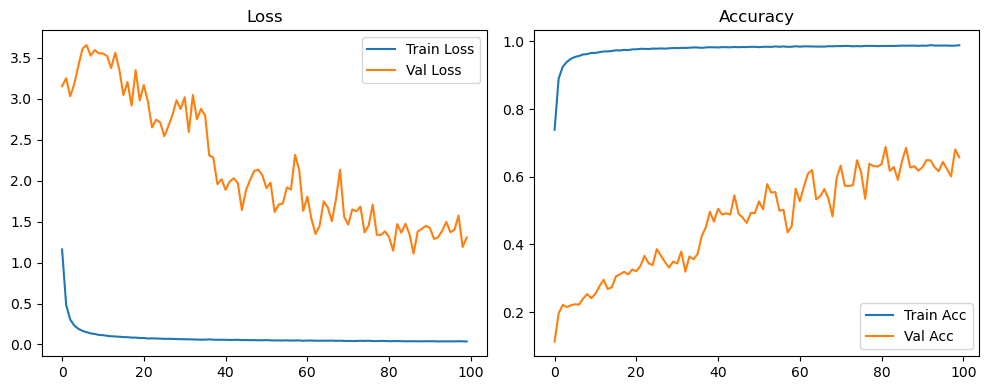

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2853, Acc: 0.9463 | Val Loss: 0.3987, Acc: 0.8652


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9844 | Val Loss: 0.3107, Acc: 0.8968


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9892 | Val Loss: 0.3173, Acc: 0.8931


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9923 | Val Loss: 0.1422, Acc: 0.9557


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9949 | Val Loss: 0.1452, Acc: 0.9542


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.0577, Acc: 0.9801


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9972 | Val Loss: 0.0680, Acc: 0.9787


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.0644, Acc: 0.9817


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.0744, Acc: 0.9762


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0671, Acc: 0.9811


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.0568, Acc: 0.9831


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0810, Acc: 0.9765


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0865, Acc: 0.9770


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0895, Acc: 0.9750


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1118, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1754, Acc: 0.9534


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0493, Acc: 0.9873


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9868


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9892


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9893


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9892


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9896


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9897


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9893


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9898


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9894


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9899


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9899


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9899


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9897


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9898


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9897


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9896


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9899


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9889


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9899


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9897


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9896


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9898


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9899


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9897


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9900


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9898


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9894


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9894


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9892


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9892


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9892


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9898


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9894


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9899


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9894


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9898


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9898


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9892


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9892


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9894


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9895


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9902


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9901


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9901


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9898


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9902


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9898


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9897


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9898


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9900


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9894


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9837 | Val Loss: 0.1444, Acc: 0.9602


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9931 | Val Loss: 0.1478, Acc: 0.9595


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0512, Acc: 0.9870


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0497, Acc: 0.9879


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0532, Acc: 0.9861


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0516, Acc: 0.9885


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9890


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9892


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9898


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9898


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9898


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9897


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9898


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9898


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9898


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9897


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9898


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9890


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9903


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0692, Acc: 0.9853


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0998, Acc: 0.9749


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0758, Acc: 0.9812


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0639, Acc: 0.9852


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0594, Acc: 0.9857


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0536, Acc: 0.9880


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0511, Acc: 0.9885


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9886


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9888


Final Test Loss: 0.0458 Accuracy: 0.9896


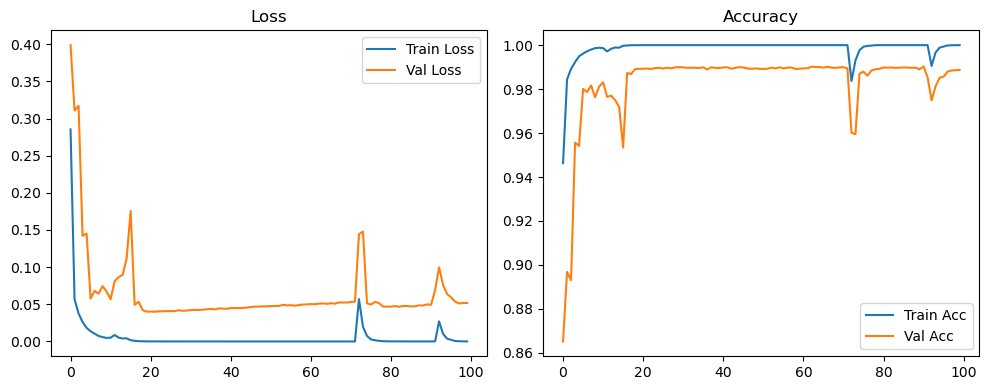

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3566, Acc: 0.9230 | Val Loss: 2.0922, Acc: 0.3914


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9748 | Val Loss: 1.3451, Acc: 0.6013


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9789 | Val Loss: 1.1431, Acc: 0.6418


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9839 | Val Loss: 1.4163, Acc: 0.5933


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9859 | Val Loss: 1.5877, Acc: 0.5465


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.7743, Acc: 0.8147


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 1.2204, Acc: 0.6837


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.9861, Acc: 0.7529


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.7850, Acc: 0.7711


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.6538, Acc: 0.8090


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.7174, Acc: 0.8134


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9924 | Val Loss: 0.6798, Acc: 0.8102


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.7168, Acc: 0.8179


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.2950, Acc: 0.9124


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.4223, Acc: 0.8821


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.4207, Acc: 0.8824


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.4125, Acc: 0.8884


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.4106, Acc: 0.8915


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.5966, Acc: 0.8493


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.6300, Acc: 0.8328


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.2146, Acc: 0.9398


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9956 | Val Loss: 0.3576, Acc: 0.9083


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9960 | Val Loss: 0.3887, Acc: 0.8984


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.3501, Acc: 0.9092


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9959 | Val Loss: 0.3981, Acc: 0.8992


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.2696, Acc: 0.9295


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.3967, Acc: 0.9012


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.2452, Acc: 0.9375


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.3373, Acc: 0.9146


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.3642, Acc: 0.9102


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.2304, Acc: 0.9444


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.2158, Acc: 0.9456


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1677, Acc: 0.9578


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1474, Acc: 0.9651


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.2420, Acc: 0.9397


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.2196, Acc: 0.9484


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1829, Acc: 0.9571


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1902, Acc: 0.9555


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.3215, Acc: 0.9265


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.2979, Acc: 0.9323


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.2756, Acc: 0.9395


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.2440, Acc: 0.9452


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.3043, Acc: 0.9325


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.2004, Acc: 0.9562


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9974 | Val Loss: 0.2267, Acc: 0.9485


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.3394, Acc: 0.9230


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.3378, Acc: 0.9281


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1800, Acc: 0.9592


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.2580, Acc: 0.9439


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1953, Acc: 0.9569


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.1889, Acc: 0.9596


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1817, Acc: 0.9589


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.2905, Acc: 0.9383


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1847, Acc: 0.9610


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.2984, Acc: 0.9377


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1952, Acc: 0.9594


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.3631, Acc: 0.9269


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1707, Acc: 0.9633


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1962, Acc: 0.9600


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1922, Acc: 0.9606


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1577, Acc: 0.9671


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1795, Acc: 0.9631


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1449, Acc: 0.9729


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1485, Acc: 0.9700


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1273, Acc: 0.9735


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1427, Acc: 0.9724


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.2563, Acc: 0.9511


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1594, Acc: 0.9698


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1891, Acc: 0.9636


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2078, Acc: 0.9572


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.2363, Acc: 0.9555


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.3283, Acc: 0.9369


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1865, Acc: 0.9654


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1857, Acc: 0.9668


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1496, Acc: 0.9714


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1528, Acc: 0.9692


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1821, Acc: 0.9653


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1515, Acc: 0.9711


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.2841, Acc: 0.9493


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.2085, Acc: 0.9617


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2086, Acc: 0.9605


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1906, Acc: 0.9659


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1529, Acc: 0.9723


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1955, Acc: 0.9634


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.1334, Acc: 0.9741


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1652, Acc: 0.9692


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2073, Acc: 0.9622


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.2486, Acc: 0.9580


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.2408, Acc: 0.9577


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.2470, Acc: 0.9563


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1713, Acc: 0.9698


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.2597, Acc: 0.9539


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.2100, Acc: 0.9633


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.2263, Acc: 0.9605


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1957, Acc: 0.9659


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1896, Acc: 0.9667


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.1931, Acc: 0.9666


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.2301, Acc: 0.9583


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1368, Acc: 0.9749


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1430, Acc: 0.9747


Final Test Loss: 0.1607 Accuracy: 0.9728


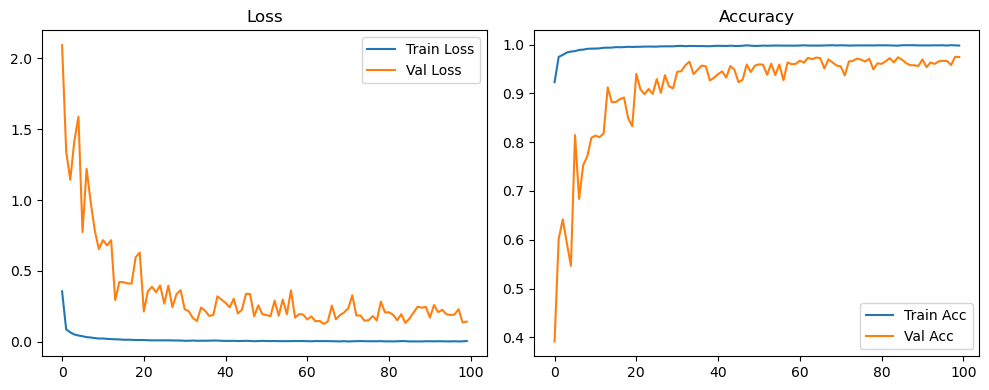

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6035, Acc: 0.8269 | Val Loss: 2.8571, Acc: 0.2208


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1897, Acc: 0.9445 | Val Loss: 2.5115, Acc: 0.2466


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1391, Acc: 0.9586 | Val Loss: 2.4119, Acc: 0.2960


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9651 | Val Loss: 2.5428, Acc: 0.3086


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1051, Acc: 0.9678 | Val Loss: 2.4444, Acc: 0.3298


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9699 | Val Loss: 2.1835, Acc: 0.3894


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9731 | Val Loss: 1.8525, Acc: 0.4382


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9743 | Val Loss: 2.1556, Acc: 0.4150


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0797, Acc: 0.9758 | Val Loss: 1.6632, Acc: 0.4955


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0758, Acc: 0.9766 | Val Loss: 1.5022, Acc: 0.5421


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9765 | Val Loss: 1.6309, Acc: 0.5324


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9779 | Val Loss: 1.5411, Acc: 0.5496


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9785 | Val Loss: 1.4489, Acc: 0.5745


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 1.3728, Acc: 0.5822


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9799 | Val Loss: 1.9289, Acc: 0.4823


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9807 | Val Loss: 2.0732, Acc: 0.4527


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9810 | Val Loss: 1.7557, Acc: 0.5397


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9816 | Val Loss: 1.3766, Acc: 0.6137


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9809 | Val Loss: 1.3519, Acc: 0.6577


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9814 | Val Loss: 1.3666, Acc: 0.6290


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9822 | Val Loss: 1.5106, Acc: 0.5944


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9826 | Val Loss: 1.6558, Acc: 0.5683


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9829 | Val Loss: 1.3577, Acc: 0.6022


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 1.5443, Acc: 0.5884


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9829 | Val Loss: 1.0615, Acc: 0.7022


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9836 | Val Loss: 1.6326, Acc: 0.6293


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9843 | Val Loss: 1.4667, Acc: 0.6358


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9832 | Val Loss: 1.2568, Acc: 0.6663


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9849 | Val Loss: 1.9507, Acc: 0.5417


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9839 | Val Loss: 1.2228, Acc: 0.6777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9852 | Val Loss: 1.2249, Acc: 0.7030


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9852 | Val Loss: 1.4094, Acc: 0.6383


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 1.4129, Acc: 0.6570


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9853 | Val Loss: 1.6602, Acc: 0.6037


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 1.1494, Acc: 0.6877


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 1.5402, Acc: 0.6008


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9864 | Val Loss: 1.0225, Acc: 0.7122


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 1.1616, Acc: 0.6951


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9858 | Val Loss: 1.2253, Acc: 0.7126


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9855 | Val Loss: 1.0620, Acc: 0.7145


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9856 | Val Loss: 1.3679, Acc: 0.6634


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9856 | Val Loss: 1.1757, Acc: 0.7095


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 1.0605, Acc: 0.7219


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9876 | Val Loss: 0.9983, Acc: 0.7243


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9863 | Val Loss: 0.8946, Acc: 0.7507


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.8713, Acc: 0.7567


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 1.3426, Acc: 0.6564


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9872 | Val Loss: 0.9015, Acc: 0.7645


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9882 | Val Loss: 1.0212, Acc: 0.7282


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9877 | Val Loss: 0.8011, Acc: 0.7857


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9865 | Val Loss: 1.0510, Acc: 0.7362


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.6792, Acc: 0.8079


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 1.1188, Acc: 0.7148


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9881 | Val Loss: 1.3546, Acc: 0.6861


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9869 | Val Loss: 1.2815, Acc: 0.6981


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9870 | Val Loss: 1.3649, Acc: 0.6538


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9877 | Val Loss: 1.0693, Acc: 0.7190


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 1.4044, Acc: 0.6541


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9880 | Val Loss: 0.6804, Acc: 0.8086


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9875 | Val Loss: 1.3485, Acc: 0.6833


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 1.3554, Acc: 0.6562


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 1.2150, Acc: 0.6832


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9878 | Val Loss: 0.9734, Acc: 0.7388


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.8590, Acc: 0.7518


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 1.3201, Acc: 0.6609


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 1.2390, Acc: 0.6794


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9877 | Val Loss: 0.9767, Acc: 0.7408


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 1.1811, Acc: 0.7017


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9879 | Val Loss: 1.0533, Acc: 0.7228


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 1.3671, Acc: 0.6645


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 1.2211, Acc: 0.6905


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9874 | Val Loss: 0.9614, Acc: 0.7379


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9882 | Val Loss: 1.2073, Acc: 0.7079


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9882 | Val Loss: 1.1001, Acc: 0.7147


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9891 | Val Loss: 1.4248, Acc: 0.6720


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 1.7489, Acc: 0.6181


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 1.4782, Acc: 0.6479


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 1.5022, Acc: 0.6398


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 1.3134, Acc: 0.6918


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 1.5654, Acc: 0.6338


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.9027, Acc: 0.7526


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 1.1545, Acc: 0.7090


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9891 | Val Loss: 1.2525, Acc: 0.6831


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 1.0312, Acc: 0.7331


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9894 | Val Loss: 0.8688, Acc: 0.7570


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9899 | Val Loss: 0.9002, Acc: 0.7518


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 1.3006, Acc: 0.6638


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 1.1987, Acc: 0.6863


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9891 | Val Loss: 0.3875, Acc: 0.8812


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.9268, Acc: 0.7444


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.9653, Acc: 0.7288


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9891 | Val Loss: 0.9090, Acc: 0.7479


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9894 | Val Loss: 1.0317, Acc: 0.7270


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 1.0314, Acc: 0.7226


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.9393, Acc: 0.7285


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.9022, Acc: 0.7513


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.8009, Acc: 0.7672


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9904 | Val Loss: 0.7670, Acc: 0.7788


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.9875, Acc: 0.7320


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9899 | Val Loss: 0.9761, Acc: 0.7457


Final Test Loss: 0.9341 Accuracy: 0.7558


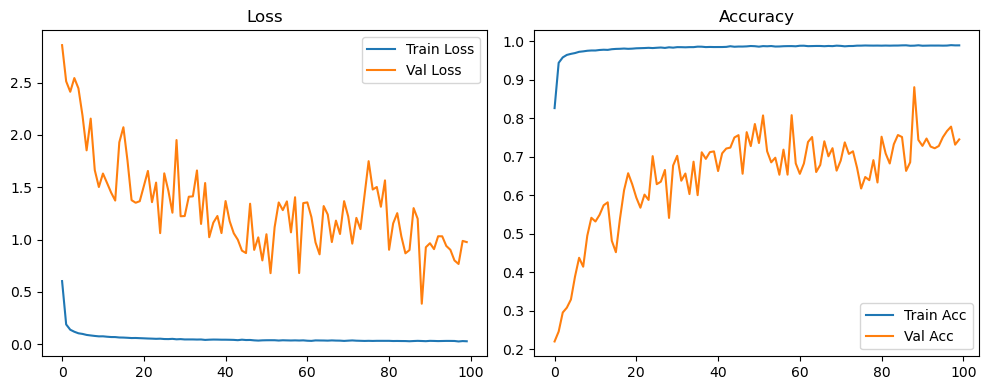

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2853, Acc: 0.9462 | Val Loss: 0.3820, Acc: 0.8710


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9847 | Val Loss: 0.2529, Acc: 0.9169


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9893 | Val Loss: 0.5176, Acc: 0.8325


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9923 | Val Loss: 0.0767, Acc: 0.9757


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9954 | Val Loss: 0.2648, Acc: 0.9168


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.0624, Acc: 0.9809


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1073, Acc: 0.9660


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.0804, Acc: 0.9763


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1318, Acc: 0.9594


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.2009, Acc: 0.9407


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.2927, Acc: 0.9190


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1438, Acc: 0.9583


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0523, Acc: 0.9843


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1799, Acc: 0.9537


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0612, Acc: 0.9830


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0552, Acc: 0.9859


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0444, Acc: 0.9892


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9902


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9899


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9906


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9902


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9905


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9904


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9907


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9906


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9905


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9905


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9905


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9908


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9908


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9912


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9908


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9906


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9907


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9906


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9909


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9907


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9906


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9908


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9906


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9906


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9909


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9905


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9907


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9906


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9908


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9905


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9904


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9906


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9908


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9908


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9908


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9905


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9907


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9908


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9907


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9908


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0483, Acc: 0.9908


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9908


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9907


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9904


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9905


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9904


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9905


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9907


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9904


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9904


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9909


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9906


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9907


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9907


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9905


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9908


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9903


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9902


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9904


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9906


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9904


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9903


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9909


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9901


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9903


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9903


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9905


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9906


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9904


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9905


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9904


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9902


Final Test Loss: 0.0616 Accuracy: 0.9882


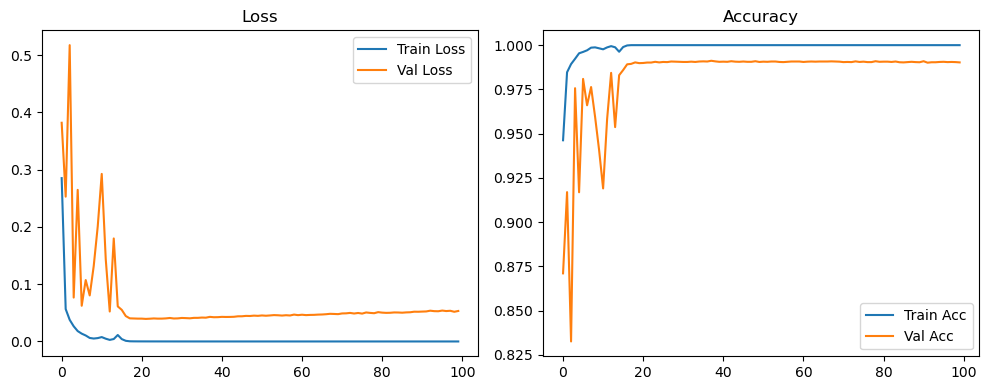

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3565, Acc: 0.9231 | Val Loss: 2.2373, Acc: 0.3427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9749 | Val Loss: 1.3026, Acc: 0.6242


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9789 | Val Loss: 1.1146, Acc: 0.6550


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 1.2734, Acc: 0.6319


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9857 | Val Loss: 1.6735, Acc: 0.5155


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9871 | Val Loss: 0.8901, Acc: 0.7733


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 1.2521, Acc: 0.7099


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 1.2158, Acc: 0.6983


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.9282, Acc: 0.7458


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.6837, Acc: 0.8050


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.8639, Acc: 0.7733


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.9015, Acc: 0.7538


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.6556, Acc: 0.8310


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.3828, Acc: 0.8888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.4589, Acc: 0.8696


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.4652, Acc: 0.8738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.3650, Acc: 0.9012


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.4186, Acc: 0.8804


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.5466, Acc: 0.8644


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.4728, Acc: 0.8720


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.2234, Acc: 0.9385


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.3266, Acc: 0.9125


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9959 | Val Loss: 0.3759, Acc: 0.9053


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.4982, Acc: 0.8792


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.3792, Acc: 0.9030


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9956 | Val Loss: 0.4697, Acc: 0.8849


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.5500, Acc: 0.8705


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.3167, Acc: 0.9203


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.6859, Acc: 0.8424


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.3725, Acc: 0.9134


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.2841, Acc: 0.9304


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.5516, Acc: 0.8716


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.3372, Acc: 0.9184


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.2139, Acc: 0.9493


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.4277, Acc: 0.8987


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.2228, Acc: 0.9475


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.2272, Acc: 0.9462


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.2201, Acc: 0.9504


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.2794, Acc: 0.9364


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.2499, Acc: 0.9462


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.2986, Acc: 0.9372


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.2224, Acc: 0.9536


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.3851, Acc: 0.9187


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.2798, Acc: 0.9402


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1742, Acc: 0.9641


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1837, Acc: 0.9591


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.3245, Acc: 0.9342


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.2571, Acc: 0.9450


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.2404, Acc: 0.9492


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.2401, Acc: 0.9460


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.2381, Acc: 0.9477


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2553, Acc: 0.9465


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.2313, Acc: 0.9517


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2156, Acc: 0.9549


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2603, Acc: 0.9473


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1886, Acc: 0.9613


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.2005, Acc: 0.9582


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2119, Acc: 0.9563


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1971, Acc: 0.9597


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.3434, Acc: 0.9316


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1568, Acc: 0.9683


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.2865, Acc: 0.9455


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.2102, Acc: 0.9604


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2897, Acc: 0.9433


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2409, Acc: 0.9513


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.2462, Acc: 0.9534


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.2442, Acc: 0.9536


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.4116, Acc: 0.9273


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.3309, Acc: 0.9377


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.3196, Acc: 0.9400


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.2811, Acc: 0.9483


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2730, Acc: 0.9521


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.3093, Acc: 0.9441


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.2937, Acc: 0.9468


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2671, Acc: 0.9492


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2585, Acc: 0.9518


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2628, Acc: 0.9514


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2493, Acc: 0.9546


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.3167, Acc: 0.9439


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2984, Acc: 0.9477


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.2234, Acc: 0.9605


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2326, Acc: 0.9583


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2160, Acc: 0.9618


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.2222, Acc: 0.9607


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2190, Acc: 0.9612


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2148, Acc: 0.9607


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2390, Acc: 0.9566


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2366, Acc: 0.9577


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2436, Acc: 0.9573


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2469, Acc: 0.9553


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2435, Acc: 0.9564


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2448, Acc: 0.9570


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2548, Acc: 0.9550


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2625, Acc: 0.9533


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2548, Acc: 0.9549


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2631, Acc: 0.9538


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2308, Acc: 0.9594


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2143, Acc: 0.9633


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2395, Acc: 0.9580


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2347, Acc: 0.9599


Final Test Loss: 0.2511 Accuracy: 0.9560


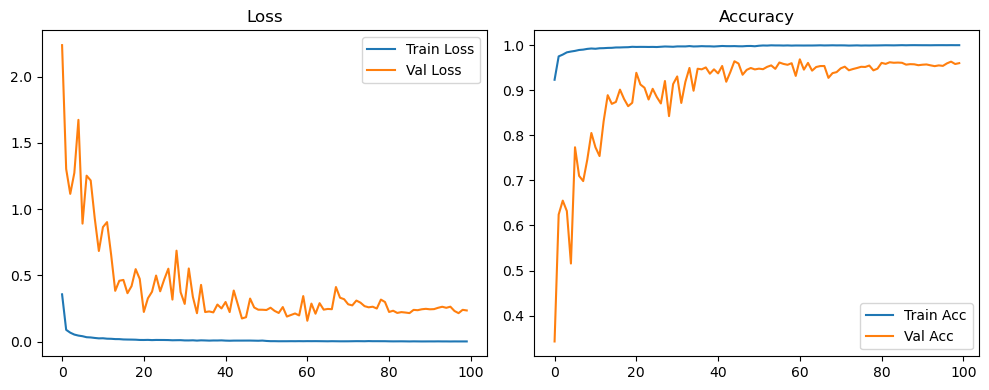

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6035, Acc: 0.8270 | Val Loss: 2.8648, Acc: 0.2197


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1897, Acc: 0.9445 | Val Loss: 2.5576, Acc: 0.2427


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1395, Acc: 0.9580 | Val Loss: 2.2629, Acc: 0.3005


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9652 | Val Loss: 2.4724, Acc: 0.3144


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1046, Acc: 0.9684 | Val Loss: 2.0679, Acc: 0.3941


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9703 | Val Loss: 2.0632, Acc: 0.4018


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9723 | Val Loss: 1.7426, Acc: 0.4584


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0846, Acc: 0.9740 | Val Loss: 2.2118, Acc: 0.4022


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9765 | Val Loss: 1.6374, Acc: 0.5026


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9767 | Val Loss: 1.7241, Acc: 0.5012


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9764 | Val Loss: 1.9026, Acc: 0.4751


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9774 | Val Loss: 1.5362, Acc: 0.5582


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9786 | Val Loss: 1.8090, Acc: 0.4972


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 1.2823, Acc: 0.5840


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9802 | Val Loss: 1.9429, Acc: 0.4861


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9798 | Val Loss: 2.0590, Acc: 0.4667


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9816 | Val Loss: 1.6703, Acc: 0.5430


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9812 | Val Loss: 1.6316, Acc: 0.5651


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9814 | Val Loss: 1.5896, Acc: 0.6074


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9818 | Val Loss: 1.6472, Acc: 0.5618


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9825 | Val Loss: 1.8979, Acc: 0.5164


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9828 | Val Loss: 2.0333, Acc: 0.4969


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9827 | Val Loss: 1.1957, Acc: 0.6402


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9842 | Val Loss: 1.6435, Acc: 0.5923


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9830 | Val Loss: 1.0951, Acc: 0.6903


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9836 | Val Loss: 1.4385, Acc: 0.6642


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9841 | Val Loss: 1.9678, Acc: 0.5664


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9836 | Val Loss: 1.1716, Acc: 0.6824


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 2.0581, Acc: 0.5392


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 1.3513, Acc: 0.6536


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9841 | Val Loss: 1.2620, Acc: 0.6948


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9854 | Val Loss: 1.4234, Acc: 0.6236


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9855 | Val Loss: 1.3326, Acc: 0.6588


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9854 | Val Loss: 1.3615, Acc: 0.6508


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9853 | Val Loss: 1.3097, Acc: 0.6651


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9860 | Val Loss: 1.9071, Acc: 0.5491


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9860 | Val Loss: 1.4587, Acc: 0.6254


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9858 | Val Loss: 1.4712, Acc: 0.6288


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 1.4146, Acc: 0.6640


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9857 | Val Loss: 1.6101, Acc: 0.6040


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9857 | Val Loss: 1.5930, Acc: 0.6290


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9857 | Val Loss: 1.6303, Acc: 0.6317


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9864 | Val Loss: 1.6245, Acc: 0.6055


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 1.2258, Acc: 0.6772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9863 | Val Loss: 0.9325, Acc: 0.7368


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9864 | Val Loss: 1.0628, Acc: 0.7205


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 1.3151, Acc: 0.6548


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9872 | Val Loss: 0.8200, Acc: 0.7583


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9875 | Val Loss: 0.9640, Acc: 0.7445


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9882 | Val Loss: 0.7836, Acc: 0.7794


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.9480, Acc: 0.7468


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.9367, Acc: 0.7442


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9896 | Val Loss: 0.9491, Acc: 0.7496


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 1.0017, Acc: 0.7333


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 1.0527, Acc: 0.7322


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 1.0515, Acc: 0.7250


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 1.0435, Acc: 0.7220


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 1.3267, Acc: 0.6724


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.7744, Acc: 0.7779


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9890 | Val Loss: 0.9769, Acc: 0.7409


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 1.2493, Acc: 0.6757


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.8600, Acc: 0.7582


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.9189, Acc: 0.7416


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.8755, Acc: 0.7471


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.9238, Acc: 0.7335


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 1.0490, Acc: 0.7159


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9895 | Val Loss: 0.8033, Acc: 0.7716


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.9175, Acc: 0.7470


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9898 | Val Loss: 1.0670, Acc: 0.7177


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.8431, Acc: 0.7675


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 1.1005, Acc: 0.7166


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.9246, Acc: 0.7405


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9904 | Val Loss: 0.7789, Acc: 0.7811


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 1.1150, Acc: 0.7252


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9907 | Val Loss: 1.1466, Acc: 0.7133


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 1.0157, Acc: 0.7349


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.8992, Acc: 0.7627


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9907 | Val Loss: 0.8914, Acc: 0.7567


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.8484, Acc: 0.7694


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.9265, Acc: 0.7568


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.7484, Acc: 0.7886


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9909 | Val Loss: 0.7475, Acc: 0.7914


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.8077, Acc: 0.7796


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.7950, Acc: 0.7847


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9919 | Val Loss: 0.8282, Acc: 0.7763


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.7469, Acc: 0.7915


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.7586, Acc: 0.7913


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.7730, Acc: 0.7864


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.6437, Acc: 0.8158


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.7738, Acc: 0.7871


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.9473, Acc: 0.7479


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.7716, Acc: 0.7897


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.7992, Acc: 0.7846


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.8037, Acc: 0.7827


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.8770, Acc: 0.7608


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.7913, Acc: 0.7825


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9922 | Val Loss: 0.7395, Acc: 0.7928


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9925 | Val Loss: 0.7992, Acc: 0.7787


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.7062, Acc: 0.7994


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.8262, Acc: 0.7741


Final Test Loss: 0.7887 Accuracy: 0.7828


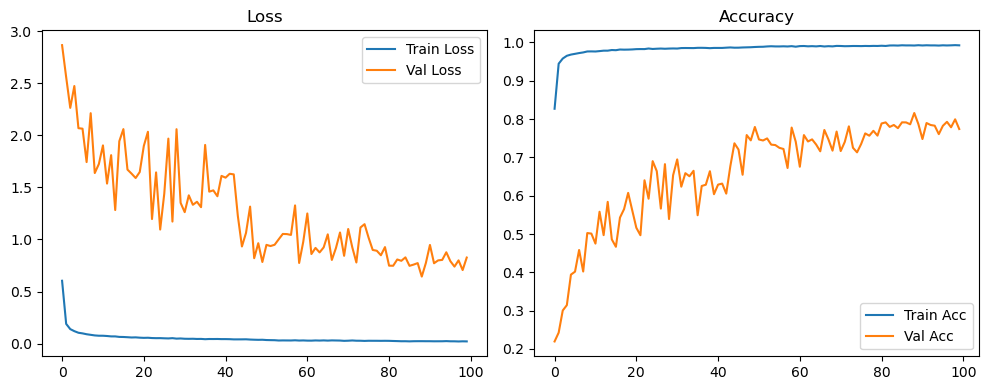

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2852, Acc: 0.9463 | Val Loss: 0.4453, Acc: 0.8462


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9843 | Val Loss: 0.2570, Acc: 0.9161


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9891 | Val Loss: 0.3871, Acc: 0.8636


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9922 | Val Loss: 0.0840, Acc: 0.9748


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.2265, Acc: 0.9296


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.0900, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.0565, Acc: 0.9840


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.3513, Acc: 0.8973


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1309, Acc: 0.9619


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0860, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.2124, Acc: 0.9414


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.0604, Acc: 0.9822


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0642, Acc: 0.9837


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0950, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0629, Acc: 0.9842


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0426, Acc: 0.9889


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9891


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9893


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9893


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9897


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9898


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9896


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9896


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9896


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9896


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9894


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9893


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9894


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9898


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9899


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9897


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9897


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9897


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9893


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9897


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9900


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9899


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9899


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9899


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9898


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9895


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9895


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9897


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9895


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9896


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9895


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9897


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9897


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9896


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9902


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9896


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9900


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9898


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9899


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9903


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9897


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9903


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9898


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9898


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9899


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9901


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9902


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9900


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9900


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9902


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9898


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9898


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9902


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9898


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9899


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0562, Acc: 0.9898


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9905


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9899


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9901


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9902


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9901


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9903


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9903


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9903


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9900


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9898


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9896


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9900


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9900


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9898


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9899


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9897


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9899


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9898


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9901


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9898


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9899


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9902


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9898


Final Test Loss: 0.0636 Accuracy: 0.9877


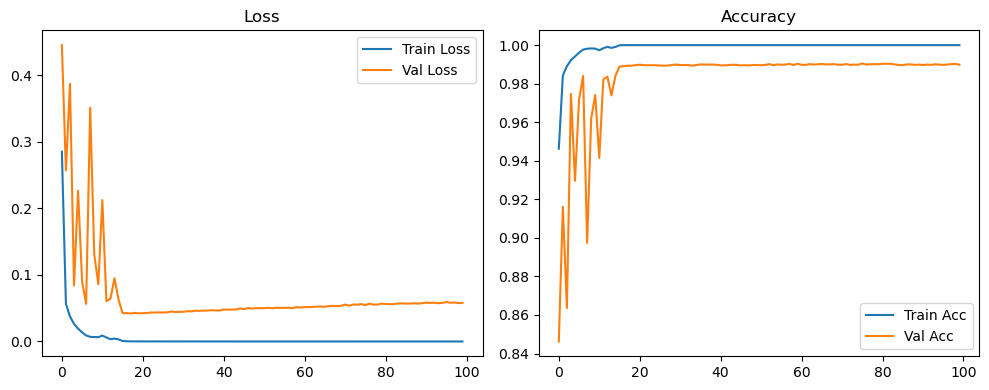

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3564, Acc: 0.9232 | Val Loss: 2.1425, Acc: 0.3747


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9747 | Val Loss: 1.2604, Acc: 0.6222


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9790 | Val Loss: 1.1691, Acc: 0.6416


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 1.3551, Acc: 0.6267


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 1.5894, Acc: 0.5390


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.9210, Acc: 0.7644


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.9579, Acc: 0.7434


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.9895, Acc: 0.7578


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.8541, Acc: 0.7570


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9927 | Val Loss: 0.8286, Acc: 0.7762


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.8712, Acc: 0.7877


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.8447, Acc: 0.7659


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.8544, Acc: 0.7725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.4238, Acc: 0.8818


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.2914, Acc: 0.9159


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.2914, Acc: 0.9171


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.3311, Acc: 0.9097


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.4361, Acc: 0.8753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.6702, Acc: 0.8315


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.4022, Acc: 0.8917


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.1949, Acc: 0.9458


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.3837, Acc: 0.8962


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.3333, Acc: 0.9123


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.4276, Acc: 0.8896


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.4300, Acc: 0.8905


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.6753, Acc: 0.8435


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.3587, Acc: 0.9099


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.3254, Acc: 0.9193


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.3230, Acc: 0.9188


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.4357, Acc: 0.8993


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.3986, Acc: 0.9048


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.4407, Acc: 0.8980


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.4502, Acc: 0.8931


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.3628, Acc: 0.9170


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.4190, Acc: 0.9022


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.2635, Acc: 0.9388


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.3249, Acc: 0.9247


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.2579, Acc: 0.9417


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.2798, Acc: 0.9382


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.2702, Acc: 0.9359


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.2171, Acc: 0.9501


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.2014, Acc: 0.9549


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.2523, Acc: 0.9455


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.2598, Acc: 0.9457


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.2648, Acc: 0.9410


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.3414, Acc: 0.9277


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.2594, Acc: 0.9443


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.2722, Acc: 0.9444


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.2435, Acc: 0.9481


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.3161, Acc: 0.9311


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.2675, Acc: 0.9417


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2272, Acc: 0.9496


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.2591, Acc: 0.9453


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2519, Acc: 0.9448


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.2302, Acc: 0.9519


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1918, Acc: 0.9604


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1847, Acc: 0.9629


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2368, Acc: 0.9517


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.2648, Acc: 0.9481


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.3203, Acc: 0.9383


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.2424, Acc: 0.9516


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.2666, Acc: 0.9484


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.2338, Acc: 0.9539


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2407, Acc: 0.9532


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2760, Acc: 0.9447


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2503, Acc: 0.9505


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2920, Acc: 0.9404


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2938, Acc: 0.9444


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2380, Acc: 0.9535


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.2488, Acc: 0.9515


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2505, Acc: 0.9517


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.3323, Acc: 0.9368


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2729, Acc: 0.9480


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.3030, Acc: 0.9453


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2931, Acc: 0.9447


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.2658, Acc: 0.9498


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.3723, Acc: 0.9301


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.2964, Acc: 0.9425


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.3704, Acc: 0.9283


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.3582, Acc: 0.9307


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.3258, Acc: 0.9358


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.3410, Acc: 0.9319


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.3142, Acc: 0.9384


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2680, Acc: 0.9482


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2743, Acc: 0.9478


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.3001, Acc: 0.9425


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2735, Acc: 0.9467


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.3018, Acc: 0.9429


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.3066, Acc: 0.9427


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2795, Acc: 0.9469


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2907, Acc: 0.9447


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.3054, Acc: 0.9427


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.3178, Acc: 0.9396


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2866, Acc: 0.9456


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.3214, Acc: 0.9406


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.3069, Acc: 0.9425


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2873, Acc: 0.9461


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2844, Acc: 0.9474


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.2612, Acc: 0.9503


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2542, Acc: 0.9523


Final Test Loss: 0.2729 Accuracy: 0.9507


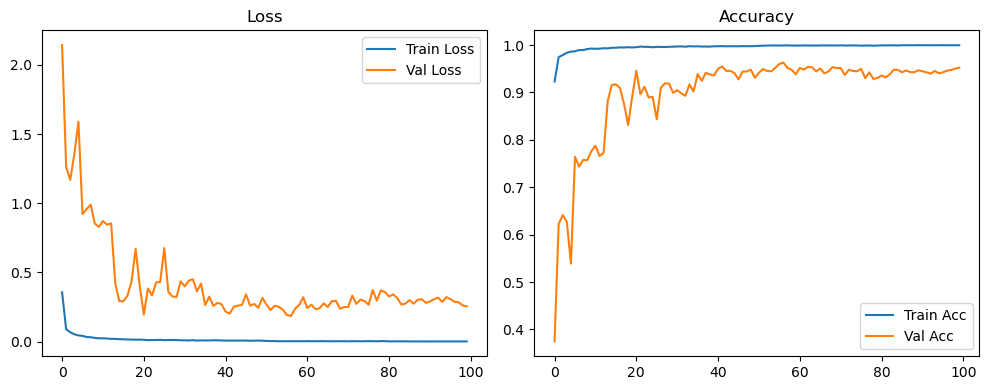

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6035, Acc: 0.8271 | Val Loss: 2.8947, Acc: 0.2165


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1895, Acc: 0.9443 | Val Loss: 2.5822, Acc: 0.2387


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9585 | Val Loss: 2.2052, Acc: 0.3036


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9653 | Val Loss: 2.3966, Acc: 0.3175


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9680 | Val Loss: 2.2604, Acc: 0.3538


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9701 | Val Loss: 2.2160, Acc: 0.3878


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9728 | Val Loss: 2.0365, Acc: 0.4005


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0846, Acc: 0.9745 | Val Loss: 2.1566, Acc: 0.4094


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9766 | Val Loss: 1.7941, Acc: 0.4616


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9764 | Val Loss: 1.8892, Acc: 0.4677


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9768 | Val Loss: 2.1004, Acc: 0.4276


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9776 | Val Loss: 1.7774, Acc: 0.4841


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 1.8475, Acc: 0.4779


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0690, Acc: 0.9785 | Val Loss: 1.5960, Acc: 0.5128


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9802 | Val Loss: 1.5772, Acc: 0.5449


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9801 | Val Loss: 1.9251, Acc: 0.4577


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9805 | Val Loss: 1.5857, Acc: 0.5499


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9810 | Val Loss: 1.6538, Acc: 0.5386


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9809 | Val Loss: 1.6295, Acc: 0.5939


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9816 | Val Loss: 1.3915, Acc: 0.6032


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9829 | Val Loss: 1.7873, Acc: 0.5401


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9825 | Val Loss: 1.8285, Acc: 0.5258


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 1.3745, Acc: 0.5911


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9836 | Val Loss: 1.4985, Acc: 0.6085


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9840 | Val Loss: 1.2664, Acc: 0.6472


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9835 | Val Loss: 1.5651, Acc: 0.6328


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 1.4750, Acc: 0.6316


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9833 | Val Loss: 1.5484, Acc: 0.6122


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9854 | Val Loss: 1.8003, Acc: 0.5630


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9839 | Val Loss: 1.1448, Acc: 0.6863


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 1.4457, Acc: 0.6565


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 1.4351, Acc: 0.6293


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 1.2840, Acc: 0.6820


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 1.2761, Acc: 0.6648


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 1.2823, Acc: 0.6578


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9860 | Val Loss: 1.2674, Acc: 0.6614


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9861 | Val Loss: 0.8107, Acc: 0.7582


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 1.2092, Acc: 0.6790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9852 | Val Loss: 1.3375, Acc: 0.6823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 1.3746, Acc: 0.6469


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 1.1775, Acc: 0.6887


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 1.1116, Acc: 0.7129


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9865 | Val Loss: 1.3131, Acc: 0.6608


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 1.2865, Acc: 0.6747


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.9062, Acc: 0.7457


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.8246, Acc: 0.7715


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 1.4586, Acc: 0.6387


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9880 | Val Loss: 0.8882, Acc: 0.7483


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9881 | Val Loss: 0.8434, Acc: 0.7643


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.7171, Acc: 0.7934


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9880 | Val Loss: 0.8733, Acc: 0.7554


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.8665, Acc: 0.7561


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 1.0196, Acc: 0.7325


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9898 | Val Loss: 0.9294, Acc: 0.7441


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 1.0558, Acc: 0.7213


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 1.0766, Acc: 0.7099


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 1.2263, Acc: 0.6842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 1.3503, Acc: 0.6653


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.8897, Acc: 0.7459


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9894 | Val Loss: 0.8968, Acc: 0.7558


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.9907, Acc: 0.7251


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.7838, Acc: 0.7738


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.9262, Acc: 0.7376


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.7963, Acc: 0.7662


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.9252, Acc: 0.7402


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.7952, Acc: 0.7689


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9900 | Val Loss: 0.8561, Acc: 0.7622


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.8944, Acc: 0.7518


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 1.0469, Acc: 0.7157


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.9078, Acc: 0.7533


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 1.0424, Acc: 0.7231


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.7059, Acc: 0.7973


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9904 | Val Loss: 0.8183, Acc: 0.7738


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9903 | Val Loss: 0.7985, Acc: 0.7712


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.9875, Acc: 0.7412


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.8990, Acc: 0.7562


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.9543, Acc: 0.7489


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 1.0296, Acc: 0.7288


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9901 | Val Loss: 1.0084, Acc: 0.7361


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 1.0554, Acc: 0.7336


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.8589, Acc: 0.7668


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.8191, Acc: 0.7750


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.8482, Acc: 0.7701


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.8303, Acc: 0.7735


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9916 | Val Loss: 0.7850, Acc: 0.7809


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9925 | Val Loss: 0.8212, Acc: 0.7712


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.7829, Acc: 0.7802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9918 | Val Loss: 0.8091, Acc: 0.7755


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.7201, Acc: 0.7947


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.8040, Acc: 0.7772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.8710, Acc: 0.7611


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.8036, Acc: 0.7778


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.7752, Acc: 0.7849


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.7978, Acc: 0.7798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.8071, Acc: 0.7752


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.8442, Acc: 0.7699


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.8026, Acc: 0.7771


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.8143, Acc: 0.7736


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.7764, Acc: 0.7787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9929 | Val Loss: 0.7786, Acc: 0.7823


Final Test Loss: 0.7438 Accuracy: 0.7892


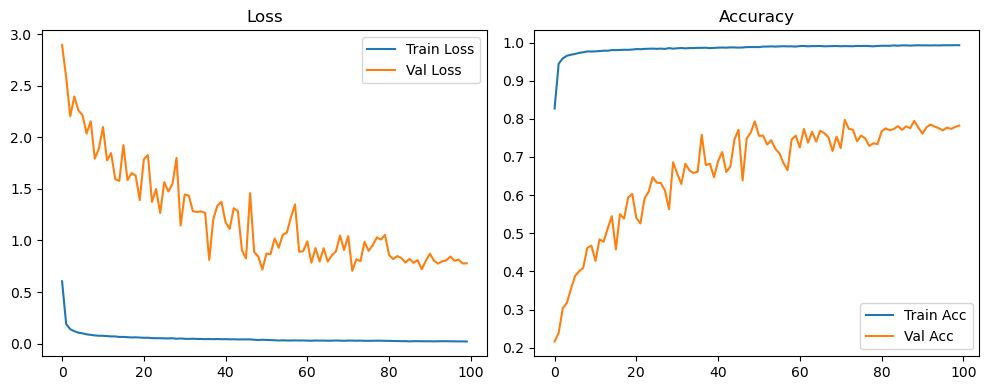

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2852, Acc: 0.9464 | Val Loss: 0.3903, Acc: 0.8622


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9842 | Val Loss: 0.1807, Acc: 0.9432


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9888 | Val Loss: 0.2859, Acc: 0.9032


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9923 | Val Loss: 0.1278, Acc: 0.9603


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9948 | Val Loss: 0.2977, Acc: 0.9029


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9965 | Val Loss: 0.0880, Acc: 0.9707


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.0681, Acc: 0.9786


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9986 | Val Loss: 0.4454, Acc: 0.8657


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1269, Acc: 0.9650


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.0800, Acc: 0.9789


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1707, Acc: 0.9558


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0668, Acc: 0.9828


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.0999, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1026, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.0618, Acc: 0.9833


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9898


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9906


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9902


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9901


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9903


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9904


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9904


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9901


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9907


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9898


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9903


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9902


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9901


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9907


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9900


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9905


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9898


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9899


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9900


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9904


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9898


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9901


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9898


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9904


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9902


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9901


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9902


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9905


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9904


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9901


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9898


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9903


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9902


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9899


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9904


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9900


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9904


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9904


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9900


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9906


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9899


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9902


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9900


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9902


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9905


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9907


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9903


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9900


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9900


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9895


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9900


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9899


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9902


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9899


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9899


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9901


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9891


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9900


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9899


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9904


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9906


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9906


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9904


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9899


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9898


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9901


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9898


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9901


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9899


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9892


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9895


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9900


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9895


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9898


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9896


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9899


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9898


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9898


Final Test Loss: 0.0620 Accuracy: 0.9887


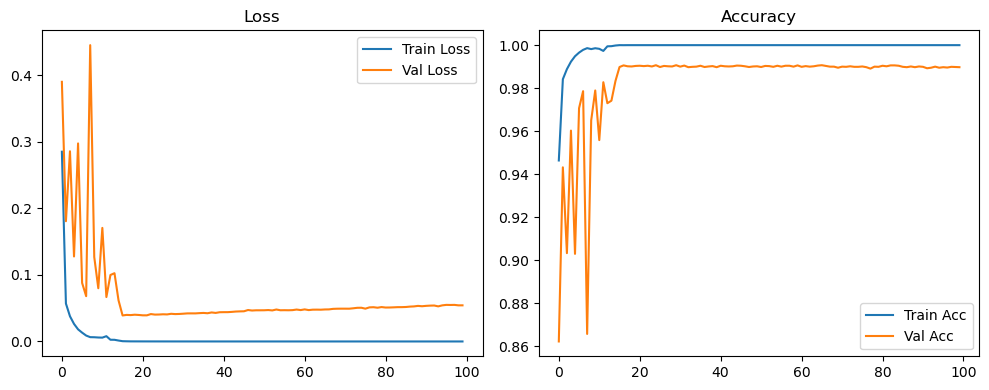

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3564, Acc: 0.9230 | Val Loss: 2.1726, Acc: 0.3784


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9748 | Val Loss: 1.3663, Acc: 0.5772


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9793 | Val Loss: 1.1879, Acc: 0.6427


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9843 | Val Loss: 1.3773, Acc: 0.6145


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9857 | Val Loss: 1.5834, Acc: 0.5289


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.8825, Acc: 0.7666


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 1.1062, Acc: 0.7153


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.9457, Acc: 0.7526


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.7654, Acc: 0.7841


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.5876, Acc: 0.8337


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.9698, Acc: 0.7903


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9926 | Val Loss: 0.5894, Acc: 0.8300


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.4459, Acc: 0.8712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.4836, Acc: 0.8640


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.4454, Acc: 0.8771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9944 | Val Loss: 0.3337, Acc: 0.9080


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.2963, Acc: 0.9170


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.4283, Acc: 0.8794


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.3024, Acc: 0.9193


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.5705, Acc: 0.8407


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.2096, Acc: 0.9423


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.2774, Acc: 0.9274


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1972, Acc: 0.9468


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.3890, Acc: 0.9002


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.2266, Acc: 0.9415


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.3324, Acc: 0.9135


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.2727, Acc: 0.9273


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1296, Acc: 0.9642


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9958 | Val Loss: 0.2726, Acc: 0.9283


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.3158, Acc: 0.9187


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.2619, Acc: 0.9324


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.2973, Acc: 0.9293


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1970, Acc: 0.9537


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.2187, Acc: 0.9477


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.2158, Acc: 0.9477


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1612, Acc: 0.9606


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1714, Acc: 0.9557


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1815, Acc: 0.9576


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.2473, Acc: 0.9441


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.3412, Acc: 0.9225


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.2498, Acc: 0.9437


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.2381, Acc: 0.9463


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.2426, Acc: 0.9452


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1597, Acc: 0.9635


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.2155, Acc: 0.9515


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.2016, Acc: 0.9545


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.3577, Acc: 0.9219


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.3756, Acc: 0.9230


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.2691, Acc: 0.9403


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.2046, Acc: 0.9555


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1980, Acc: 0.9573


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1895, Acc: 0.9603


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1775, Acc: 0.9628


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1847, Acc: 0.9614


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1861, Acc: 0.9603


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1772, Acc: 0.9620


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1766, Acc: 0.9636


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1740, Acc: 0.9633


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1979, Acc: 0.9607


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1967, Acc: 0.9597


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1794, Acc: 0.9635


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1888, Acc: 0.9618


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1735, Acc: 0.9646


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1846, Acc: 0.9621


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1835, Acc: 0.9619


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1767, Acc: 0.9636


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1821, Acc: 0.9633


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2129, Acc: 0.9582


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2240, Acc: 0.9557


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1941, Acc: 0.9611


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1745, Acc: 0.9650


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2002, Acc: 0.9606


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2070, Acc: 0.9597


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2141, Acc: 0.9584


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2005, Acc: 0.9614


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1944, Acc: 0.9620


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.2280, Acc: 0.9557


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2208, Acc: 0.9567


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2633, Acc: 0.9491


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2659, Acc: 0.9497


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2424, Acc: 0.9533


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2544, Acc: 0.9517


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2323, Acc: 0.9562


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2030, Acc: 0.9623


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1904, Acc: 0.9630


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2128, Acc: 0.9592


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2105, Acc: 0.9593


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2158, Acc: 0.9586


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2140, Acc: 0.9594


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2138, Acc: 0.9600


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2157, Acc: 0.9587


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2356, Acc: 0.9558


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2528, Acc: 0.9534


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2295, Acc: 0.9573


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2357, Acc: 0.9557


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2381, Acc: 0.9555


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2172, Acc: 0.9598


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2167, Acc: 0.9597


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2177, Acc: 0.9597


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2091, Acc: 0.9616


Final Test Loss: 0.2272 Accuracy: 0.9585


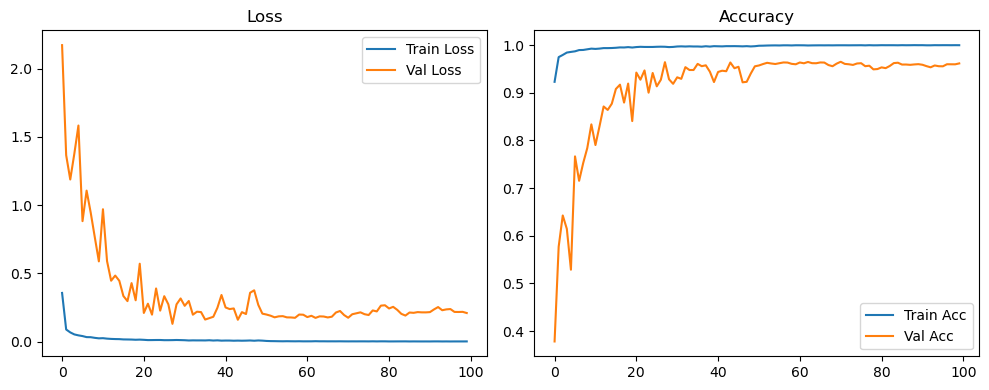

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6034, Acc: 0.8269 | Val Loss: 2.8545, Acc: 0.2226


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1896, Acc: 0.9441 | Val Loss: 2.3340, Acc: 0.2657


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9587 | Val Loss: 2.0867, Acc: 0.3250


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1189, Acc: 0.9655 | Val Loss: 2.3308, Acc: 0.3352


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9688 | Val Loss: 2.1588, Acc: 0.3910


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9698 | Val Loss: 2.0553, Acc: 0.3987


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9729 | Val Loss: 1.8825, Acc: 0.4300


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9740 | Val Loss: 1.9857, Acc: 0.4313


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9765 | Val Loss: 1.4699, Acc: 0.5236


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0758, Acc: 0.9769 | Val Loss: 1.5647, Acc: 0.5303


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9765 | Val Loss: 1.8266, Acc: 0.4791


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9774 | Val Loss: 1.6717, Acc: 0.5237


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9787 | Val Loss: 1.7527, Acc: 0.4973


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9788 | Val Loss: 1.7237, Acc: 0.4898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9797 | Val Loss: 2.0666, Acc: 0.4666


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9795 | Val Loss: 2.0688, Acc: 0.4488


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9817 | Val Loss: 1.8961, Acc: 0.4944


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9814 | Val Loss: 1.6364, Acc: 0.5610


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9805 | Val Loss: 1.9284, Acc: 0.5415


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9813 | Val Loss: 1.8767, Acc: 0.5215


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9824 | Val Loss: 1.8359, Acc: 0.5302


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9825 | Val Loss: 1.8401, Acc: 0.5198


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9826 | Val Loss: 1.1889, Acc: 0.6397


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 1.8312, Acc: 0.5544


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9827 | Val Loss: 1.2964, Acc: 0.6486


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9837 | Val Loss: 1.5397, Acc: 0.6339


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9834 | Val Loss: 1.7838, Acc: 0.5852


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 1.6095, Acc: 0.6067


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 1.9257, Acc: 0.5516


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 1.3715, Acc: 0.6449


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9849 | Val Loss: 1.4514, Acc: 0.6661


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 1.3472, Acc: 0.6315


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9852 | Val Loss: 1.3280, Acc: 0.6651


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9850 | Val Loss: 0.9367, Acc: 0.7342


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 1.3215, Acc: 0.6473


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9863 | Val Loss: 1.6170, Acc: 0.5996


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9855 | Val Loss: 1.4922, Acc: 0.6078


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9851 | Val Loss: 1.5115, Acc: 0.6342


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9857 | Val Loss: 1.4914, Acc: 0.6373


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9856 | Val Loss: 1.0872, Acc: 0.6990


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 1.8085, Acc: 0.5942


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9858 | Val Loss: 1.3856, Acc: 0.6635


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9860 | Val Loss: 1.1895, Acc: 0.6853


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9873 | Val Loss: 0.8537, Acc: 0.7589


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9866 | Val Loss: 0.8762, Acc: 0.7577


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.8794, Acc: 0.7566


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9865 | Val Loss: 1.5175, Acc: 0.6295


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.8711, Acc: 0.7582


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.9867, Acc: 0.7414


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9875 | Val Loss: 0.6877, Acc: 0.7991


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.9428, Acc: 0.7477


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.8694, Acc: 0.7634


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.8232, Acc: 0.7726


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.8666, Acc: 0.7586


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.8794, Acc: 0.7612


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.8554, Acc: 0.7598


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.9535, Acc: 0.7425


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 1.0412, Acc: 0.7261


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.7893, Acc: 0.7771


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.8525, Acc: 0.7610


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.8772, Acc: 0.7565


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.8133, Acc: 0.7742


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.7817, Acc: 0.7792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.7254, Acc: 0.7895


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.8533, Acc: 0.7568


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.8689, Acc: 0.7589


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9907 | Val Loss: 0.8243, Acc: 0.7672


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.9160, Acc: 0.7552


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.8833, Acc: 0.7562


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.8344, Acc: 0.7698


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.9246, Acc: 0.7478


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.9493, Acc: 0.7458


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.8827, Acc: 0.7595


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9908 | Val Loss: 0.9841, Acc: 0.7393


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 1.0751, Acc: 0.7188


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.9708, Acc: 0.7409


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.9799, Acc: 0.7389


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.9749, Acc: 0.7412


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9910 | Val Loss: 0.8381, Acc: 0.7698


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.9122, Acc: 0.7579


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.7462, Acc: 0.7898


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9908 | Val Loss: 0.7722, Acc: 0.7857


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.8392, Acc: 0.7705


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.8083, Acc: 0.7772


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.8212, Acc: 0.7753


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.8184, Acc: 0.7753


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.8124, Acc: 0.7780


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.8770, Acc: 0.7668


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.7826, Acc: 0.7847


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.8361, Acc: 0.7726


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.9056, Acc: 0.7558


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.8406, Acc: 0.7733


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.8633, Acc: 0.7701


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9926 | Val Loss: 0.8557, Acc: 0.7687


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.8019, Acc: 0.7788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.8494, Acc: 0.7740


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.7813, Acc: 0.7859


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.7553, Acc: 0.7898


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9927 | Val Loss: 0.7882, Acc: 0.7828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.8244, Acc: 0.7770


Final Test Loss: 0.7886 Accuracy: 0.7850


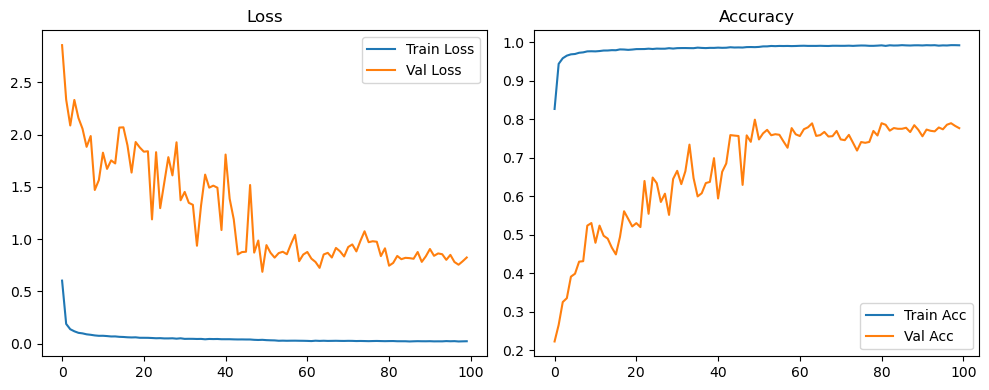

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3929, Acc: 0.9484 | Val Loss: 0.2036, Acc: 0.9517


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9846 | Val Loss: 0.3015, Acc: 0.8951


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9893 | Val Loss: 0.1043, Acc: 0.9690


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9934 | Val Loss: 0.2178, Acc: 0.9357


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9952 | Val Loss: 0.1261, Acc: 0.9605


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9968 | Val Loss: 0.1265, Acc: 0.9592


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9983 | Val Loss: 0.0644, Acc: 0.9799


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9993 | Val Loss: 0.0630, Acc: 0.9797


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9862


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9999 | Val Loss: 0.0605, Acc: 0.9811


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9999 | Val Loss: 0.1569, Acc: 0.9527


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1622, Acc: 0.9533


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.6075, Acc: 0.8188


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0802, Acc: 0.9759


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.0444, Acc: 0.9861


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9999 | Val Loss: 0.0374, Acc: 0.9886


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9891


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9883


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9892


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9888


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9888


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9887


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9889


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9891


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9888


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9886


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9889


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9887


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9889


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9890


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9890


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9890


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9887


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9890


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9887


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9886


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9886


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9888


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9888


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9886


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9887


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9886


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9884


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9886


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9886


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9888


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9889


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9889


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9886


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9890


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9891


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9887


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9884


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9888


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9882


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9888


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9888


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9888


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9885


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9885


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9888


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9888


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9889


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9886


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9886


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9885


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9885


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9891


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9887


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9888


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9888


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9885


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9890


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9891


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0562, Acc: 0.9889


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0548, Acc: 0.9888


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9888


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0564, Acc: 0.9890


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9891


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9890


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9890


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9889


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9888


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9892


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9891


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9888


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9889


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9883 | Val Loss: 0.1188, Acc: 0.9668


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.1177, Acc: 0.9681


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0591, Acc: 0.9831


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0542, Acc: 0.9849


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9999 | Val Loss: 0.0499, Acc: 0.9858


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9892


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9884


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9889


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9889


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9887


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9891


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9890


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9892


Final Test Loss: 0.0435 Accuracy: 0.9892


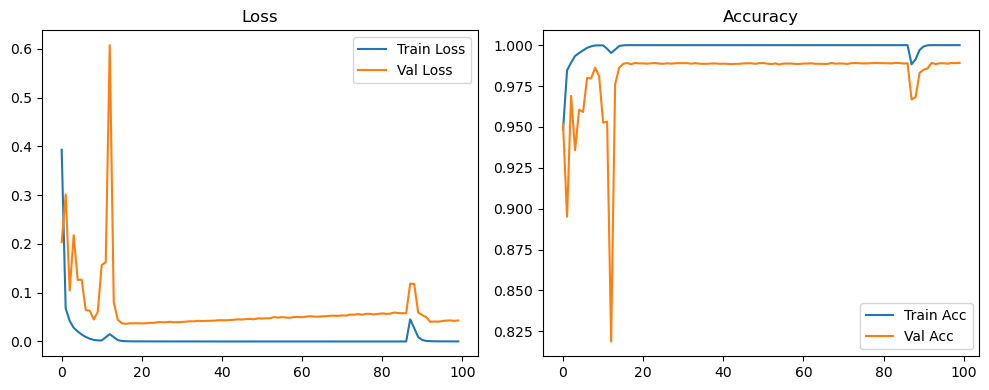

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4767, Acc: 0.9221 | Val Loss: 2.1147, Acc: 0.2816


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1065, Acc: 0.9735 | Val Loss: 1.5378, Acc: 0.4517


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9788 | Val Loss: 0.9203, Acc: 0.6886


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9830 | Val Loss: 1.5011, Acc: 0.5513


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9844 | Val Loss: 1.6394, Acc: 0.5198


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9866 | Val Loss: 1.2203, Acc: 0.6963


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9886 | Val Loss: 1.7992, Acc: 0.5502


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.9896, Acc: 0.7275


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 1.2177, Acc: 0.6827


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9911 | Val Loss: 1.1705, Acc: 0.6626


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 1.3601, Acc: 0.6797


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 1.3757, Acc: 0.6342


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.8206, Acc: 0.7742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 1.0091, Acc: 0.7349


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.6035, Acc: 0.8321


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 1.1469, Acc: 0.7234


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.9501, Acc: 0.7455


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.8527, Acc: 0.7722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 1.5181, Acc: 0.7062


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 1.0533, Acc: 0.7259


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.4024, Acc: 0.8869


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.6263, Acc: 0.8501


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.4717, Acc: 0.8748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.7255, Acc: 0.8290


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.4003, Acc: 0.8868


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.7041, Acc: 0.8288


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.5169, Acc: 0.8655


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.4137, Acc: 0.8863


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.5005, Acc: 0.8822


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.6237, Acc: 0.8641


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.3812, Acc: 0.9020


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.8086, Acc: 0.8205


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.5155, Acc: 0.8694


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9968 | Val Loss: 0.4292, Acc: 0.8892


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.6711, Acc: 0.8510


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.4493, Acc: 0.8968


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.4290, Acc: 0.9037


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.5360, Acc: 0.8727


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.4507, Acc: 0.9050


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.4568, Acc: 0.8904


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.6836, Acc: 0.8437


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.3319, Acc: 0.9152


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.5013, Acc: 0.8785


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.3668, Acc: 0.9136


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.3741, Acc: 0.9032


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.4449, Acc: 0.8966


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.4324, Acc: 0.8949


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.3525, Acc: 0.9164


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.3870, Acc: 0.9093


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.5498, Acc: 0.8804


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 1.1069, Acc: 0.8031


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.4087, Acc: 0.9068


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.5951, Acc: 0.8643


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.4131, Acc: 0.9086


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.5422, Acc: 0.8792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.6047, Acc: 0.8702


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.4510, Acc: 0.9066


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.5781, Acc: 0.8808


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.6965, Acc: 0.8602


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.3996, Acc: 0.9136


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.5789, Acc: 0.8761


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.7254, Acc: 0.8566


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.4616, Acc: 0.9025


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.4771, Acc: 0.8976


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.4103, Acc: 0.9106


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.7272, Acc: 0.8718


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.6749, Acc: 0.8632


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.5354, Acc: 0.8887


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.4659, Acc: 0.9027


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.4713, Acc: 0.8976


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.6008, Acc: 0.8811


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.4410, Acc: 0.9052


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.5520, Acc: 0.8905


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.5517, Acc: 0.8908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.5559, Acc: 0.8881


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.5700, Acc: 0.8884


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.4000, Acc: 0.9177


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.3618, Acc: 0.9247


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.4276, Acc: 0.9112


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.4156, Acc: 0.9129


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.4196, Acc: 0.9137


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.4325, Acc: 0.9082


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.3498, Acc: 0.9276


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.4314, Acc: 0.9113


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.5028, Acc: 0.8978


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.4488, Acc: 0.9082


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.4958, Acc: 0.9010


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.4473, Acc: 0.9098


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.4808, Acc: 0.9045


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.3406, Acc: 0.9302


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.3176, Acc: 0.9389


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.5101, Acc: 0.9004


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.4740, Acc: 0.9107


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.4945, Acc: 0.9064


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.5155, Acc: 0.8987


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.4459, Acc: 0.9091


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.2999, Acc: 0.9393


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.6672, Acc: 0.8712


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.3154, Acc: 0.9373


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.5220, Acc: 0.9028


Final Test Loss: 0.5573 Accuracy: 0.9051


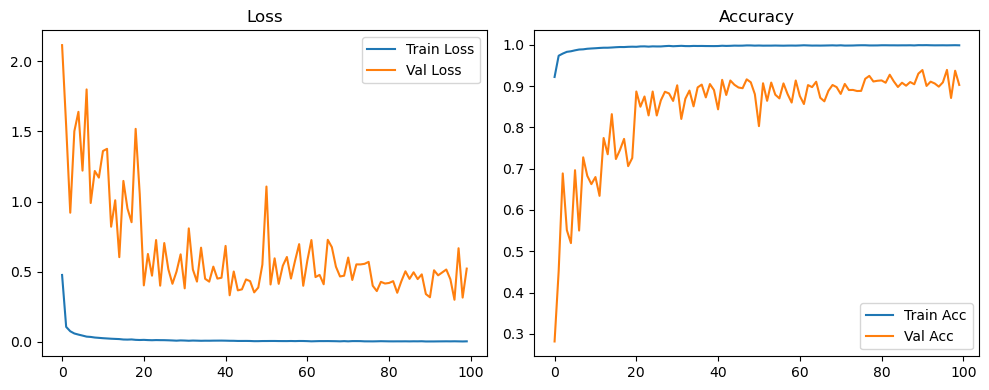

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7757, Acc: 0.7969 | Val Loss: 3.3603, Acc: 0.1497


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2484, Acc: 0.9310 | Val Loss: 3.0989, Acc: 0.2139


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1735, Acc: 0.9486 | Val Loss: 2.6210, Acc: 0.2468


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1419, Acc: 0.9596 | Val Loss: 2.7796, Acc: 0.2637


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1237, Acc: 0.9633 | Val Loss: 3.0710, Acc: 0.2703


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1134, Acc: 0.9658 | Val Loss: 2.7760, Acc: 0.2883


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1034, Acc: 0.9695 | Val Loss: 2.9600, Acc: 0.2795


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0971, Acc: 0.9704 | Val Loss: 2.6416, Acc: 0.2857


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9735 | Val Loss: 2.6773, Acc: 0.3145


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0838, Acc: 0.9749 | Val Loss: 2.6254, Acc: 0.3098


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9746 | Val Loss: 2.8626, Acc: 0.3189


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9751 | Val Loss: 2.2081, Acc: 0.3707


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9769 | Val Loss: 2.6361, Acc: 0.3343


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9770 | Val Loss: 2.5020, Acc: 0.3392


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9786 | Val Loss: 2.4669, Acc: 0.3660


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9783 | Val Loss: 2.4013, Acc: 0.3700


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9790 | Val Loss: 2.1947, Acc: 0.4018


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9793 | Val Loss: 1.8348, Acc: 0.4743


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9795 | Val Loss: 2.5806, Acc: 0.3619


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0630, Acc: 0.9805 | Val Loss: 1.8348, Acc: 0.4681


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9813 | Val Loss: 2.1374, Acc: 0.4370


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9805 | Val Loss: 2.3963, Acc: 0.4134


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9825 | Val Loss: 1.7219, Acc: 0.5221


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9819 | Val Loss: 2.3875, Acc: 0.4256


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9818 | Val Loss: 1.6111, Acc: 0.5627


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9814 | Val Loss: 1.6618, Acc: 0.5702


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9834 | Val Loss: 1.8975, Acc: 0.5178


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9832 | Val Loss: 1.7734, Acc: 0.5295


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9836 | Val Loss: 1.8631, Acc: 0.5495


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9832 | Val Loss: 1.8079, Acc: 0.5634


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9843 | Val Loss: 1.5591, Acc: 0.6163


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9844 | Val Loss: 1.7415, Acc: 0.5443


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9841 | Val Loss: 1.7595, Acc: 0.5580


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9846 | Val Loss: 1.6467, Acc: 0.5796


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9844 | Val Loss: 1.2365, Acc: 0.6431


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9851 | Val Loss: 1.6337, Acc: 0.5623


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9839 | Val Loss: 1.1631, Acc: 0.6645


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 1.5830, Acc: 0.5993


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 1.8675, Acc: 0.5544


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9854 | Val Loss: 1.6755, Acc: 0.5611


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 2.0753, Acc: 0.4943


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9860 | Val Loss: 1.5410, Acc: 0.6472


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 1.7571, Acc: 0.5507


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9860 | Val Loss: 1.3888, Acc: 0.6440


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 1.3957, Acc: 0.6469


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 1.3184, Acc: 0.6604


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 1.5063, Acc: 0.6084


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 1.4013, Acc: 0.6352


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 1.3829, Acc: 0.6409


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9861 | Val Loss: 1.3464, Acc: 0.6420


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9861 | Val Loss: 1.6113, Acc: 0.6230


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9859 | Val Loss: 1.2356, Acc: 0.6764


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9859 | Val Loss: 1.3949, Acc: 0.6540


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 1.2987, Acc: 0.6762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9873 | Val Loss: 1.3185, Acc: 0.6773


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 1.4561, Acc: 0.6478


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 1.5338, Acc: 0.6193


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 1.9319, Acc: 0.5556


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9873 | Val Loss: 1.4141, Acc: 0.6431


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9876 | Val Loss: 1.8819, Acc: 0.5884


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 1.2574, Acc: 0.6706


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 1.4140, Acc: 0.6374


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9873 | Val Loss: 1.3710, Acc: 0.6488


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 1.1737, Acc: 0.6924


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9875 | Val Loss: 1.2551, Acc: 0.6797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 1.7987, Acc: 0.6106


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 1.4670, Acc: 0.6460


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9877 | Val Loss: 1.1832, Acc: 0.6867


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 1.4688, Acc: 0.6422


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 1.4527, Acc: 0.6668


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 1.3580, Acc: 0.6630


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 1.2563, Acc: 0.6722


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9879 | Val Loss: 1.2657, Acc: 0.6797


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9879 | Val Loss: 1.3349, Acc: 0.6612


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9880 | Val Loss: 1.1601, Acc: 0.6943


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 1.2905, Acc: 0.6916


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 1.4018, Acc: 0.6683


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 1.4405, Acc: 0.6573


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 1.0100, Acc: 0.7358


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 1.1666, Acc: 0.7052


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 1.0270, Acc: 0.7326


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.8139, Acc: 0.7761


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9889 | Val Loss: 1.3417, Acc: 0.6802


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9889 | Val Loss: 1.1745, Acc: 0.7034


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.8658, Acc: 0.7625


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9888 | Val Loss: 1.0248, Acc: 0.7251


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 1.0544, Acc: 0.7244


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 1.0138, Acc: 0.7292


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9885 | Val Loss: 0.8984, Acc: 0.7581


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 1.1016, Acc: 0.7101


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 1.3169, Acc: 0.6717


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 1.0012, Acc: 0.7294


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.9988, Acc: 0.7388


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.8854, Acc: 0.7621


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 1.0285, Acc: 0.7227


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 1.0339, Acc: 0.7279


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.9488, Acc: 0.7480


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 1.0552, Acc: 0.7365


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.8170, Acc: 0.7827


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9890 | Val Loss: 1.0333, Acc: 0.7409


Final Test Loss: 0.9924 Accuracy: 0.7491


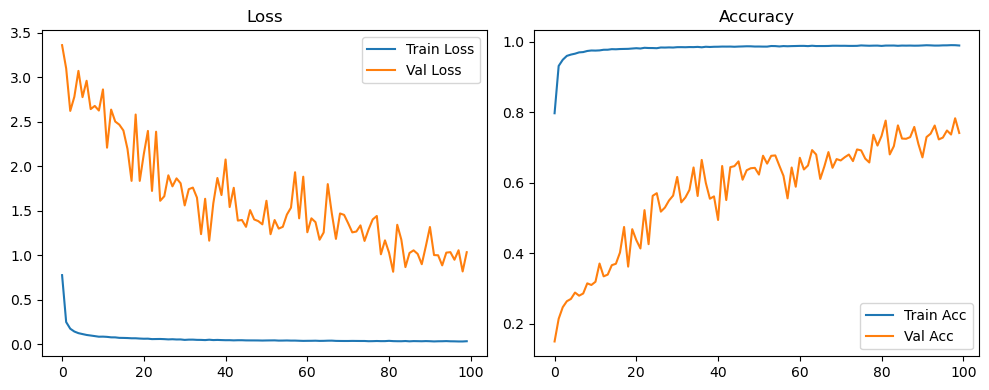

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3927, Acc: 0.9485 | Val Loss: 0.2186, Acc: 0.9422


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9846 | Val Loss: 0.4401, Acc: 0.8640


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9897 | Val Loss: 0.1485, Acc: 0.9572


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9935 | Val Loss: 0.1885, Acc: 0.9432


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9953 | Val Loss: 0.2354, Acc: 0.9295


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9973 | Val Loss: 0.2127, Acc: 0.9313


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9982 | Val Loss: 0.0932, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9994 | Val Loss: 0.0724, Acc: 0.9771


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9998 | Val Loss: 0.0468, Acc: 0.9858


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9997 | Val Loss: 0.0796, Acc: 0.9758


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9997 | Val Loss: 0.0631, Acc: 0.9820


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1536, Acc: 0.9592


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0704, Acc: 0.9793


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.0612, Acc: 0.9831


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9999 | Val Loss: 0.0453, Acc: 0.9875


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9866


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9882


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9885


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9886


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9889


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9890


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9888


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9892


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9887


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9890


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9892


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9894


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9889


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9892


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9888


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9891


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9891


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9891


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9886


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9886


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9885


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9893


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9893


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9892


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9892


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9893


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9892


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9887


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9894


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9888


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9889


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9891


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9890


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9889


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9892


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9891


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9890


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9888


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9886


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9884


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9889


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9890


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9886


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9888


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9892


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9890


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9884


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9890


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9889


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9889


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9886


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9887


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9889


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9888


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9888


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9890


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0564, Acc: 0.9887


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9888


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9889


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9886


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9885


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9884


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9888


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9884


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9884


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9889


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9889


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9889


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9892


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9888


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9887


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9888


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9889


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0611, Acc: 0.9889


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9889


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9889


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9886


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9891


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9880


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9884


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9891


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9886


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9884


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9886


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9885


Final Test Loss: 0.0610 Accuracy: 0.9883


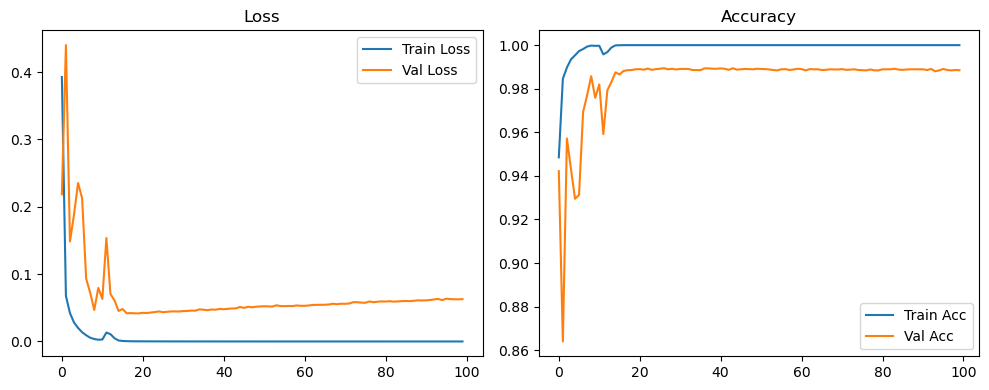

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4767, Acc: 0.9224 | Val Loss: 2.2210, Acc: 0.2617


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1064, Acc: 0.9732 | Val Loss: 1.6244, Acc: 0.4474


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9790 | Val Loss: 0.8984, Acc: 0.6804


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9828 | Val Loss: 1.5736, Acc: 0.4881


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9845 | Val Loss: 1.8120, Acc: 0.4773


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9866 | Val Loss: 1.0128, Acc: 0.7329


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 1.6070, Acc: 0.5919


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9891 | Val Loss: 1.1301, Acc: 0.7090


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 1.1820, Acc: 0.6993


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 1.4816, Acc: 0.5917


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 1.3233, Acc: 0.6790


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9925 | Val Loss: 0.9829, Acc: 0.7334


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.9256, Acc: 0.7535


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.8563, Acc: 0.7799


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.5553, Acc: 0.8497


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 1.0059, Acc: 0.7539


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 1.0661, Acc: 0.7278


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.7624, Acc: 0.7899


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 1.7176, Acc: 0.6552


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 1.2614, Acc: 0.6754


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.6568, Acc: 0.8211


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.4687, Acc: 0.8798


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.5607, Acc: 0.8536


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.8768, Acc: 0.7934


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.7015, Acc: 0.8142


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.6164, Acc: 0.8582


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.5094, Acc: 0.8754


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.3552, Acc: 0.9024


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.6899, Acc: 0.8325


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.5286, Acc: 0.8778


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.6534, Acc: 0.8423


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.3424, Acc: 0.9091


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.5783, Acc: 0.8557


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.3821, Acc: 0.8998


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.6631, Acc: 0.8354


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9965 | Val Loss: 0.4897, Acc: 0.8877


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.2376, Acc: 0.9416


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.5495, Acc: 0.8740


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.4264, Acc: 0.8987


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.3671, Acc: 0.9164


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.4706, Acc: 0.8847


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.3738, Acc: 0.9079


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.5319, Acc: 0.8800


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.5330, Acc: 0.8818


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.3027, Acc: 0.9267


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.2704, Acc: 0.9343


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.3959, Acc: 0.9083


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.3344, Acc: 0.9246


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9975 | Val Loss: 0.3002, Acc: 0.9267


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.4537, Acc: 0.8949


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.4671, Acc: 0.8918


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.4936, Acc: 0.8884


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.4243, Acc: 0.9014


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.3849, Acc: 0.9102


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.4125, Acc: 0.9057


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.4451, Acc: 0.9058


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.3948, Acc: 0.9087


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.4349, Acc: 0.9059


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.3468, Acc: 0.9223


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.5126, Acc: 0.8905


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.5807, Acc: 0.8828


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.4254, Acc: 0.9058


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.4567, Acc: 0.8972


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.3699, Acc: 0.9173


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.4039, Acc: 0.9120


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.4195, Acc: 0.9117


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.3868, Acc: 0.9159


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.4912, Acc: 0.8986


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.4505, Acc: 0.9060


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.4138, Acc: 0.9157


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.3921, Acc: 0.9178


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.3796, Acc: 0.9190


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.4311, Acc: 0.9113


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.3895, Acc: 0.9210


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.4481, Acc: 0.9051


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.4711, Acc: 0.9023


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.3896, Acc: 0.9147


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.4854, Acc: 0.8992


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.4211, Acc: 0.9126


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.4134, Acc: 0.9138


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.4337, Acc: 0.9137


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.4576, Acc: 0.9101


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.4179, Acc: 0.9162


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.3533, Acc: 0.9273


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.3748, Acc: 0.9225


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.3339, Acc: 0.9301


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.3799, Acc: 0.9217


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.4080, Acc: 0.9166


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.4069, Acc: 0.9181


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.3937, Acc: 0.9197


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.4100, Acc: 0.9185


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.4303, Acc: 0.9139


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.4395, Acc: 0.9100


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.4185, Acc: 0.9159


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.4717, Acc: 0.9067


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.5141, Acc: 0.9016


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.4968, Acc: 0.9041


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.5218, Acc: 0.9007


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.4307, Acc: 0.9143


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.4860, Acc: 0.9055


Final Test Loss: 0.5037 Accuracy: 0.9080


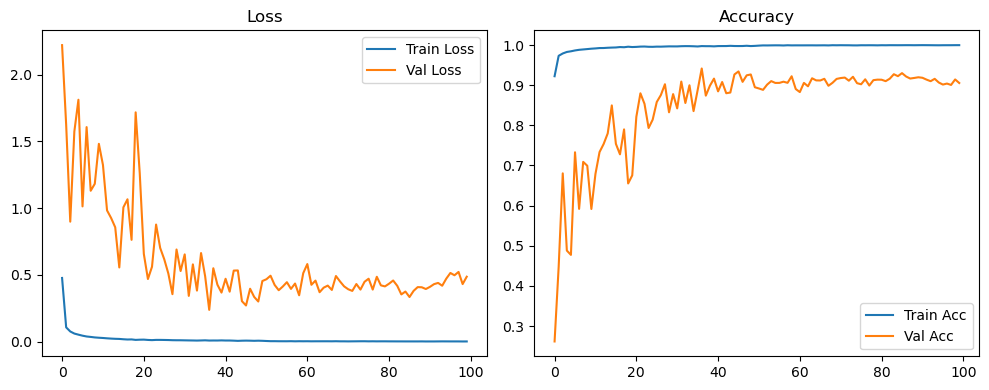

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7756, Acc: 0.7970 | Val Loss: 3.4126, Acc: 0.1436


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2485, Acc: 0.9309 | Val Loss: 2.9847, Acc: 0.2186


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1738, Acc: 0.9487 | Val Loss: 2.5452, Acc: 0.2532


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1424, Acc: 0.9597 | Val Loss: 2.6516, Acc: 0.2714


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1243, Acc: 0.9635 | Val Loss: 2.9260, Acc: 0.2879


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1132, Acc: 0.9661 | Val Loss: 2.6685, Acc: 0.2990


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1031, Acc: 0.9695 | Val Loss: 2.8231, Acc: 0.2907


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0974, Acc: 0.9706 | Val Loss: 2.5569, Acc: 0.2998


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0911, Acc: 0.9735 | Val Loss: 2.5632, Acc: 0.3342


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0834, Acc: 0.9747 | Val Loss: 2.4608, Acc: 0.3352


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9746 | Val Loss: 2.8796, Acc: 0.3249


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9759 | Val Loss: 2.3370, Acc: 0.3614


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9765 | Val Loss: 2.6176, Acc: 0.3392


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9775 | Val Loss: 2.6213, Acc: 0.3329


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9786 | Val Loss: 2.3100, Acc: 0.4012


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9785 | Val Loss: 2.5080, Acc: 0.3509


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0681, Acc: 0.9792 | Val Loss: 2.2041, Acc: 0.4067


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0660, Acc: 0.9793 | Val Loss: 1.8334, Acc: 0.4786


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9798 | Val Loss: 2.4290, Acc: 0.3934


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9801 | Val Loss: 1.5312, Acc: 0.5457


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9810 | Val Loss: 1.8121, Acc: 0.5164


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9805 | Val Loss: 2.5196, Acc: 0.4071


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9826 | Val Loss: 1.4703, Acc: 0.5946


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9818 | Val Loss: 2.2087, Acc: 0.4617


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9821 | Val Loss: 1.3429, Acc: 0.6306


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9818 | Val Loss: 1.7014, Acc: 0.5789


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9828 | Val Loss: 1.7245, Acc: 0.5703


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9831 | Val Loss: 1.4820, Acc: 0.6210


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9840 | Val Loss: 1.4461, Acc: 0.6408


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 1.7136, Acc: 0.5954


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9843 | Val Loss: 1.4688, Acc: 0.6402


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9838 | Val Loss: 1.7104, Acc: 0.5611


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 1.6138, Acc: 0.5879


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9849 | Val Loss: 1.3910, Acc: 0.6255


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9848 | Val Loss: 1.1817, Acc: 0.6663


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 1.5232, Acc: 0.6008


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 1.0744, Acc: 0.7017


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9854 | Val Loss: 1.7129, Acc: 0.5916


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 1.5290, Acc: 0.6311


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9851 | Val Loss: 1.4543, Acc: 0.6444


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9852 | Val Loss: 1.8895, Acc: 0.5532


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9851 | Val Loss: 1.4733, Acc: 0.6675


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 1.4334, Acc: 0.6344


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9854 | Val Loss: 1.1987, Acc: 0.7027


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9855 | Val Loss: 1.4590, Acc: 0.6453


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 1.2408, Acc: 0.6947


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 1.4502, Acc: 0.6164


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9861 | Val Loss: 1.1044, Acc: 0.7057


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 1.3783, Acc: 0.6561


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9865 | Val Loss: 1.2933, Acc: 0.6659


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 1.4020, Acc: 0.6637


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 1.4366, Acc: 0.6442


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9880 | Val Loss: 1.4116, Acc: 0.6627


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 1.3126, Acc: 0.6824


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9884 | Val Loss: 1.4652, Acc: 0.6602


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9878 | Val Loss: 1.3267, Acc: 0.6873


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 1.5845, Acc: 0.6327


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 1.4514, Acc: 0.6541


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 1.3450, Acc: 0.6665


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9889 | Val Loss: 1.4280, Acc: 0.6658


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9900 | Val Loss: 1.3931, Acc: 0.6728


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 1.1782, Acc: 0.6997


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 1.2786, Acc: 0.6892


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 1.1534, Acc: 0.7114


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 1.2622, Acc: 0.6866


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 1.3847, Acc: 0.6868


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9892 | Val Loss: 1.2605, Acc: 0.6947


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 1.3120, Acc: 0.6934


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 1.4158, Acc: 0.6652


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 1.1114, Acc: 0.7292


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9894 | Val Loss: 1.1967, Acc: 0.7001


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9897 | Val Loss: 1.2375, Acc: 0.6983


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 1.1951, Acc: 0.7073


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 1.3339, Acc: 0.6876


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9898 | Val Loss: 1.3522, Acc: 0.6667


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 1.3995, Acc: 0.6813


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 1.5492, Acc: 0.6423


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9898 | Val Loss: 1.4071, Acc: 0.6557


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 1.2602, Acc: 0.6853


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 1.2918, Acc: 0.6971


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 1.1055, Acc: 0.7248


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9907 | Val Loss: 1.0418, Acc: 0.7371


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 1.2049, Acc: 0.7112


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 1.1534, Acc: 0.7140


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9905 | Val Loss: 1.0625, Acc: 0.7326


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 1.1413, Acc: 0.7160


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 1.1515, Acc: 0.7212


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 1.1586, Acc: 0.7211


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 1.0994, Acc: 0.7256


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 1.2108, Acc: 0.7078


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 1.2739, Acc: 0.6977


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 1.0250, Acc: 0.7404


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9910 | Val Loss: 1.0569, Acc: 0.7398


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9913 | Val Loss: 0.9893, Acc: 0.7465


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 1.1515, Acc: 0.7115


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9915 | Val Loss: 1.1523, Acc: 0.7177


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 1.1144, Acc: 0.7280


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 1.1265, Acc: 0.7321


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9914 | Val Loss: 1.0927, Acc: 0.7351


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 1.1617, Acc: 0.7267


Final Test Loss: 1.1453 Accuracy: 0.7287


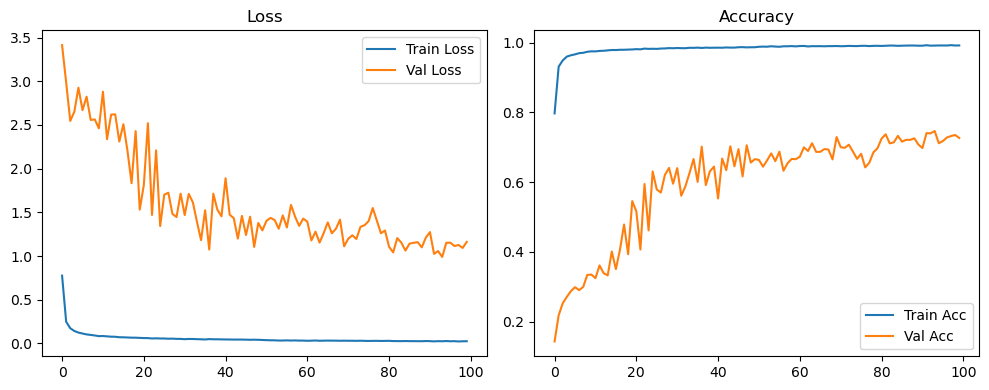

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6669, Acc: 0.9458 | Val Loss: 0.3706, Acc: 0.9307


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1248, Acc: 0.9837 | Val Loss: 0.2106, Acc: 0.9584


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9889 | Val Loss: 0.5133, Acc: 0.8245


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9922 | Val Loss: 0.1996, Acc: 0.9443


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9946 | Val Loss: 0.0967, Acc: 0.9734


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9972 | Val Loss: 0.0821, Acc: 0.9774


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9984 | Val Loss: 0.1104, Acc: 0.9693


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9617


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9996 | Val Loss: 0.0557, Acc: 0.9835


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9998 | Val Loss: 0.0533, Acc: 0.9832


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9999 | Val Loss: 0.0536, Acc: 0.9828


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9864


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9878


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9874


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9884


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9881


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9877


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9868


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9848


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9882


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9858


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.4172, Acc: 0.8762


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0868, Acc: 0.9726


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9969 | Val Loss: 0.0614, Acc: 0.9811


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9993 | Val Loss: 0.0520, Acc: 0.9850


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 1.0000 | Val Loss: 0.0835, Acc: 0.9743


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9886


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9883


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9890


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9895


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9898


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9894


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9888


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9892


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9888


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9888


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9882


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9885


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9891


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9888


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9889


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9888


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9889


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9889


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9892


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9888


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9889


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9888


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9888


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9891


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0475, Acc: 0.9885


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9888


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9891


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9884


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9888


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9888


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9892


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9888


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9883


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9888


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9891


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9890


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9890


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9878


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9887


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9888


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9891


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9886


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9887


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9887


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9891


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9883


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0564, Acc: 0.9887


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9888


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9885


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9888


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9885


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9885


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9887


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9885


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9888


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9882


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9888


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9887


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9887


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9885


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9888


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9885


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9883


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9887


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9891


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9887


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9884


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9874


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9884


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9887


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9881


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9886


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9888


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9883


Final Test Loss: 0.0645 Accuracy: 0.9878


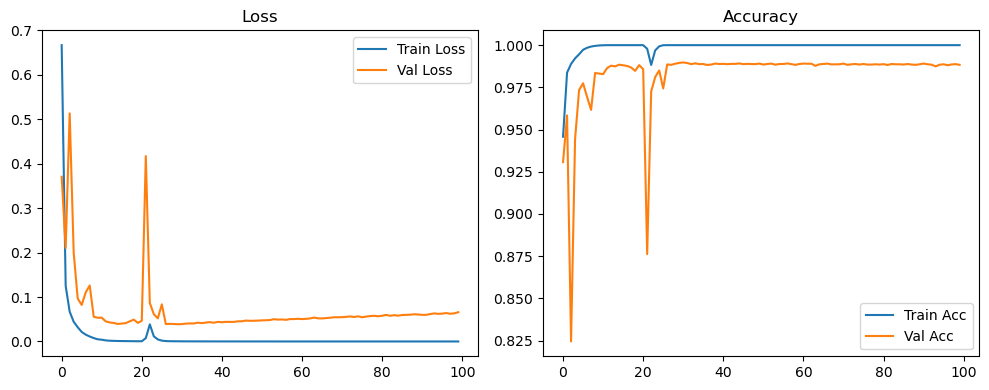

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.7718, Acc: 0.9115 | Val Loss: 2.0556, Acc: 0.2211


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1887, Acc: 0.9699 | Val Loss: 1.0995, Acc: 0.5799


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1154, Acc: 0.9758 | Val Loss: 1.4005, Acc: 0.4635


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0854, Acc: 0.9804 | Val Loss: 1.6593, Acc: 0.4320


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9823 | Val Loss: 2.0713, Acc: 0.3425


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9842 | Val Loss: 1.5534, Acc: 0.5420


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9861 | Val Loss: 2.3866, Acc: 0.3569


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9868 | Val Loss: 1.6738, Acc: 0.4637


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9880 | Val Loss: 1.4658, Acc: 0.5877


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9882 | Val Loss: 2.0794, Acc: 0.4290


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9897 | Val Loss: 1.3334, Acc: 0.5961


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9902 | Val Loss: 1.2690, Acc: 0.6004


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9910 | Val Loss: 1.5436, Acc: 0.5550


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9912 | Val Loss: 1.1627, Acc: 0.6599


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9921 | Val Loss: 0.8849, Acc: 0.7072


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 1.3545, Acc: 0.6193


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9934 | Val Loss: 1.4197, Acc: 0.5787


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9931 | Val Loss: 1.3507, Acc: 0.6268


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9942 | Val Loss: 2.3719, Acc: 0.4941


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 1.6756, Acc: 0.5827


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 1.6035, Acc: 0.5989


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.9310, Acc: 0.7372


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.8155, Acc: 0.7497


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.8140, Acc: 0.7666


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 1.0385, Acc: 0.6844


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.8102, Acc: 0.7902


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.9390, Acc: 0.7426


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.9222, Acc: 0.7377


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 1.5388, Acc: 0.6352


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.7340, Acc: 0.8032


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.7365, Acc: 0.8062


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.6337, Acc: 0.8321


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.8235, Acc: 0.7662


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.5816, Acc: 0.8423


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.8747, Acc: 0.7606


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.7330, Acc: 0.8067


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.5231, Acc: 0.8584


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 1.0497, Acc: 0.7610


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.7169, Acc: 0.8240


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.5573, Acc: 0.8481


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.7477, Acc: 0.8013


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.7170, Acc: 0.8088


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.6564, Acc: 0.8328


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.5720, Acc: 0.8523


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.4597, Acc: 0.8720


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.6036, Acc: 0.8424


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.9435, Acc: 0.7557


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.7580, Acc: 0.8106


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.4916, Acc: 0.8665


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.6117, Acc: 0.8403


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.6433, Acc: 0.8361


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.8372, Acc: 0.7853


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.5819, Acc: 0.8482


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.4710, Acc: 0.8750


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.7807, Acc: 0.8060


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.7760, Acc: 0.8153


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.5327, Acc: 0.8691


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.6306, Acc: 0.8487


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.4354, Acc: 0.8940


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.5320, Acc: 0.8722


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.6897, Acc: 0.8442


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.4918, Acc: 0.8750


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.4399, Acc: 0.8915


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.2990, Acc: 0.9259


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.3649, Acc: 0.9045


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.4179, Acc: 0.8995


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.4080, Acc: 0.8978


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.4495, Acc: 0.8878


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.5015, Acc: 0.8800


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.5469, Acc: 0.8653


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.4835, Acc: 0.8885


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.5183, Acc: 0.8744


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.6478, Acc: 0.8492


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.6356, Acc: 0.8453


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.5937, Acc: 0.8584


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.3152, Acc: 0.9213


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.3473, Acc: 0.9147


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.4614, Acc: 0.8886


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.4391, Acc: 0.8943


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.6580, Acc: 0.8483


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.3428, Acc: 0.9153


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.3370, Acc: 0.9194


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.4343, Acc: 0.8936


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.4031, Acc: 0.9013


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.5061, Acc: 0.8818


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.5073, Acc: 0.8812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3875, Acc: 0.9109


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.3721, Acc: 0.9139


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.3614, Acc: 0.9137


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.4196, Acc: 0.9010


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.3816, Acc: 0.9101


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.4063, Acc: 0.9030


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.4411, Acc: 0.9002


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.4770, Acc: 0.8946


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3167, Acc: 0.9283


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.4305, Acc: 0.8998


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.5139, Acc: 0.8859


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.3801, Acc: 0.9137


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.3651, Acc: 0.9171


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.3274, Acc: 0.9269


Final Test Loss: 0.3310 Accuracy: 0.9276


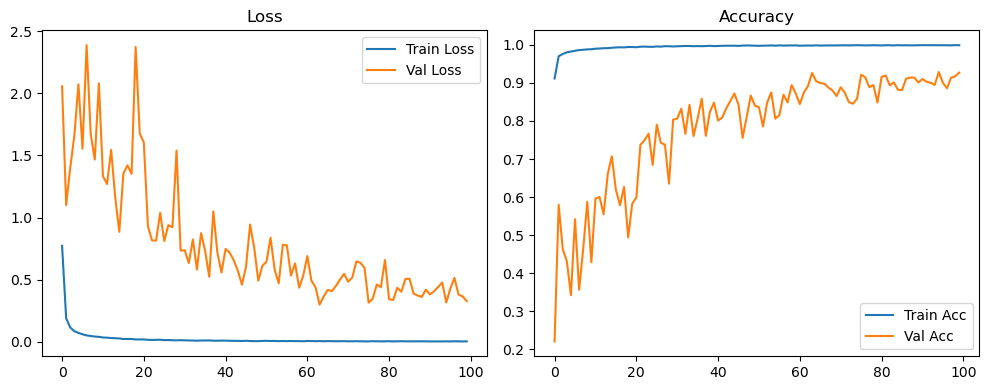

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 1.1147, Acc: 0.7375 | Val Loss: 3.5079, Acc: 0.1133


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4422, Acc: 0.8946 | Val Loss: 3.3355, Acc: 0.1832


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2812, Acc: 0.9269 | Val Loss: 3.1048, Acc: 0.2117


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2118, Acc: 0.9429 | Val Loss: 3.4052, Acc: 0.2145


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1785, Acc: 0.9505 | Val Loss: 3.6961, Acc: 0.2174


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1567, Acc: 0.9560 | Val Loss: 3.6077, Acc: 0.2243


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1406, Acc: 0.9597 | Val Loss: 3.5907, Acc: 0.2216


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1281, Acc: 0.9633 | Val Loss: 3.3997, Acc: 0.2350


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1199, Acc: 0.9662 | Val Loss: 3.4044, Acc: 0.2496


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1090, Acc: 0.9675 | Val Loss: 3.4484, Acc: 0.2314


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1083, Acc: 0.9682 | Val Loss: 3.4019, Acc: 0.2425


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1000, Acc: 0.9704 | Val Loss: 3.1451, Acc: 0.2526


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0952, Acc: 0.9719 | Val Loss: 3.1698, Acc: 0.2651


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9721 | Val Loss: 3.3135, Acc: 0.2493


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0880, Acc: 0.9743 | Val Loss: 3.5169, Acc: 0.2431


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0847, Acc: 0.9748 | Val Loss: 3.6276, Acc: 0.2364


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0825, Acc: 0.9749 | Val Loss: 3.6511, Acc: 0.2425


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9761 | Val Loss: 3.2735, Acc: 0.2843


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0795, Acc: 0.9760 | Val Loss: 3.6296, Acc: 0.2478


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9776 | Val Loss: 3.2129, Acc: 0.2724


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0733, Acc: 0.9773 | Val Loss: 3.2150, Acc: 0.2966


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0703, Acc: 0.9778 | Val Loss: 3.3579, Acc: 0.2927


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9797 | Val Loss: 3.0569, Acc: 0.2815


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9800 | Val Loss: 3.1770, Acc: 0.2951


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9788 | Val Loss: 3.0453, Acc: 0.3019


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9791 | Val Loss: 3.1091, Acc: 0.3062


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9802 | Val Loss: 3.1415, Acc: 0.3048


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9814 | Val Loss: 2.8790, Acc: 0.3420


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0607, Acc: 0.9815 | Val Loss: 2.7863, Acc: 0.3561


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9809 | Val Loss: 2.8429, Acc: 0.3622


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9818 | Val Loss: 2.8382, Acc: 0.3977


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9824 | Val Loss: 2.9954, Acc: 0.3362


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9827 | Val Loss: 2.6840, Acc: 0.3684


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9822 | Val Loss: 2.5494, Acc: 0.4107


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9837 | Val Loss: 2.6997, Acc: 0.3540


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9842 | Val Loss: 2.9456, Acc: 0.3537


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 2.2535, Acc: 0.4301


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9830 | Val Loss: 2.5531, Acc: 0.4080


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9839 | Val Loss: 2.8183, Acc: 0.3871


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9834 | Val Loss: 2.6931, Acc: 0.3939


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9832 | Val Loss: 2.6469, Acc: 0.3947


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9837 | Val Loss: 2.6253, Acc: 0.4059


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 2.3068, Acc: 0.4475


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 2.6090, Acc: 0.4007


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9845 | Val Loss: 2.1161, Acc: 0.4647


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0478, Acc: 0.9846 | Val Loss: 2.0917, Acc: 0.4867


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9844 | Val Loss: 2.6838, Acc: 0.3864


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9846 | Val Loss: 2.4951, Acc: 0.4072


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9851 | Val Loss: 2.4319, Acc: 0.4419


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9856 | Val Loss: 2.2608, Acc: 0.4680


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 2.1842, Acc: 0.4919


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9843 | Val Loss: 1.9143, Acc: 0.5131


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 1.9126, Acc: 0.5308


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9858 | Val Loss: 1.7912, Acc: 0.5449


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 2.4907, Acc: 0.4535


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9857 | Val Loss: 2.3565, Acc: 0.4446


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 2.3973, Acc: 0.4483


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 1.9945, Acc: 0.4998


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9861 | Val Loss: 2.2917, Acc: 0.4387


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9865 | Val Loss: 2.1839, Acc: 0.4798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 2.2164, Acc: 0.4715


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 1.8706, Acc: 0.5412


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 1.8717, Acc: 0.5295


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 1.8457, Acc: 0.5527


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9865 | Val Loss: 2.4362, Acc: 0.4528


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 1.9525, Acc: 0.5410


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9864 | Val Loss: 1.7719, Acc: 0.5606


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9862 | Val Loss: 1.7415, Acc: 0.5663


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 1.7451, Acc: 0.5593


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9869 | Val Loss: 1.9583, Acc: 0.5503


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 1.9637, Acc: 0.5465


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9869 | Val Loss: 2.3136, Acc: 0.4779


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 2.0808, Acc: 0.5255


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9870 | Val Loss: 2.1526, Acc: 0.5134


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9880 | Val Loss: 2.2767, Acc: 0.4818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 1.9275, Acc: 0.5592


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9878 | Val Loss: 2.0168, Acc: 0.5386


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 1.8471, Acc: 0.5720


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9873 | Val Loss: 1.6525, Acc: 0.6083


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 1.7281, Acc: 0.5623


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 1.6978, Acc: 0.5753


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9871 | Val Loss: 1.6662, Acc: 0.6028


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 2.2062, Acc: 0.5212


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9882 | Val Loss: 1.8855, Acc: 0.5641


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 1.5779, Acc: 0.5930


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 1.8200, Acc: 0.5658


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 1.7045, Acc: 0.6022


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9887 | Val Loss: 1.8098, Acc: 0.5748


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 1.5970, Acc: 0.6176


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9878 | Val Loss: 1.8627, Acc: 0.5683


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 1.8830, Acc: 0.5536


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 1.6246, Acc: 0.6025


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9885 | Val Loss: 1.7149, Acc: 0.5897


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 1.7045, Acc: 0.5763


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 2.3139, Acc: 0.4894


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 2.0176, Acc: 0.5402


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 1.5986, Acc: 0.5951


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 1.7211, Acc: 0.5928


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 1.7267, Acc: 0.5883


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 1.5388, Acc: 0.6298


Final Test Loss: 1.5062 Accuracy: 0.6418


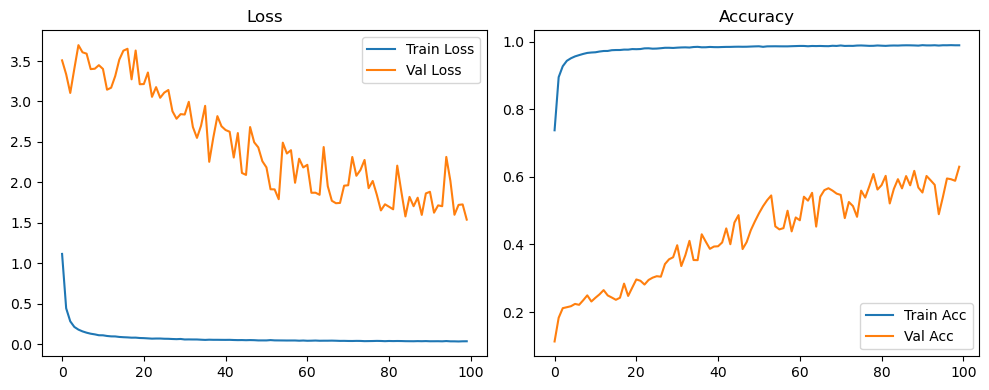

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9687, Acc: 0.9386 | Val Loss: 0.6209, Acc: 0.9222


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2727, Acc: 0.9804 | Val Loss: 0.4147, Acc: 0.9318


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1290, Acc: 0.9871 | Val Loss: 0.3511, Acc: 0.9383


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9903 | Val Loss: 0.1815, Acc: 0.9650


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9933 | Val Loss: 0.1429, Acc: 0.9676


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9957 | Val Loss: 0.2133, Acc: 0.9493


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9972 | Val Loss: 0.0783, Acc: 0.9820


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9985 | Val Loss: 0.1386, Acc: 0.9625


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9991 | Val Loss: 0.0657, Acc: 0.9820


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9995 | Val Loss: 0.0946, Acc: 0.9720


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9997 | Val Loss: 0.1246, Acc: 0.9636


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 1.0000 | Val Loss: 0.0962, Acc: 0.9723


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 1.0000 | Val Loss: 0.0725, Acc: 0.9799


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9869


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9823


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9852


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9807


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9711


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 1.0000 | Val Loss: 0.0746, Acc: 0.9788


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9891


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9828


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9857


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9878


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9876


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9929 | Val Loss: 0.2131, Acc: 0.9369


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9929 | Val Loss: 0.0724, Acc: 0.9772


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9988 | Val Loss: 0.1784, Acc: 0.9474


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9998 | Val Loss: 0.0424, Acc: 0.9876


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9888


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9889


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9896


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9896


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9891


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9893


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9892


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9889


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9895


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9891


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9889


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9888


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9893


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9889


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9889


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9888


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9891


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9885


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9886


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9888


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9887


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9886


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9881


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9884


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9889


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9889


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9888


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9888


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9883


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9886


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9882


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9882


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9878


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9882


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9884


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9887


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9878


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9883


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9882


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0484, Acc: 0.9879


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9880


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9877


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0487, Acc: 0.9878


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9872


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9881


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9877


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9881


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9878


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9882


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9880


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9878


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9874


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9878


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9882


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0533, Acc: 0.9881


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9882


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9879


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9878


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9877


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9874


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9870


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0485, Acc: 0.9852 | Val Loss: 0.2237, Acc: 0.9334


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.1172, Acc: 0.9654


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9997 | Val Loss: 0.0558, Acc: 0.9835


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9880


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9878


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9884


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9888


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9885


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9890


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9888


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9884


Final Test Loss: 0.0398 Accuracy: 0.9888


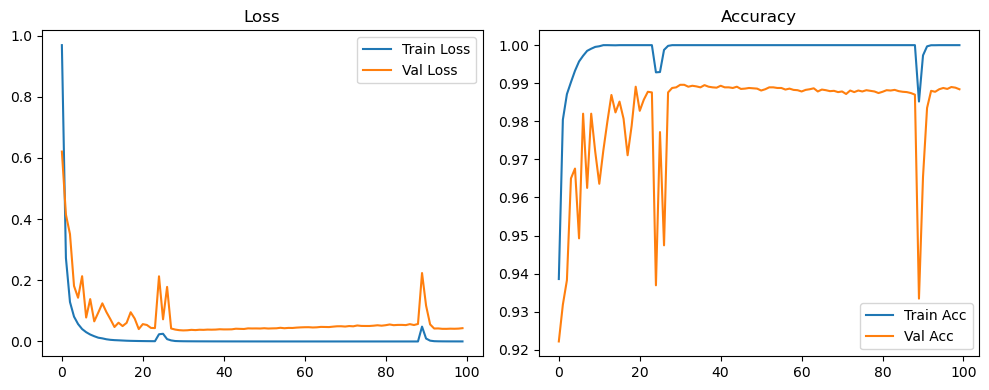

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.0755, Acc: 0.8933 | Val Loss: 1.8209, Acc: 0.2171


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3751, Acc: 0.9627 | Val Loss: 1.1347, Acc: 0.5637


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2016, Acc: 0.9714 | Val Loss: 1.6129, Acc: 0.4014


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1359, Acc: 0.9782 | Val Loss: 1.5471, Acc: 0.4037


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1071, Acc: 0.9794 | Val Loss: 1.9673, Acc: 0.3235


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0872, Acc: 0.9817 | Val Loss: 1.7121, Acc: 0.3872


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9846 | Val Loss: 2.0765, Acc: 0.3672


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0650, Acc: 0.9855 | Val Loss: 1.4666, Acc: 0.5413


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0589, Acc: 0.9864 | Val Loss: 2.2392, Acc: 0.3718


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9869 | Val Loss: 1.8167, Acc: 0.4208


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9874 | Val Loss: 2.0899, Acc: 0.3712


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9885 | Val Loss: 1.8777, Acc: 0.4487


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9891 | Val Loss: 1.8046, Acc: 0.4746


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9892 | Val Loss: 1.6115, Acc: 0.5456


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9903 | Val Loss: 1.7694, Acc: 0.5020


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9919 | Val Loss: 1.9631, Acc: 0.4813


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9913 | Val Loss: 1.8681, Acc: 0.4893


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9916 | Val Loss: 1.8847, Acc: 0.4937


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9921 | Val Loss: 2.7217, Acc: 0.3748


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9930 | Val Loss: 2.5705, Acc: 0.3528


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9927 | Val Loss: 1.6382, Acc: 0.5767


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9935 | Val Loss: 1.5680, Acc: 0.5827


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 1.1127, Acc: 0.6681


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9933 | Val Loss: 1.4518, Acc: 0.5961


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9938 | Val Loss: 1.9334, Acc: 0.5487


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9945 | Val Loss: 1.4707, Acc: 0.6685


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 1.2691, Acc: 0.6783


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9948 | Val Loss: 1.7984, Acc: 0.5769


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 1.4990, Acc: 0.6177


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 1.5702, Acc: 0.6272


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 1.0512, Acc: 0.7142


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 1.3726, Acc: 0.6387


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 1.6938, Acc: 0.5978


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 1.2486, Acc: 0.6673


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 1.1325, Acc: 0.7218


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 1.1995, Acc: 0.6714


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 1.0295, Acc: 0.7352


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 1.6647, Acc: 0.6417


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 1.0852, Acc: 0.7573


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 1.5106, Acc: 0.6683


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 1.1351, Acc: 0.7145


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 1.4064, Acc: 0.6750


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 1.0886, Acc: 0.7196


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 1.5854, Acc: 0.6392


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 1.0272, Acc: 0.7218


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 1.4509, Acc: 0.6947


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 1.2696, Acc: 0.6636


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 1.1284, Acc: 0.7323


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 1.1292, Acc: 0.7194


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.8539, Acc: 0.7970


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.8588, Acc: 0.7759


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 1.1934, Acc: 0.7279


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 1.3172, Acc: 0.6910


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.9253, Acc: 0.7716


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 1.2589, Acc: 0.7379


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 1.4789, Acc: 0.6607


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 1.1895, Acc: 0.7479


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 1.0301, Acc: 0.7595


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.8828, Acc: 0.7993


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 1.5727, Acc: 0.6763


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 1.4002, Acc: 0.7241


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.7039, Acc: 0.8109


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 1.2233, Acc: 0.7085


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.7741, Acc: 0.8073


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 1.0313, Acc: 0.7590


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.7640, Acc: 0.8095


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 1.0073, Acc: 0.7648


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.7112, Acc: 0.8169


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.6523, Acc: 0.8378


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 1.2576, Acc: 0.7291


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.7044, Acc: 0.8350


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 1.0225, Acc: 0.7393


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.9195, Acc: 0.8014


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.9325, Acc: 0.7898


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.5201, Acc: 0.8551


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.4832, Acc: 0.8812


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.8322, Acc: 0.8106


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.8461, Acc: 0.7992


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.5700, Acc: 0.8557


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 1.5007, Acc: 0.7089


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.7144, Acc: 0.8340


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.8661, Acc: 0.8023


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.8830, Acc: 0.8084


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.6731, Acc: 0.8310


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.6593, Acc: 0.8487


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.6106, Acc: 0.8492


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.8113, Acc: 0.8143


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.6377, Acc: 0.8620


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.4424, Acc: 0.8928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.6797, Acc: 0.8435


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.5475, Acc: 0.8744


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.6065, Acc: 0.8758


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.9449, Acc: 0.8022


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.6081, Acc: 0.8622


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.8745, Acc: 0.8047


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.8036, Acc: 0.8197


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 1.0092, Acc: 0.8003


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.7352, Acc: 0.8488


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.7803, Acc: 0.8475


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.6717, Acc: 0.8499


Final Test Loss: 0.6610 Accuracy: 0.8514


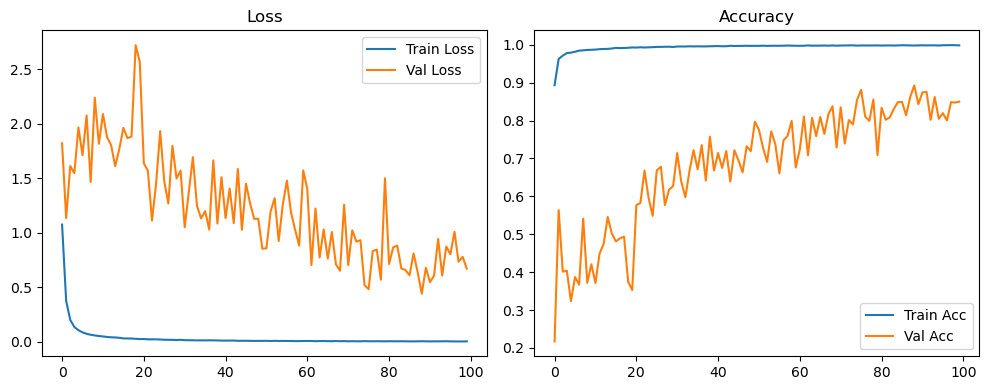

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.3918, Acc: 0.6803 | Val Loss: 3.0509, Acc: 0.1133


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.7320, Acc: 0.8472 | Val Loss: 3.3250, Acc: 0.1133


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.4721, Acc: 0.8924 | Val Loss: 3.2177, Acc: 0.1867


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3445, Acc: 0.9185 | Val Loss: 3.3823, Acc: 0.2092


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2791, Acc: 0.9293 | Val Loss: 3.6865, Acc: 0.2090


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2358, Acc: 0.9394 | Val Loss: 3.5714, Acc: 0.2123


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2073, Acc: 0.9457 | Val Loss: 3.5029, Acc: 0.2168


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1828, Acc: 0.9506 | Val Loss: 3.4508, Acc: 0.2241


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1687, Acc: 0.9534 | Val Loss: 3.3993, Acc: 0.2377


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1526, Acc: 0.9577 | Val Loss: 3.6415, Acc: 0.2183


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1453, Acc: 0.9584 | Val Loss: 3.5465, Acc: 0.2319


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1359, Acc: 0.9619 | Val Loss: 3.3516, Acc: 0.2442


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1284, Acc: 0.9639 | Val Loss: 3.4752, Acc: 0.2354


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1243, Acc: 0.9639 | Val Loss: 3.5747, Acc: 0.2338


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1171, Acc: 0.9672 | Val Loss: 3.7253, Acc: 0.2289


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1105, Acc: 0.9680 | Val Loss: 3.6640, Acc: 0.2354


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1073, Acc: 0.9694 | Val Loss: 3.8806, Acc: 0.2291


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1016, Acc: 0.9698 | Val Loss: 3.6871, Acc: 0.2364


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1013, Acc: 0.9703 | Val Loss: 3.9055, Acc: 0.2255


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0958, Acc: 0.9720 | Val Loss: 3.7346, Acc: 0.2277


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0921, Acc: 0.9724 | Val Loss: 3.6110, Acc: 0.2539


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0889, Acc: 0.9733 | Val Loss: 3.7263, Acc: 0.2471


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0852, Acc: 0.9747 | Val Loss: 3.6808, Acc: 0.2250


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0854, Acc: 0.9748 | Val Loss: 3.6445, Acc: 0.2283


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0831, Acc: 0.9746 | Val Loss: 3.5669, Acc: 0.2308


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0818, Acc: 0.9749 | Val Loss: 3.7826, Acc: 0.2293


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0808, Acc: 0.9758 | Val Loss: 3.8967, Acc: 0.2320


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0776, Acc: 0.9776 | Val Loss: 3.3685, Acc: 0.2659


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9779 | Val Loss: 3.3790, Acc: 0.2616


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0760, Acc: 0.9772 | Val Loss: 3.5323, Acc: 0.2680


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0705, Acc: 0.9785 | Val Loss: 3.4054, Acc: 0.2819


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0706, Acc: 0.9781 | Val Loss: 3.6168, Acc: 0.2552


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9799 | Val Loss: 3.6291, Acc: 0.2737


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9788 | Val Loss: 3.3176, Acc: 0.3113


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9798 | Val Loss: 3.4395, Acc: 0.2635


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9806 | Val Loss: 3.5427, Acc: 0.2712


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0648, Acc: 0.9798 | Val Loss: 3.2404, Acc: 0.2837


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0632, Acc: 0.9808 | Val Loss: 3.4482, Acc: 0.2951


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0631, Acc: 0.9807 | Val Loss: 3.6316, Acc: 0.2772


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9813 | Val Loss: 3.6386, Acc: 0.2918


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0614, Acc: 0.9810 | Val Loss: 3.6822, Acc: 0.2677


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9811 | Val Loss: 3.9760, Acc: 0.2506


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9815 | Val Loss: 3.5776, Acc: 0.2875


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9816 | Val Loss: 3.6308, Acc: 0.2821


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9825 | Val Loss: 3.1892, Acc: 0.2968


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9836 | Val Loss: 3.0818, Acc: 0.3277


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9818 | Val Loss: 3.1613, Acc: 0.3212


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9823 | Val Loss: 3.2047, Acc: 0.2960


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9830 | Val Loss: 3.1267, Acc: 0.3276


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9834 | Val Loss: 2.9244, Acc: 0.3519


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9829 | Val Loss: 2.8016, Acc: 0.3615


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9827 | Val Loss: 2.9254, Acc: 0.3583


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0523, Acc: 0.9836 | Val Loss: 2.8182, Acc: 0.3852


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9831 | Val Loss: 3.1104, Acc: 0.3349


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 3.1676, Acc: 0.3625


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9836 | Val Loss: 3.1035, Acc: 0.3213


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9840 | Val Loss: 3.0221, Acc: 0.3377


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 3.1247, Acc: 0.3085


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 3.2260, Acc: 0.3000


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9847 | Val Loss: 2.8785, Acc: 0.3522


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9849 | Val Loss: 2.9282, Acc: 0.3484


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 2.5307, Acc: 0.4094


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9849 | Val Loss: 2.8156, Acc: 0.3678


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 2.5418, Acc: 0.4201


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 2.8146, Acc: 0.3817


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9845 | Val Loss: 2.4646, Acc: 0.4116


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 2.5795, Acc: 0.3882


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9848 | Val Loss: 2.2052, Acc: 0.4618


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 2.4676, Acc: 0.4320


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9854 | Val Loss: 2.5731, Acc: 0.4166


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 2.3636, Acc: 0.4363


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9853 | Val Loss: 2.7178, Acc: 0.3972


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9852 | Val Loss: 2.9201, Acc: 0.3961


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9852 | Val Loss: 2.6024, Acc: 0.4218


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9868 | Val Loss: 2.7300, Acc: 0.3908


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9868 | Val Loss: 2.2826, Acc: 0.4537


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9870 | Val Loss: 2.6326, Acc: 0.4087


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 2.4126, Acc: 0.4274


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 2.2527, Acc: 0.4557


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9864 | Val Loss: 2.5591, Acc: 0.4027


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 2.1962, Acc: 0.4608


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9864 | Val Loss: 2.0763, Acc: 0.4818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9874 | Val Loss: 2.3604, Acc: 0.4613


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9866 | Val Loss: 2.2418, Acc: 0.4709


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9867 | Val Loss: 2.0047, Acc: 0.4888


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 1.9322, Acc: 0.5117


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9872 | Val Loss: 1.9390, Acc: 0.5221


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9871 | Val Loss: 2.1144, Acc: 0.4924


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9864 | Val Loss: 1.7289, Acc: 0.5603


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 2.0848, Acc: 0.5023


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9872 | Val Loss: 2.2346, Acc: 0.4788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9871 | Val Loss: 1.7481, Acc: 0.5569


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 2.0053, Acc: 0.5144


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 1.8359, Acc: 0.5282


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 2.1791, Acc: 0.4863


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 1.7887, Acc: 0.5470


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 2.1427, Acc: 0.4891


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 2.2416, Acc: 0.4723


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9885 | Val Loss: 2.0429, Acc: 0.5138


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 1.8010, Acc: 0.5614


Final Test Loss: 1.7697 Accuracy: 0.5615


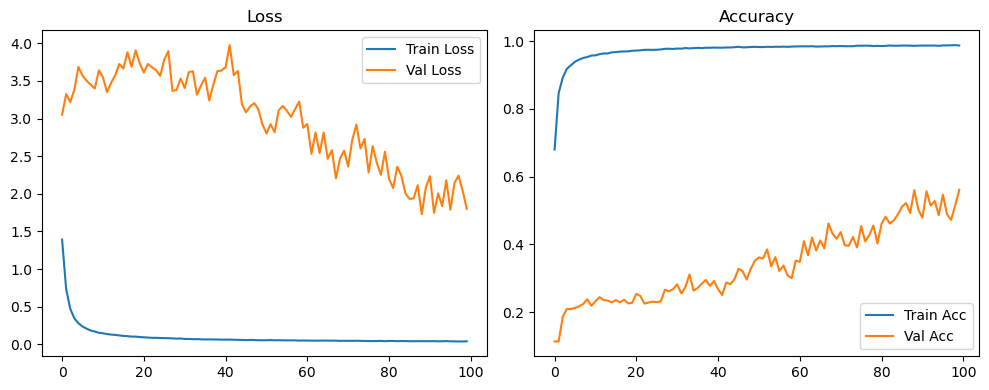

🏆 Best Config: batch128_lr0.01_0.005_0.001_dp0.0 Accuracy: 0.9910


In [8]:
root_path = "TCV_8bit_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)